In [1]:
!rm -rf img/ && mkdir -p img

In [2]:
import time

import figtools as ftl
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.optim

In [3]:
from helper.data import DataLoader, init_state
from helper.ukf import init_ukf

In [4]:
torch.manual_seed(0)
assert torch.all(torch.randint(10, (10,)) == torch.tensor([4, 9, 3, 0, 3, 9, 7, 3, 7, 3]))

In [5]:
data_loader = DataLoader(phi=torch.tensor([0., np.pi / 2., np.pi, 3. / 2. * np.pi]),
                         v0=torch.tensor([1., 2., 3., 4.]),
                         n=30,
                         n_repeat=7,
                         noise=torch.tensor(.3).repeat(4, 2))
X, _ = data_loader(window_size=100, randomize=True)
X.shape

torch.Size([4, 2, 111, 100])

In [6]:
def train_window(X, *, f, optimizer, state_cov):
    b, _, _ = X.shape
    
    optimizer.zero_grad()

    Y, state, state_covs = f(X, init_state(X), state_cov)
    loss = torch.sum((X - Y)**2, dim=(1, 2))
    loss.backward(torch.ones(b))

    optimizer.step()

    return {
        'process_noise': f.process_noise.detach(),
        'measurement_noise': f.measurement_noise.detach(),
        'state_cov': state_covs[:, :, :, -1].detach(),
        'loss': loss.tolist(),
    }


def train_epoch(X, *, f, optimizer, w_max=None):
    b, _, w, _ = X.shape
    if w_max:
        w = min(w, w_max)
    
    losses = []
    state_cov = torch.eye(4).repeat(b, 1, 1)
    
    rnd = torch.rand(b, 2)
    process_noise = torch.zeros(b, 10)
    process_noise[:, 0] = rnd[:, 0]
    process_noise[:, 2] = rnd[:, 0]
    process_noise[:, 5] = rnd[:, 1]
    process_noise[:, 9] = rnd[:, 1]
    
    rnd = torch.rand(b, 1)
    measurement_noise = torch.zeros(b, 3)
    measurement_noise[:, 0] = rnd[:, 0]
    measurement_noise[:, 2] = rnd[:, 0]
    
    stats = None
    for i in range(w):
        f.process_noise = process_noise
        f.measurement_noise = measurement_noise
        stats = train_window(X[:, :, i],
                             f=f,
                             optimizer=optimizer,
                             state_cov=state_cov)
        
        process_noise = stats['process_noise']
        measurement_noise = stats['measurement_noise']
        state_cov = stats['state_cov']
        losses.append(stats['loss'])
    
    return losses, stats


def train(X, *, n_epochs, w_max=None, verbose=False):
    b, _, _, _ = X.shape
    ukf = init_ukf(batch_size=b)
    optimizer = torch.optim.SGD(ukf.parameters(), lr=1e-4)
    
    for i in range(n_epochs):
        t_start = time.time()
        loss, stats = train_epoch(X, f=ukf, optimizer=optimizer, w_max=w_max)
        t_end = time.time()

        if verbose:
            loss = np.array(loss)
            print(f'Epoch #{i+1}:', f'(elapsed time: {(t_end-t_start):.2f}s)')    
            print(loss[:10])
            print('...')
            print(loss[-10:])
            
    stats['process_noise_cov'] = ukf.process_noise_cov()
    stats['measurement_noise_cov'] = ukf.measurement_noise_cov()
    
    return stats

In [7]:
stats = train(X, n_epochs=1, verbose=True)
state_cov = stats['state_cov']
process_noise = stats['process_noise']
measurement_noise = stats['measurement_noise']

Epoch #1: (elapsed time: 20.54s)
[[  76.12459564  263.44937134  344.31958008 1045.51708984]
 [  89.54418182  289.06787109  370.07015991 1094.31591797]
 [ 106.90124512  289.34255981  389.10128784 1025.04541016]
 [ 101.45912933  287.40777588  388.19204712  984.36175537]
 [  88.06903076  283.45458984  374.37734985  941.04589844]
 [  87.00930023  279.99884033  373.18057251  907.66784668]
 [ 101.57534027  281.40768433  385.09274292  883.10070801]
 [ 103.2991333   281.09365845  381.23443604  851.00335693]
 [  81.64722443  268.66662598  377.58267212  842.59680176]
 [  96.03916168  280.9102478   377.0869751   804.37756348]]
...
[[101.37065125 213.347229   346.57678223 590.64654541]
 [108.20802307 213.93011475 349.40197754 571.63720703]
 [103.73384857 215.71463013 351.17874146 569.69720459]
 [106.45769501 214.37025452 350.32653809 573.05487061]
 [ 83.49108124 201.96115112 322.15496826 589.15612793]
 [ 99.6187439  212.40058899 347.94348145 588.85217285]
 [ 93.13483429 200.34844971 319.41720581 5

In [8]:
stats['process_noise_cov']

tensor([[[ 3.0759,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  3.0759,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  2.9573,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  2.9573]],

        [[ 1.2608,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.2608,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  8.2984,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  8.2984]],

        [[ 1.1265,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.1265,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  8.8890,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  8.8890]],

        [[ 1.1948,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.1948,  0.0000,  0.0000],
         [ 0.0000,  0.0000, 12.9273,  0.0000],
         [ 0.0000,  0.0000,  0.0000, 12.9273]]], grad_fn=<UnsafeViewBackward>)

In [9]:
stats['measurement_noise_cov']

tensor([[[1.6023, 0.0000],
         [0.0000, 1.6023]],

        [[2.5787, 0.0000],
         [0.0000, 2.5787]],

        [[0.7725, 0.0000],
         [0.0000, 0.7725]],

        [[0.8611, 0.0000],
         [0.0000, 0.8611]]], grad_fn=<UnsafeViewBackward>)

In [10]:
def evaluate(X, *, state_cov, process_noise, measurement_noise):
    b, _, _ = X.shape
    
    with torch.no_grad():
        ukf = init_ukf(batch_size=b)
        ukf.process_noise = process_noise
        ukf.measurement_noise = measurement_noise
        
        y, state, _ = ukf(X, init_state(X), state_cov)
    
    return y, state

In [11]:
X_pred, _ = evaluate(X[:, :, -1], state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
torch.sum((X[:, :, -1] - X_pred)**2, dim=(1, 2))

tensor([104.6504, 211.5413, 342.3497, 579.4347])

In [12]:
X_pred.shape, X.shape

(torch.Size([4, 2, 100]), torch.Size([4, 2, 111, 100]))


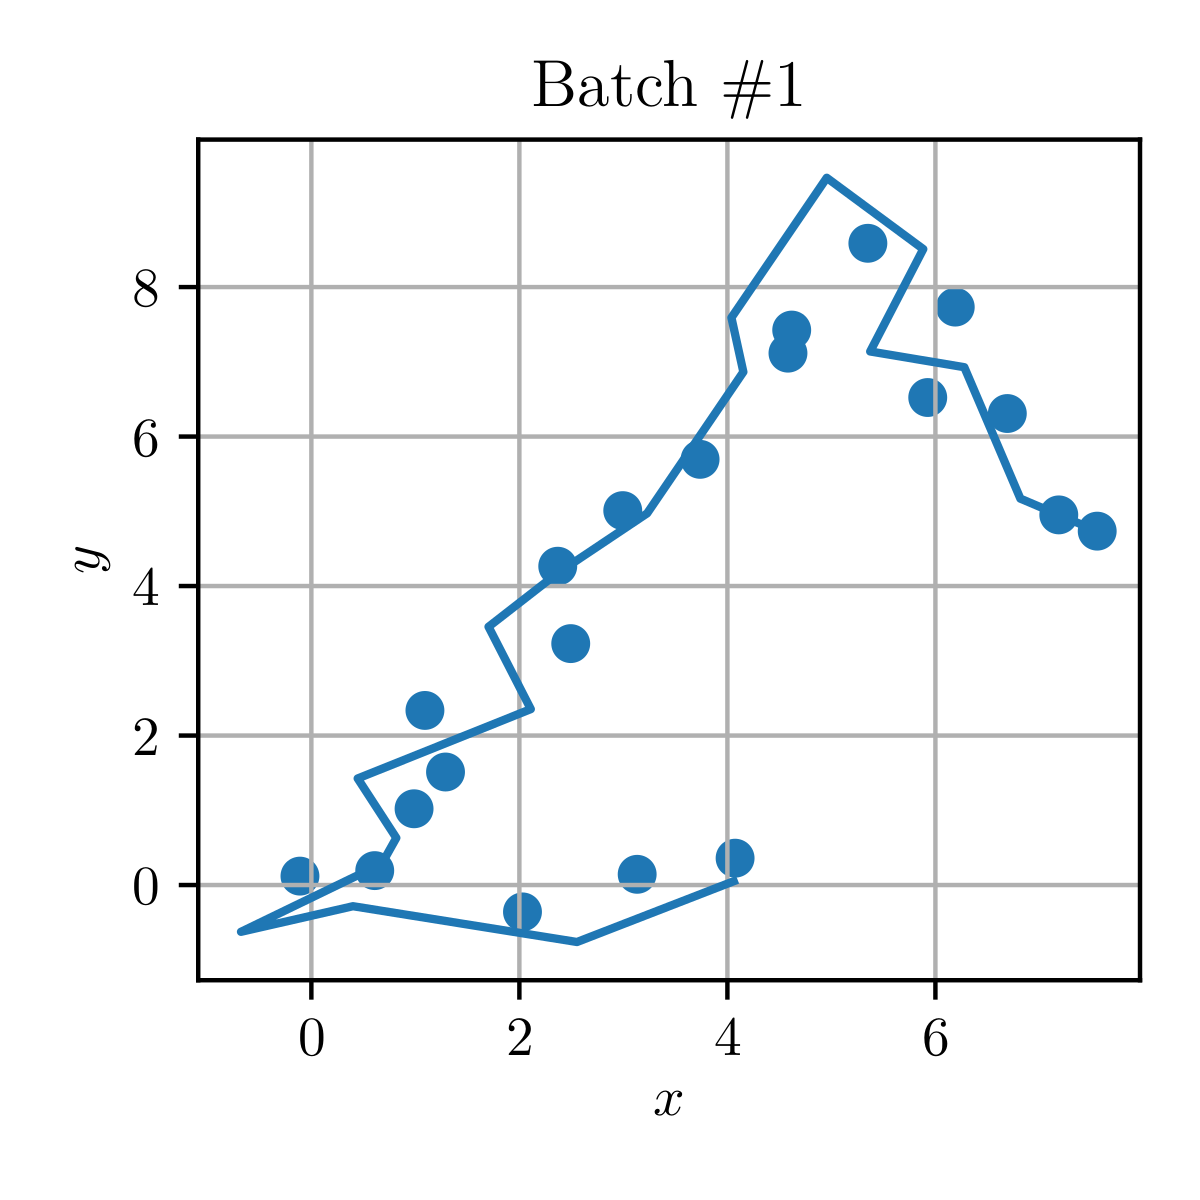
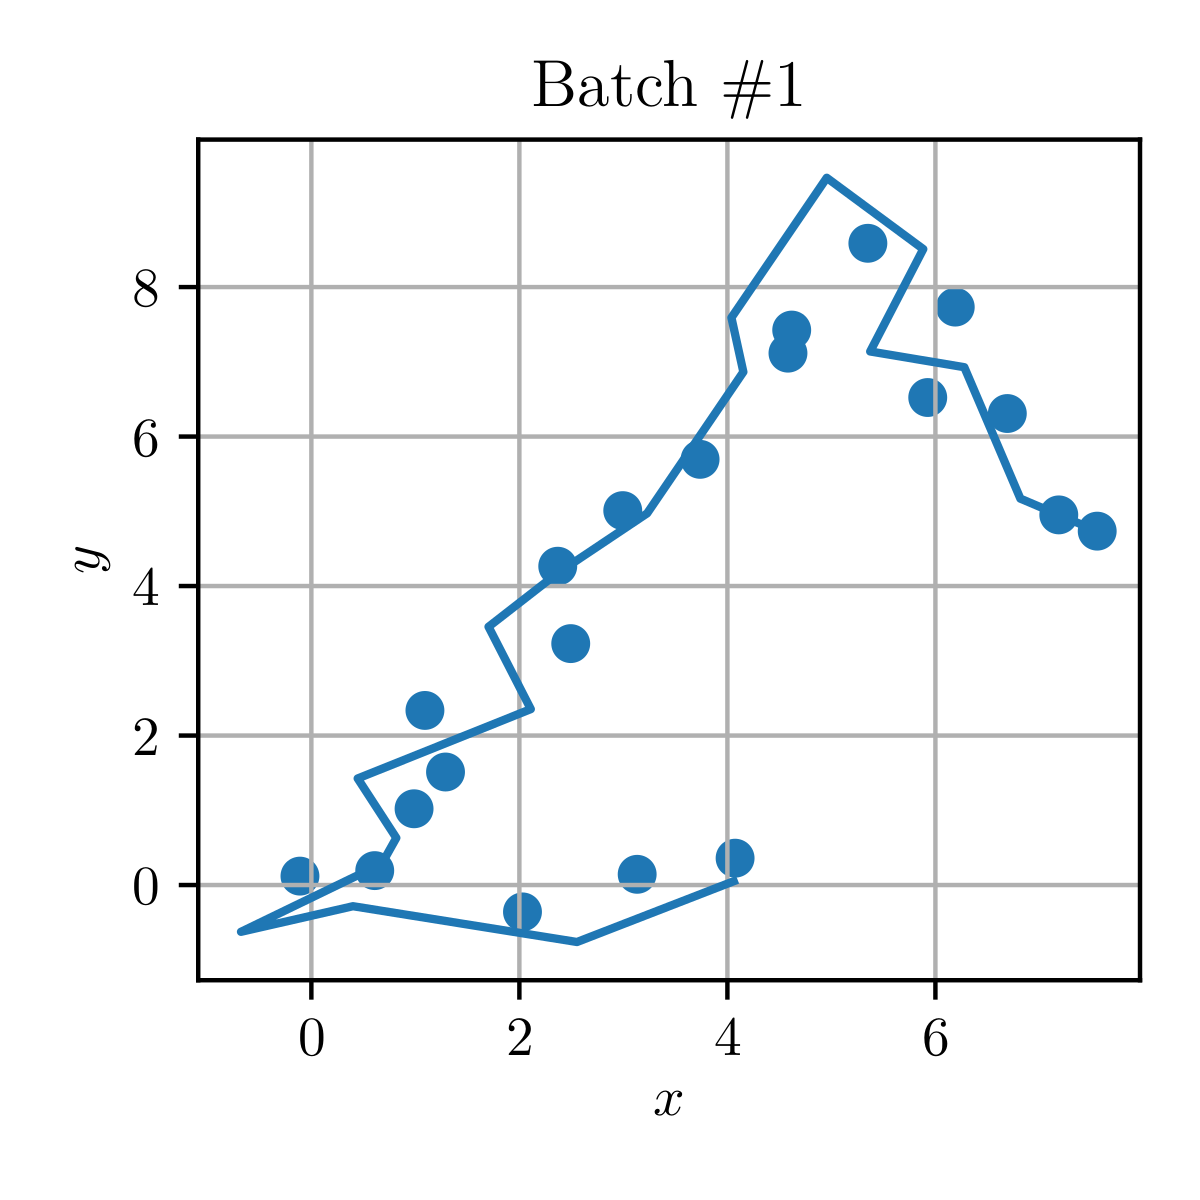
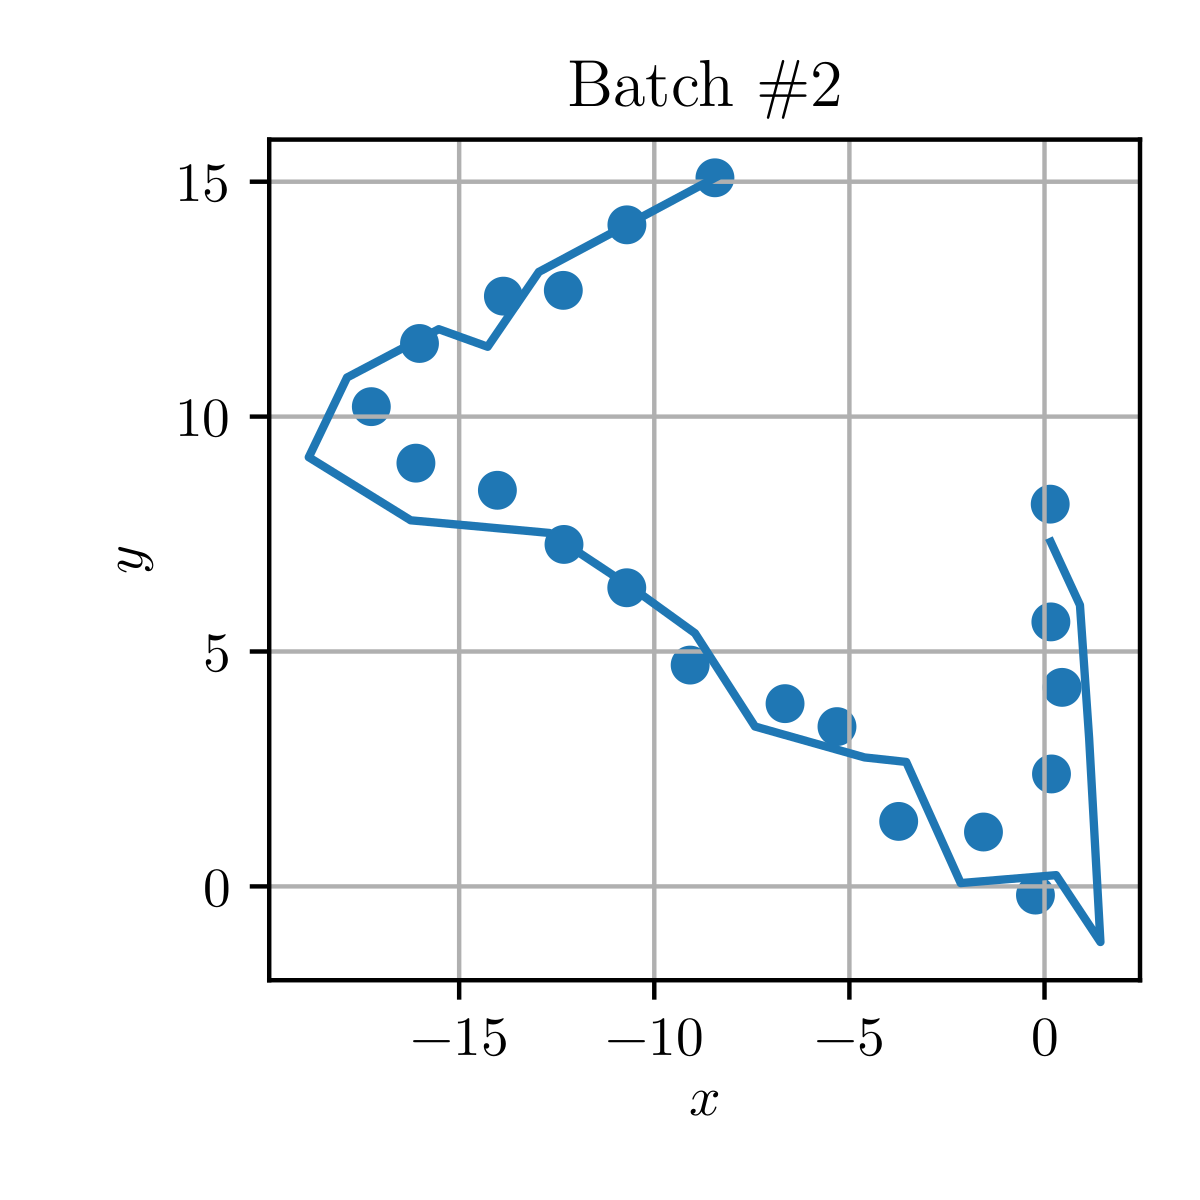
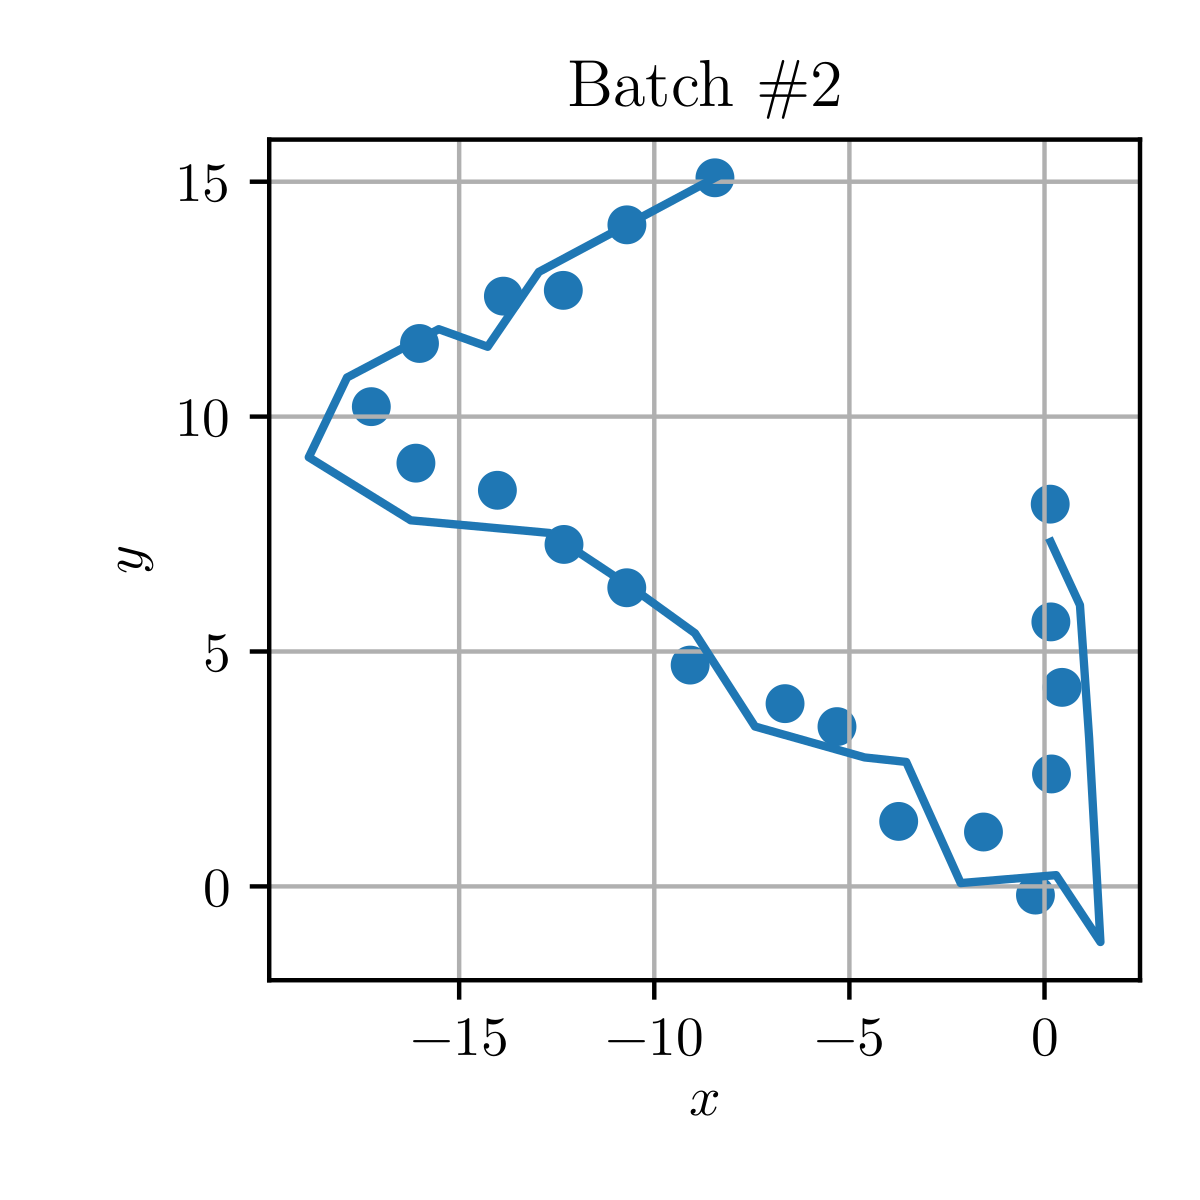
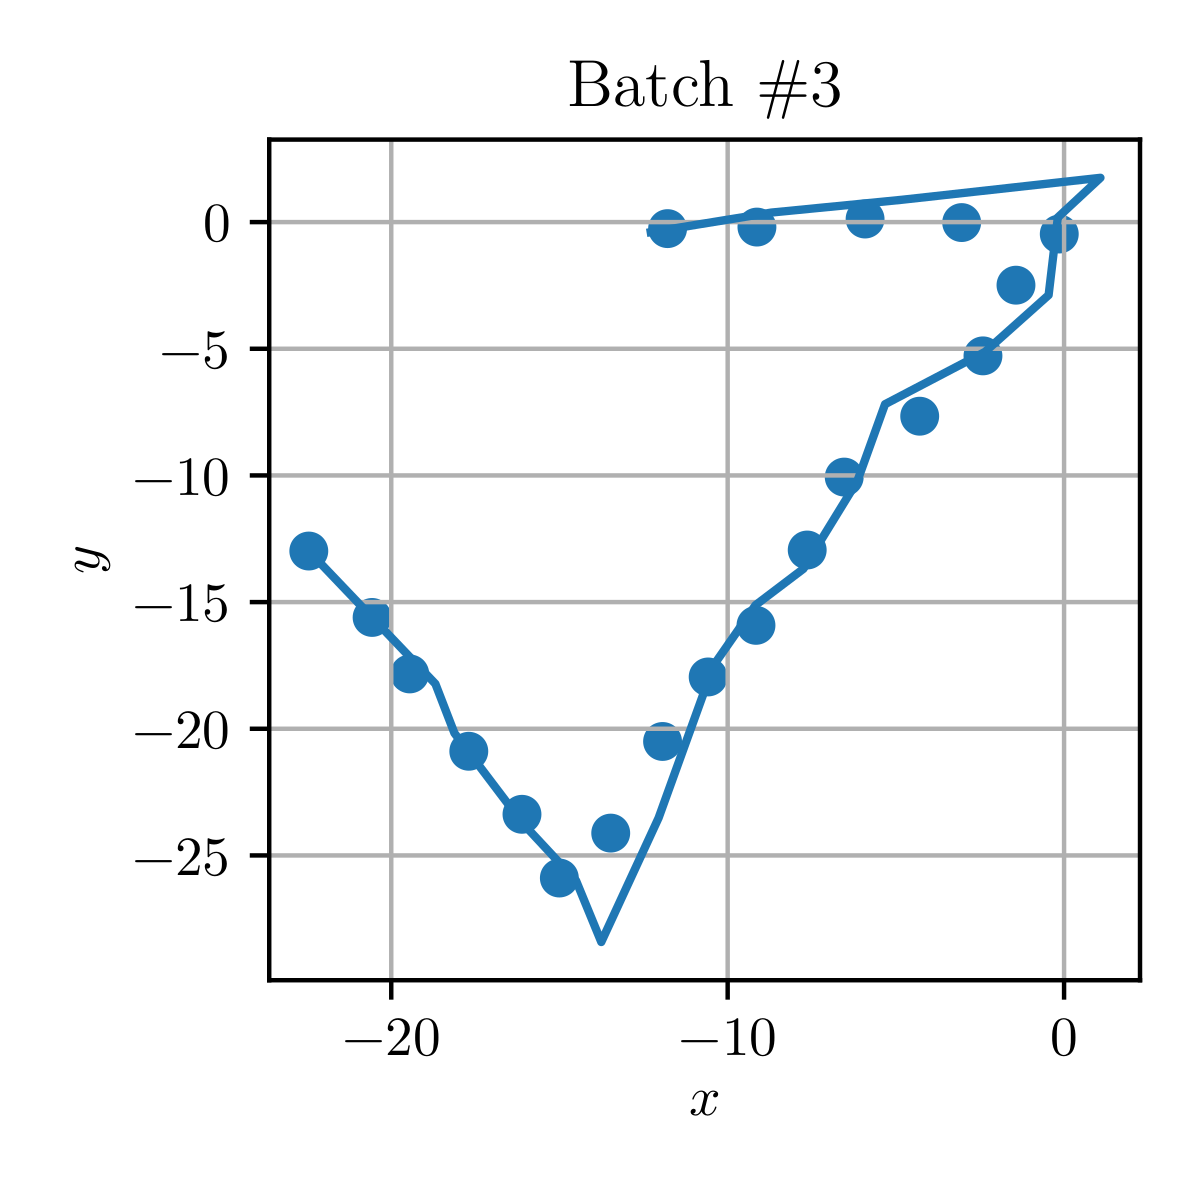
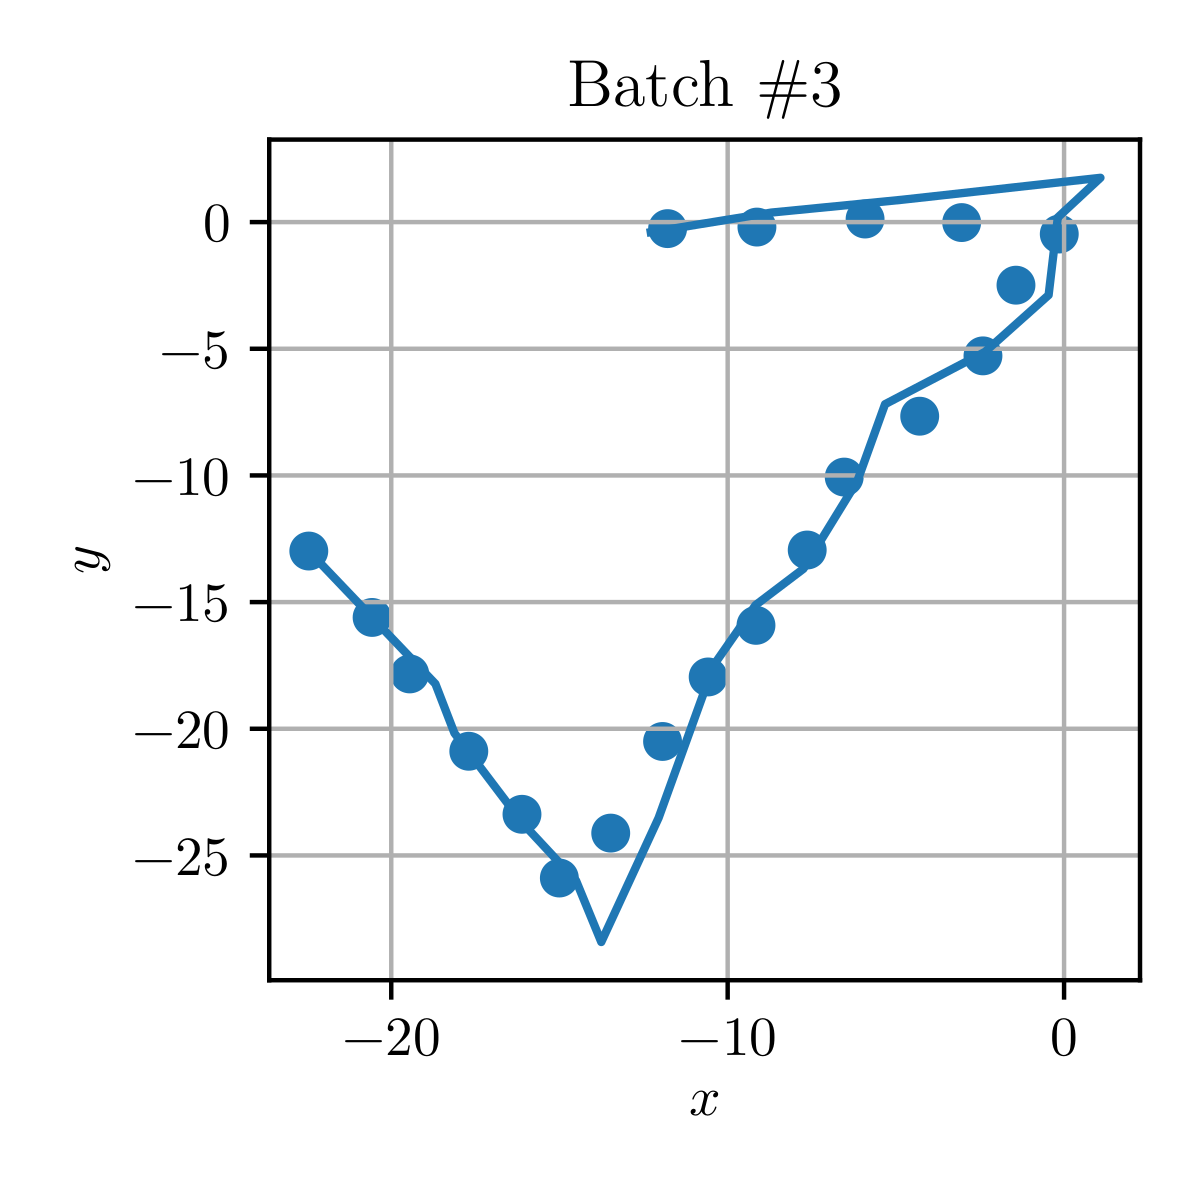
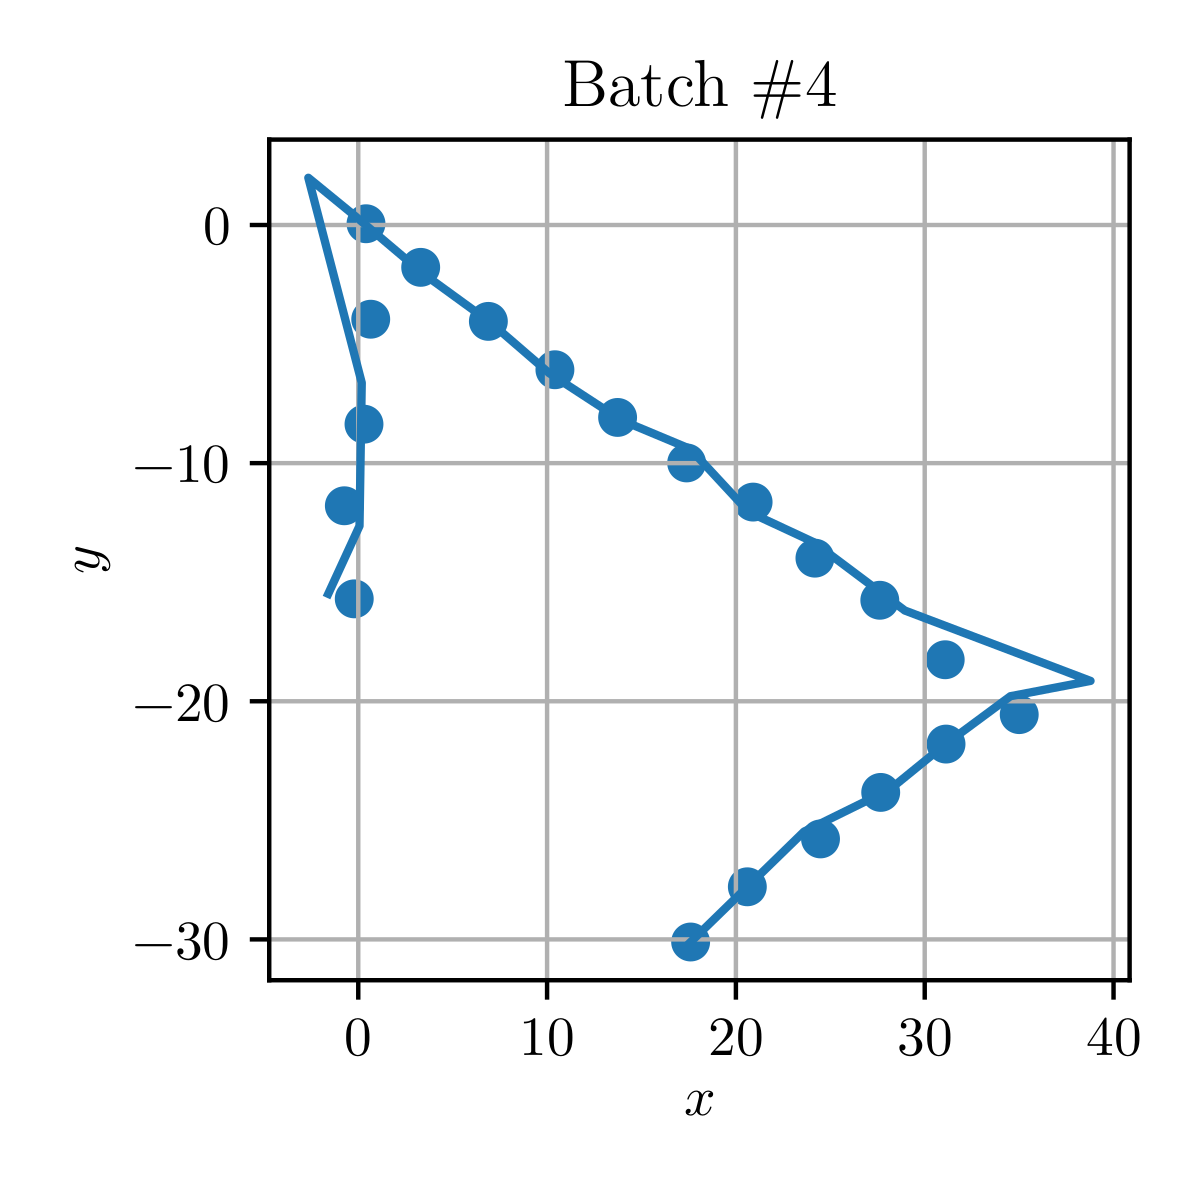
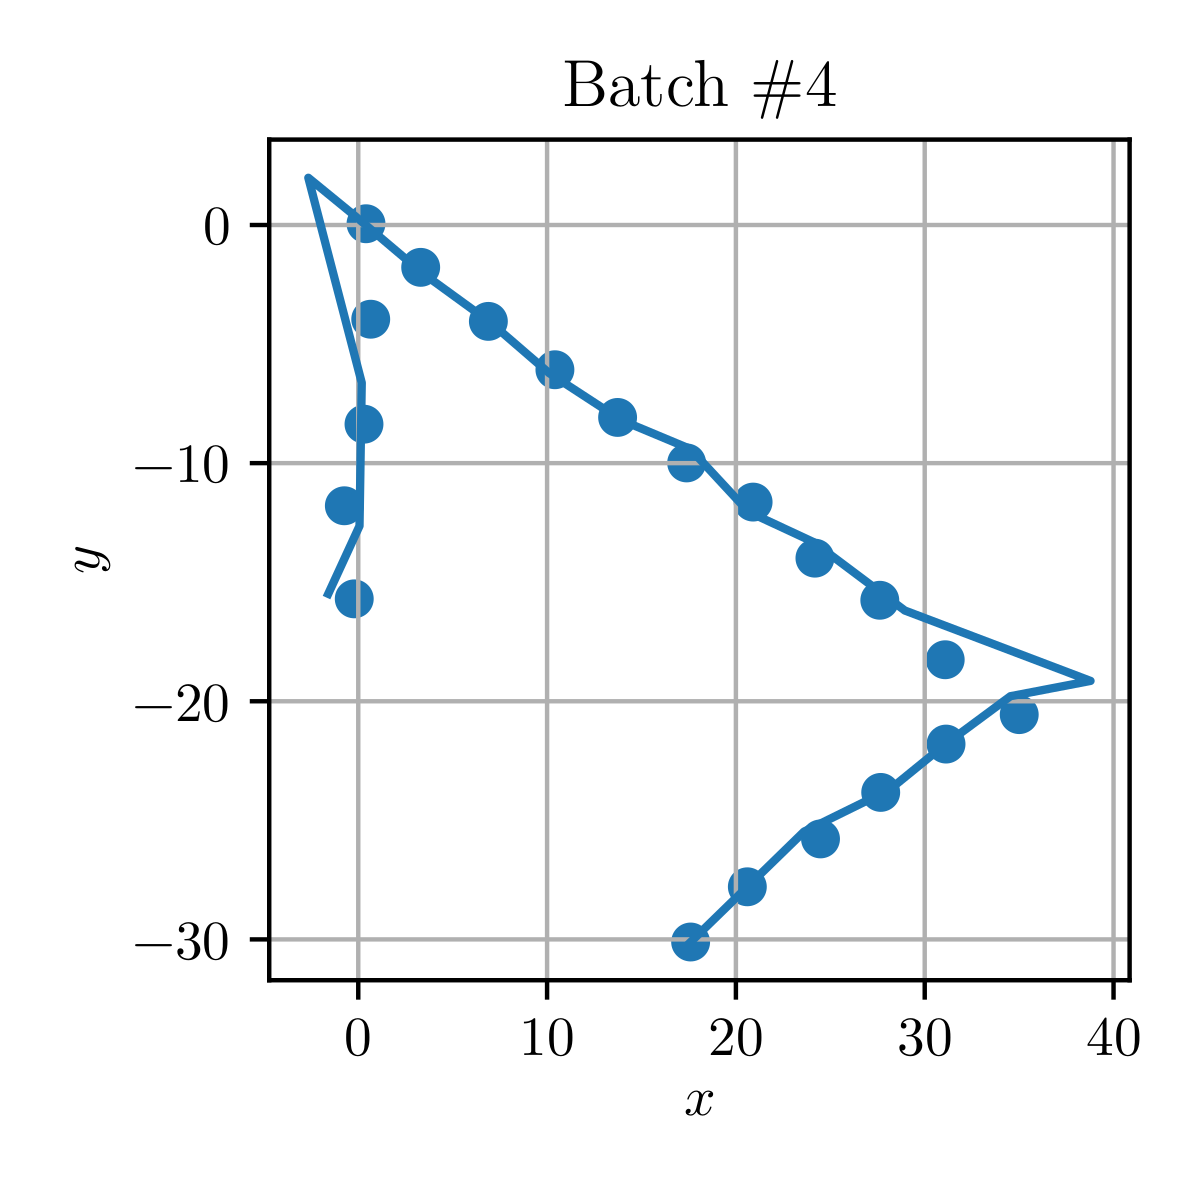

In [13]:
@ftl.with_context
def plot(X_pred, X, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(X_pred[batch_idx, 0], X_pred[batch_idx, 1])
    ax.scatter(X[batch_idx, 0], X[batch_idx, 1])
    ax.grid()
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

n = 20
ftl.img_grid([
    plot(X_pred[:, :, :n], X[:, :, -1, :n], 0, 'pred_b1_train'),
    plot(X_pred[:, :, :n], X[:, :, -1, :n], 1, 'pred_b2_train'),
    plot(X_pred[:, :, :n], X[:, :, -1, :n], 2, 'pred_b3_train'),
    plot(X_pred[:, :, :n], X[:, :, -1, :n], 3, 'pred_b4_train'),
], n_columns=4)


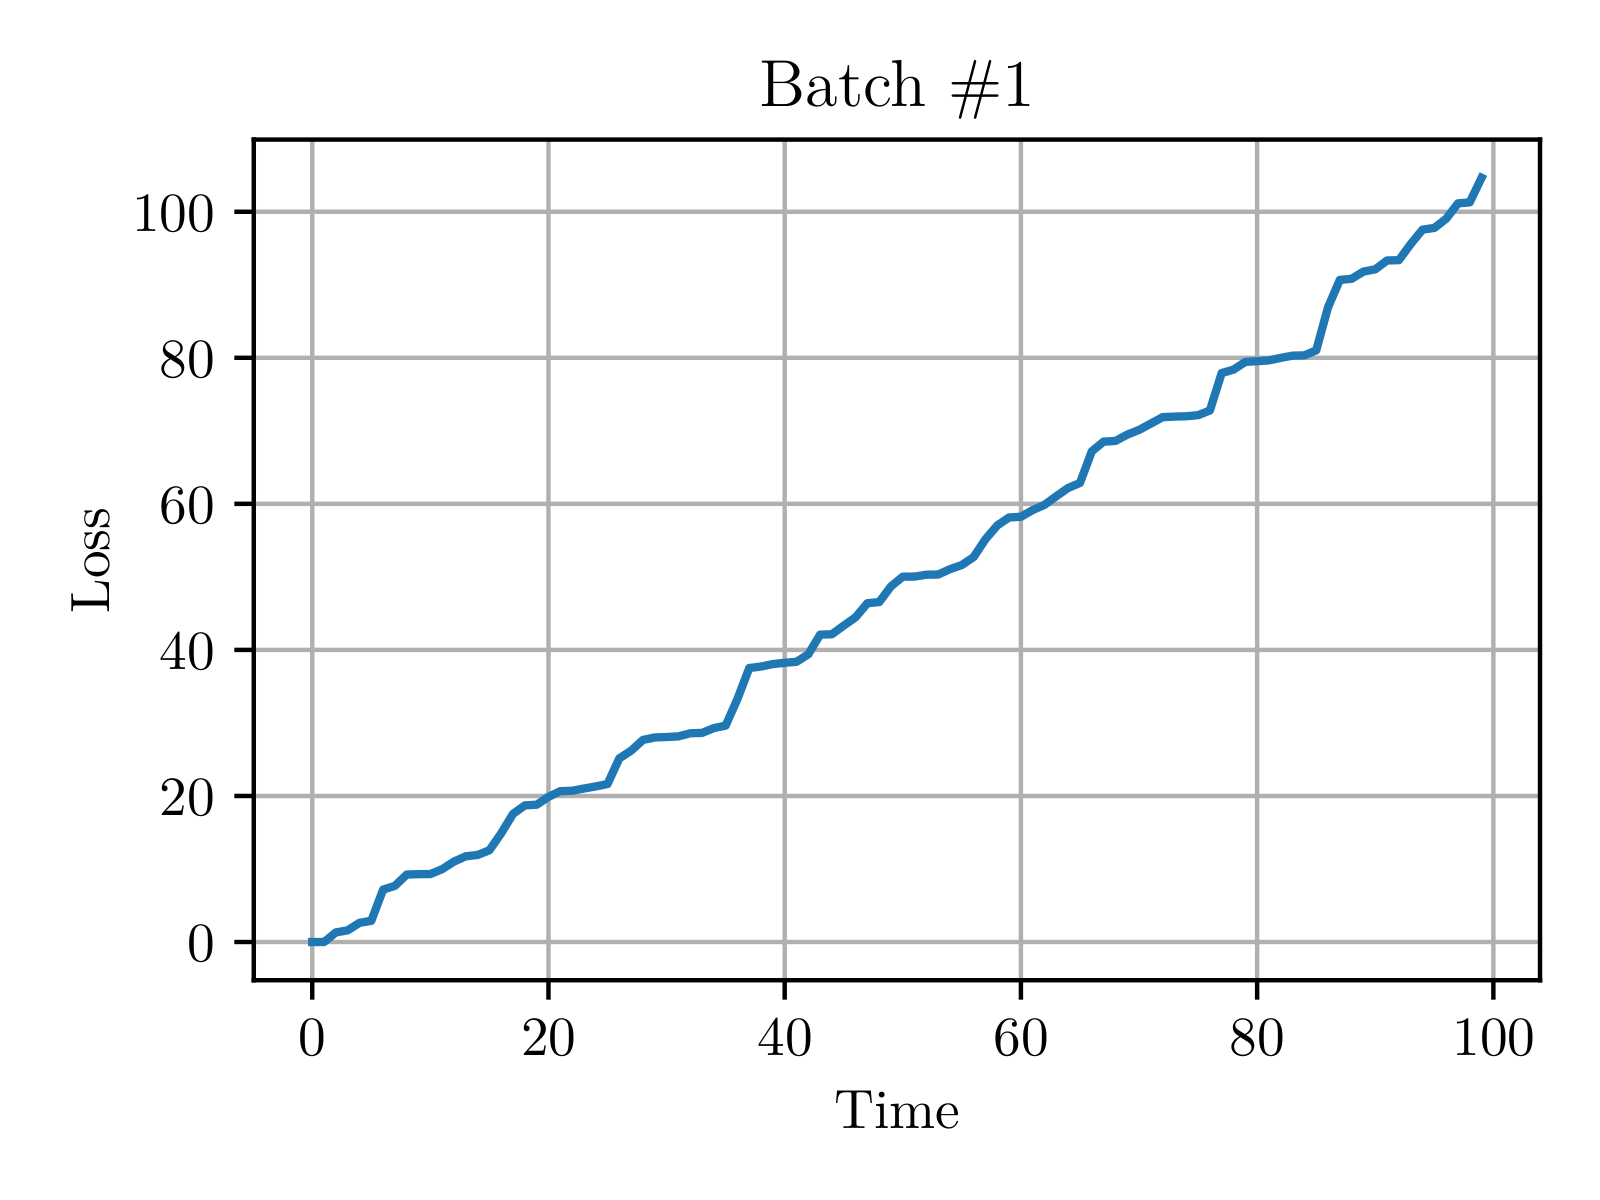
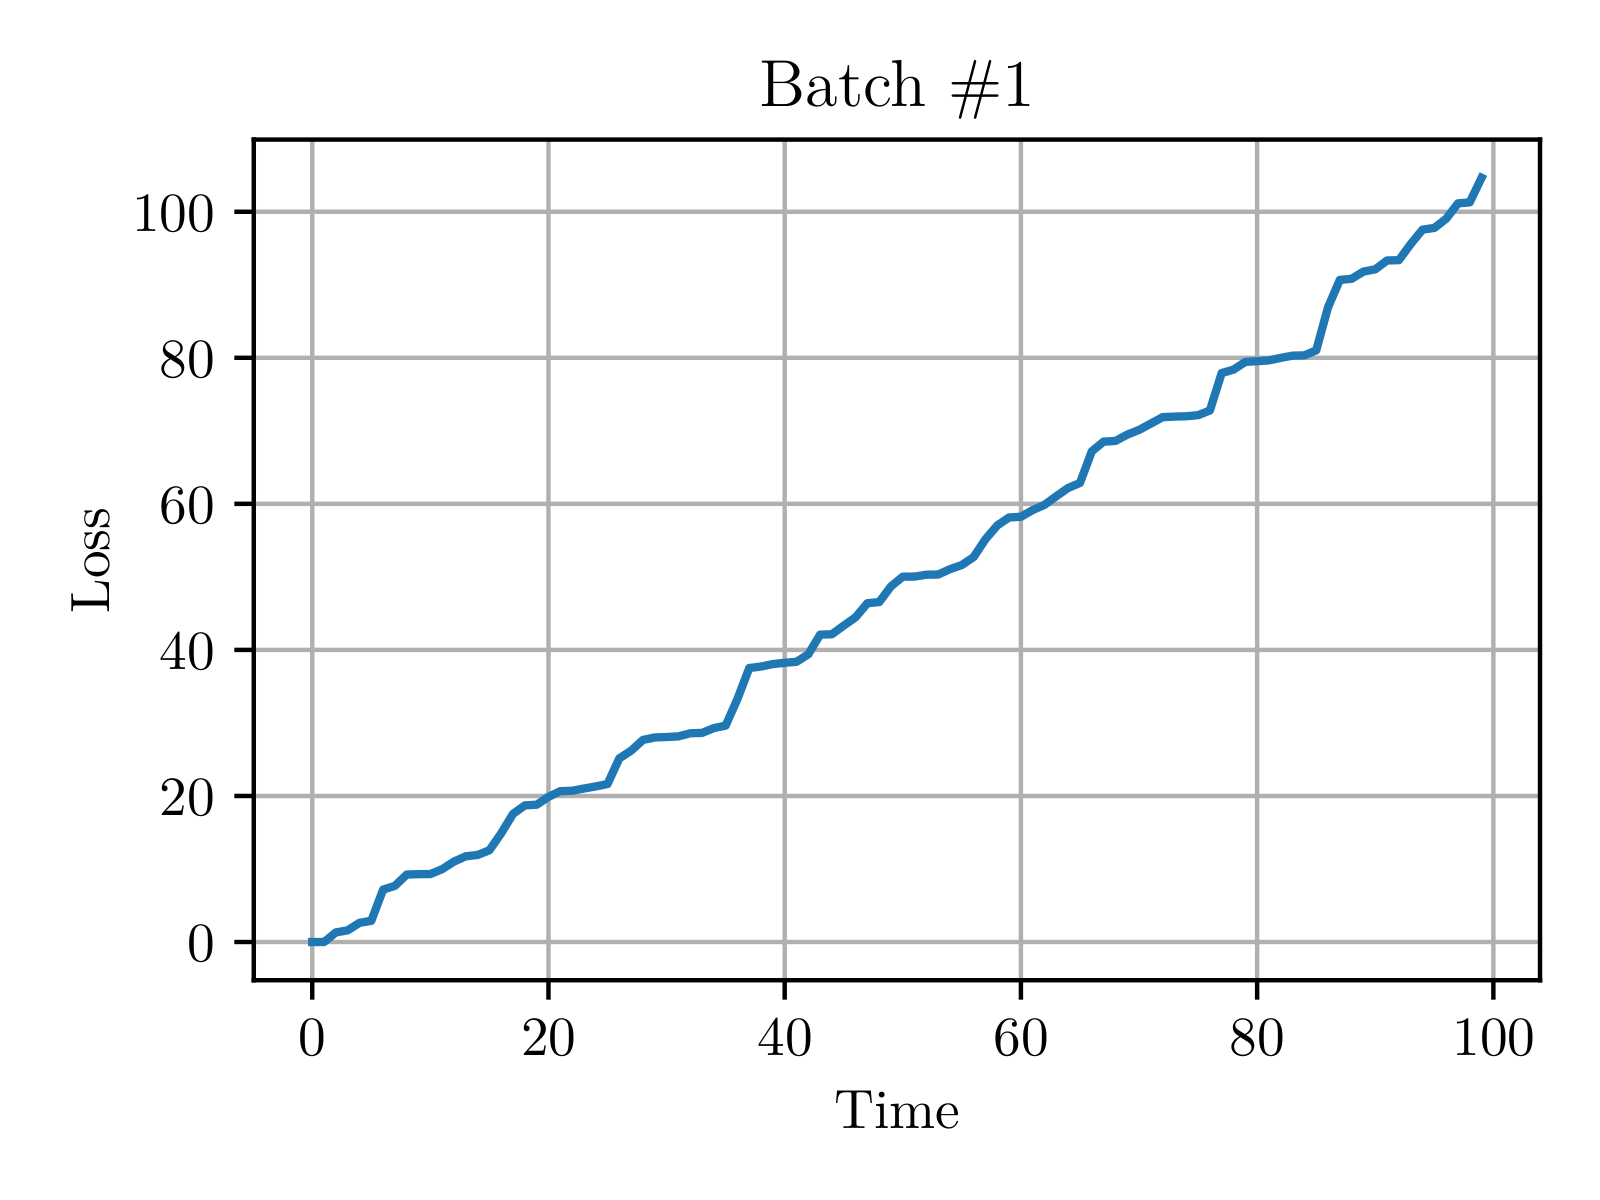
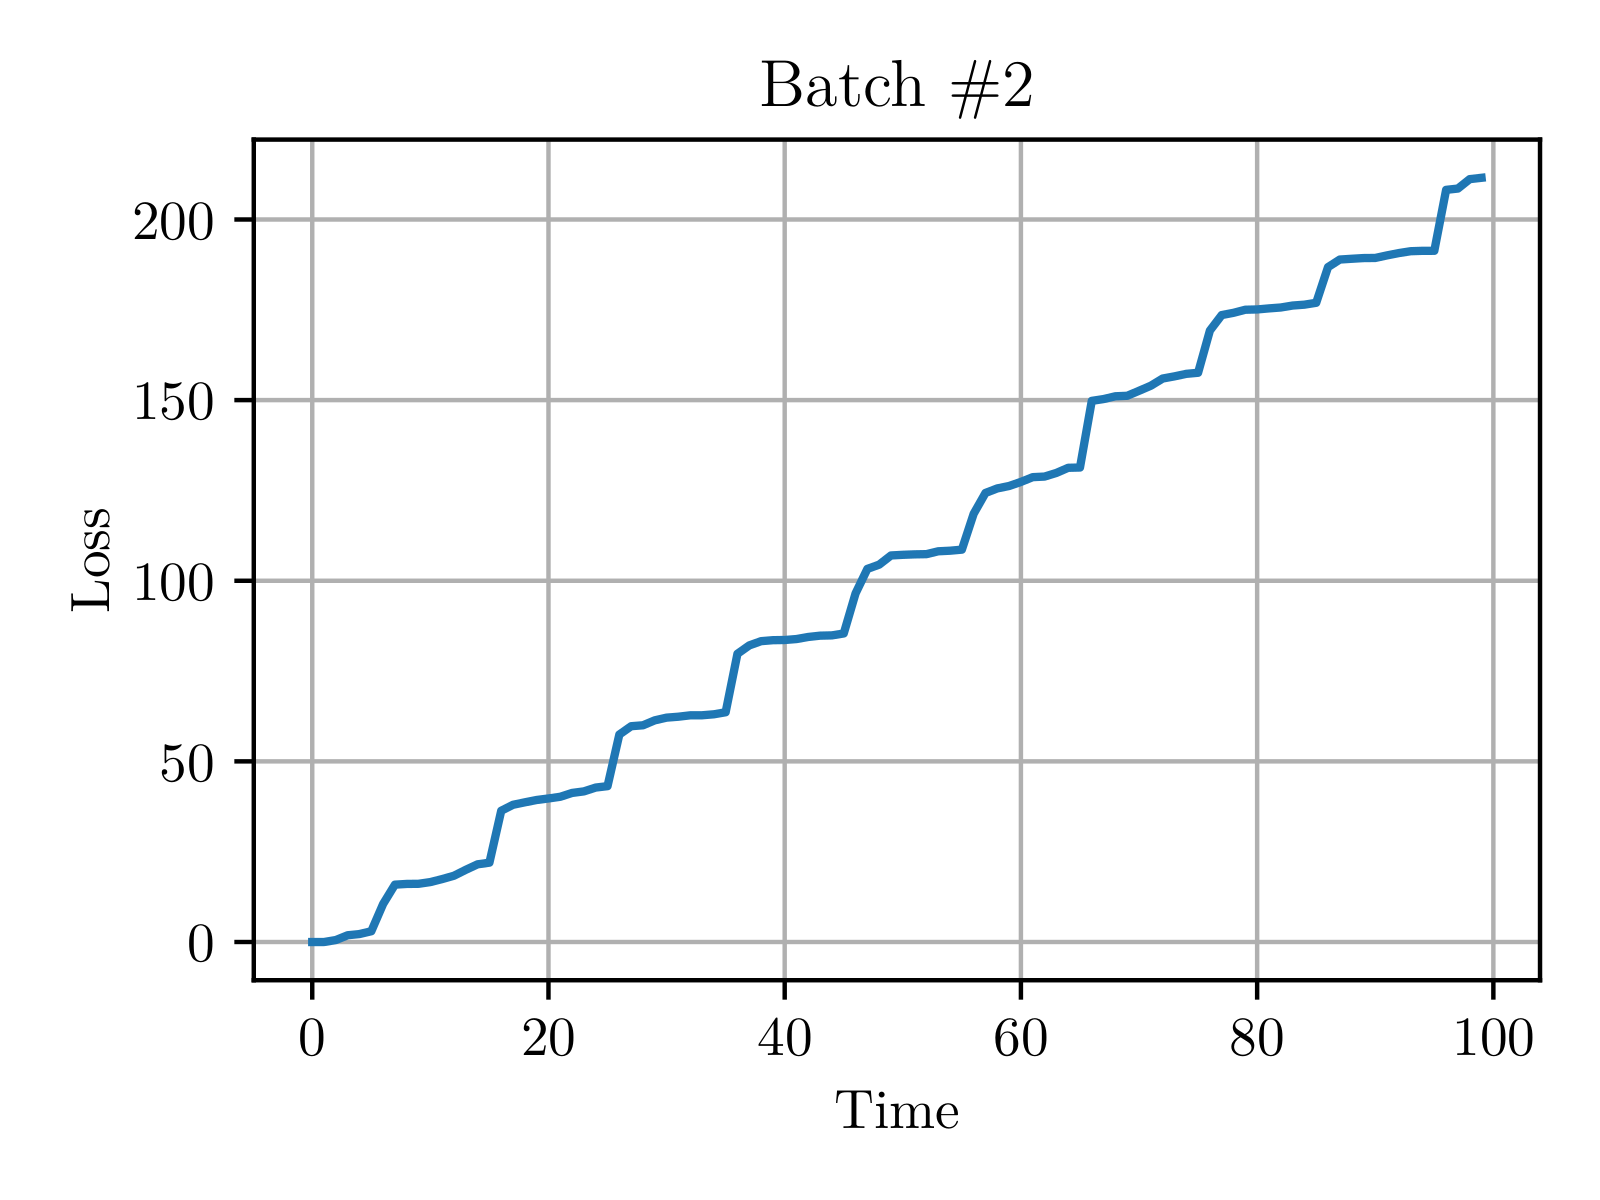
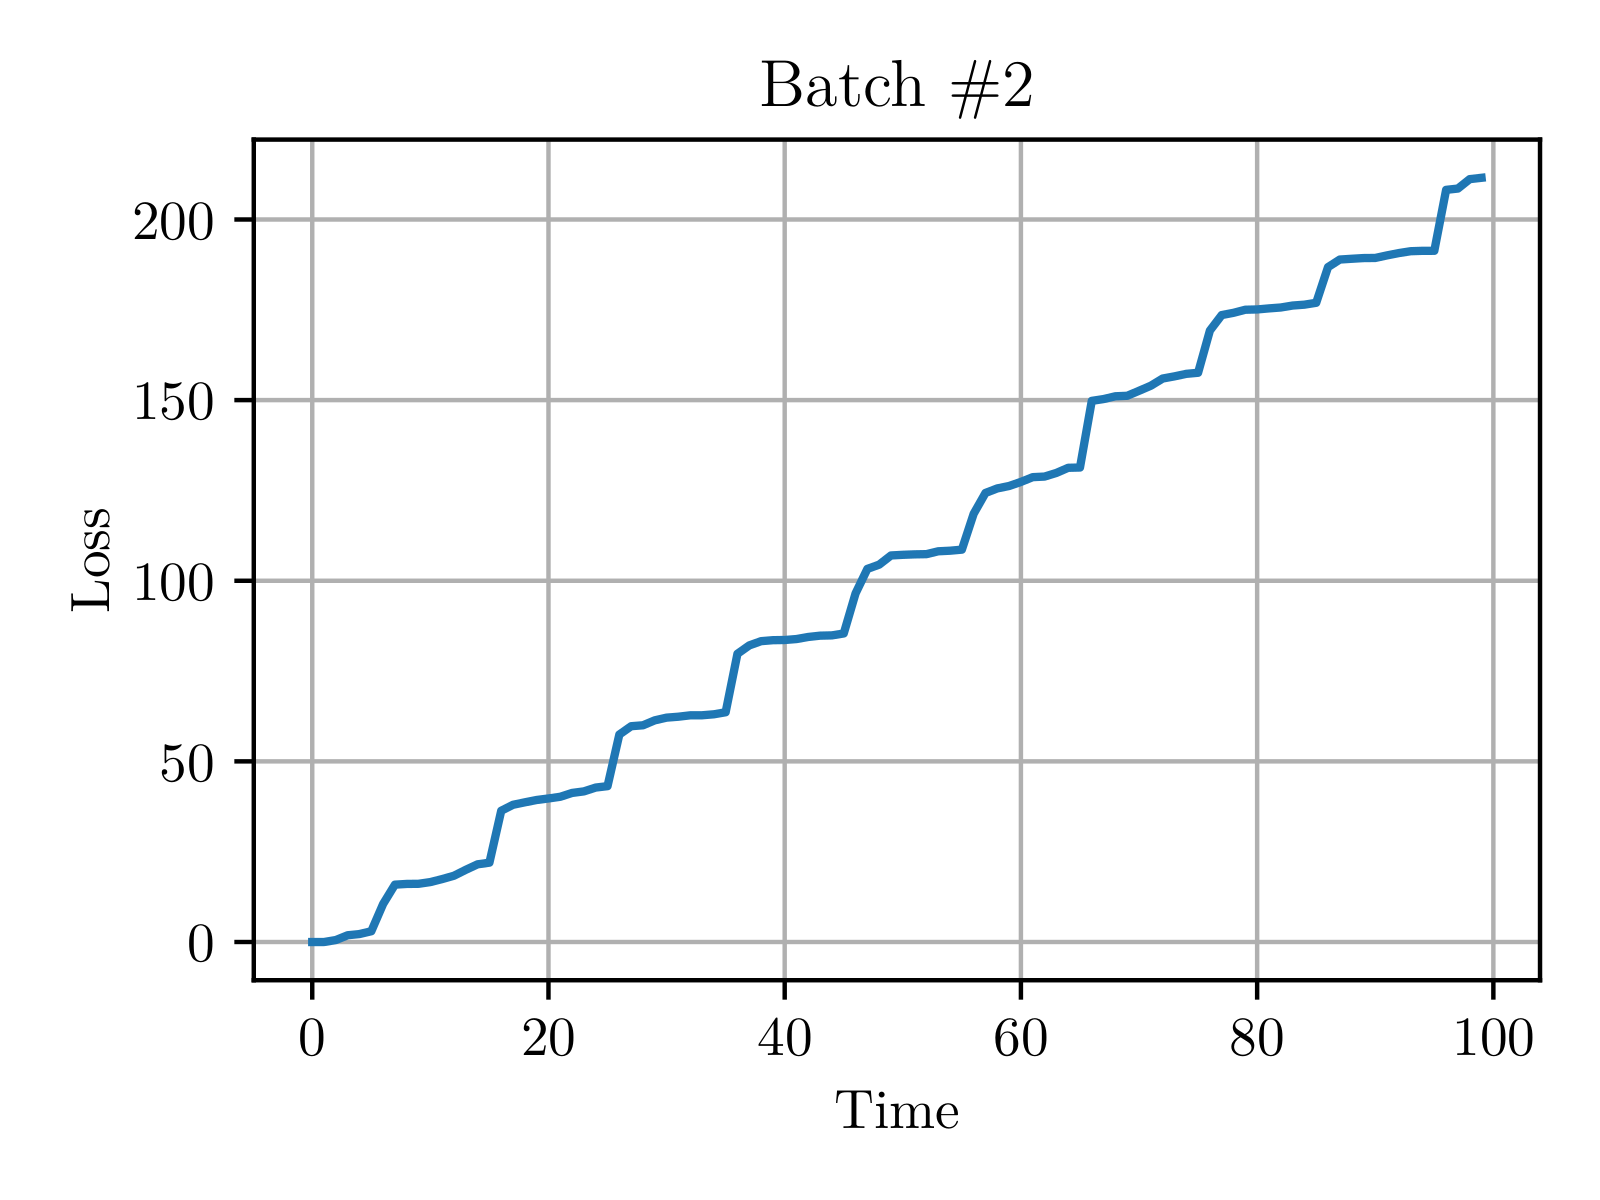
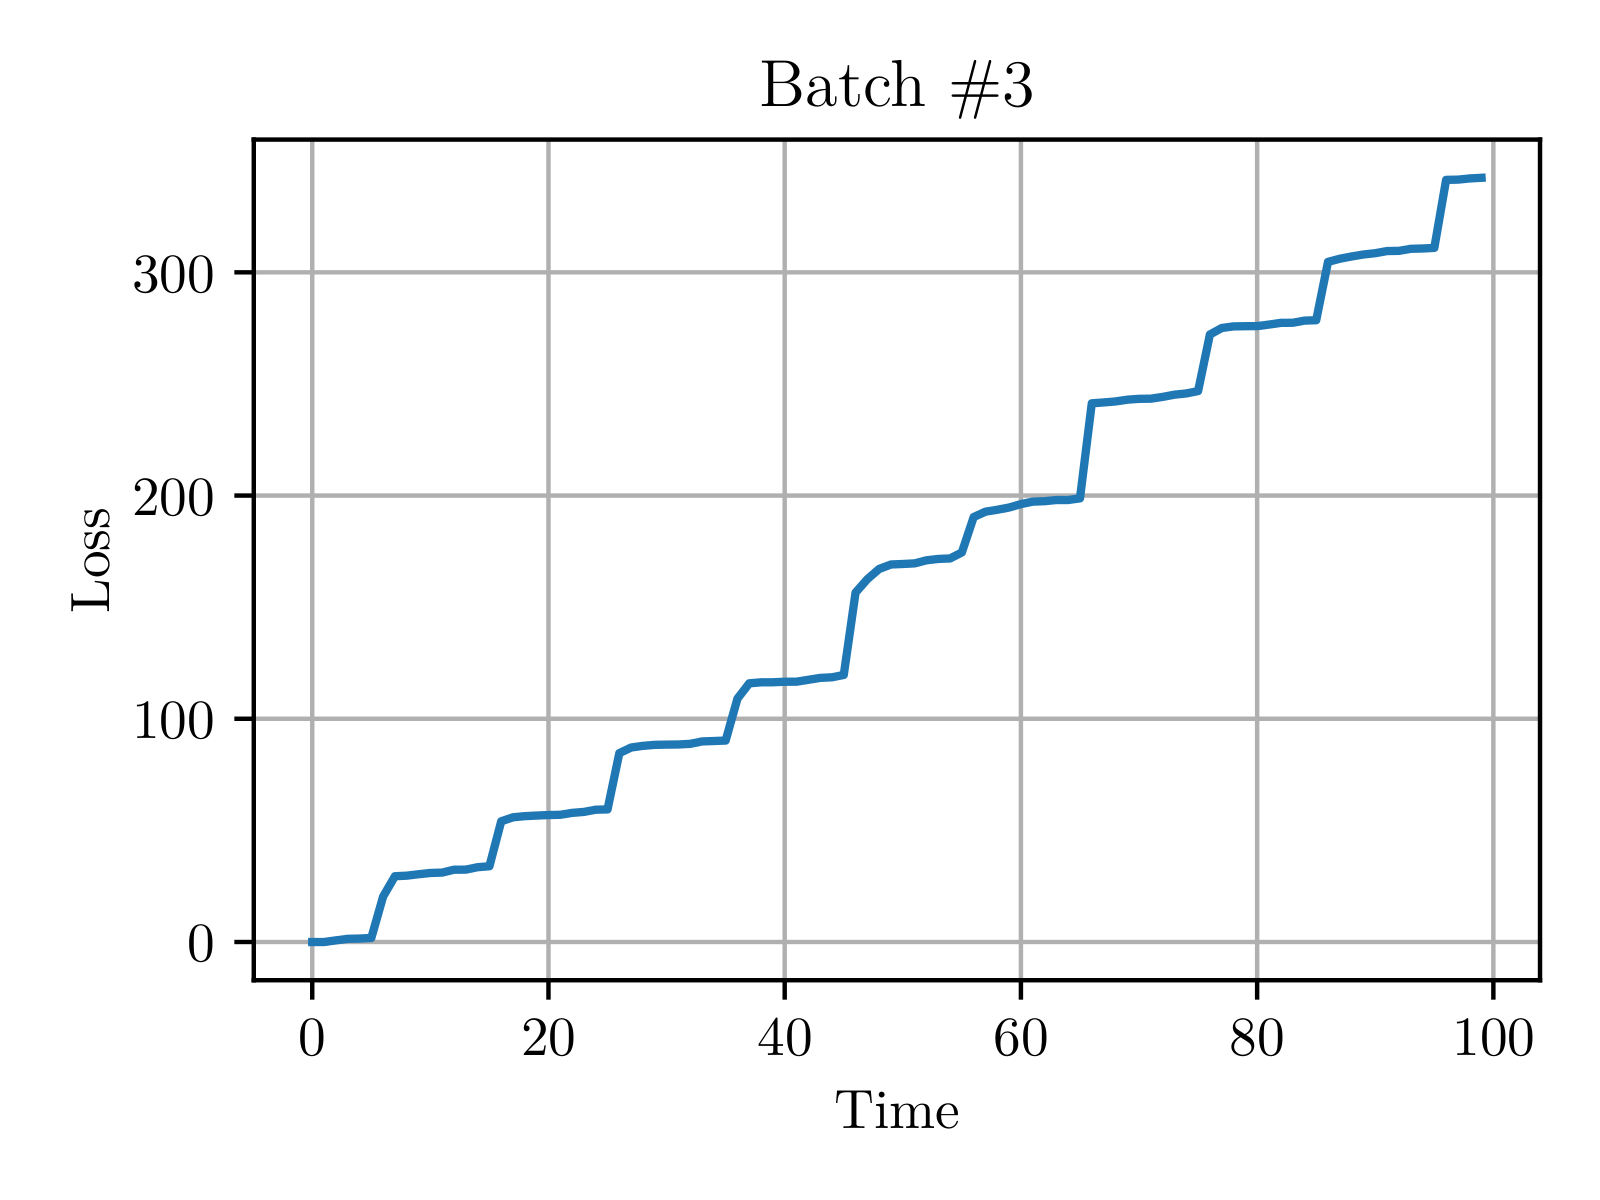
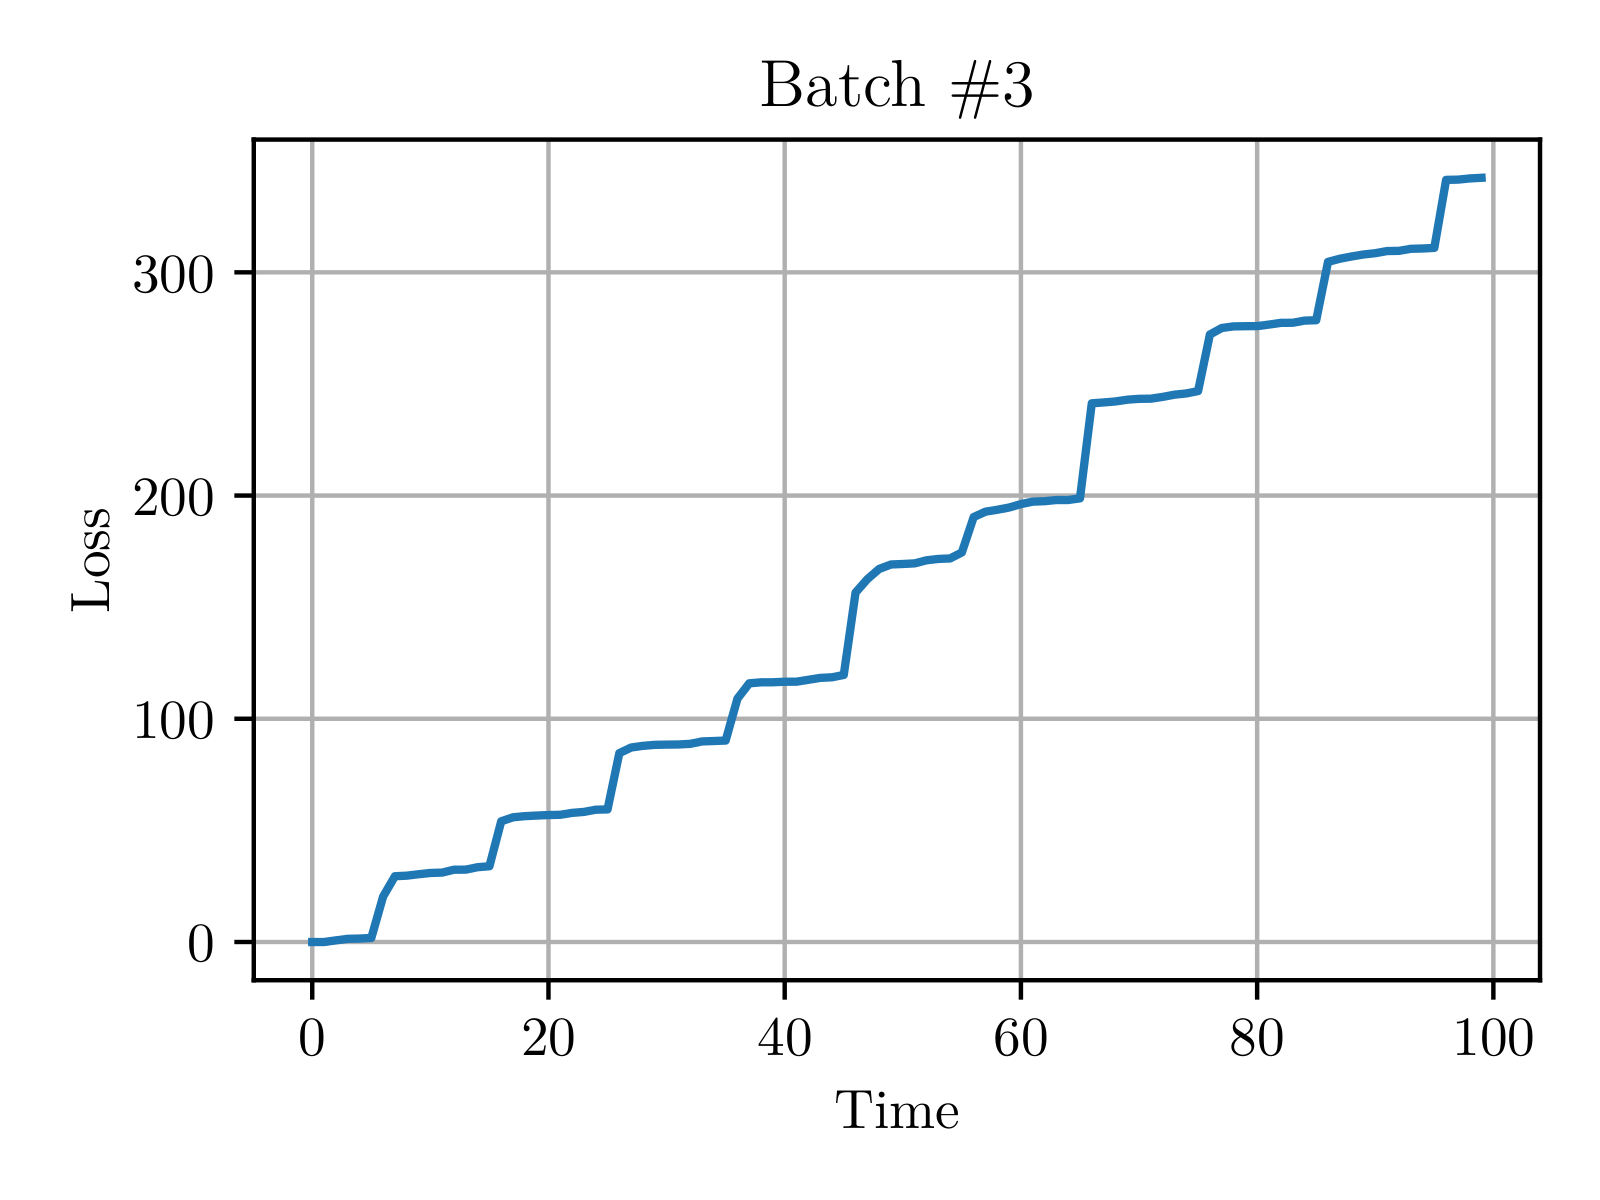
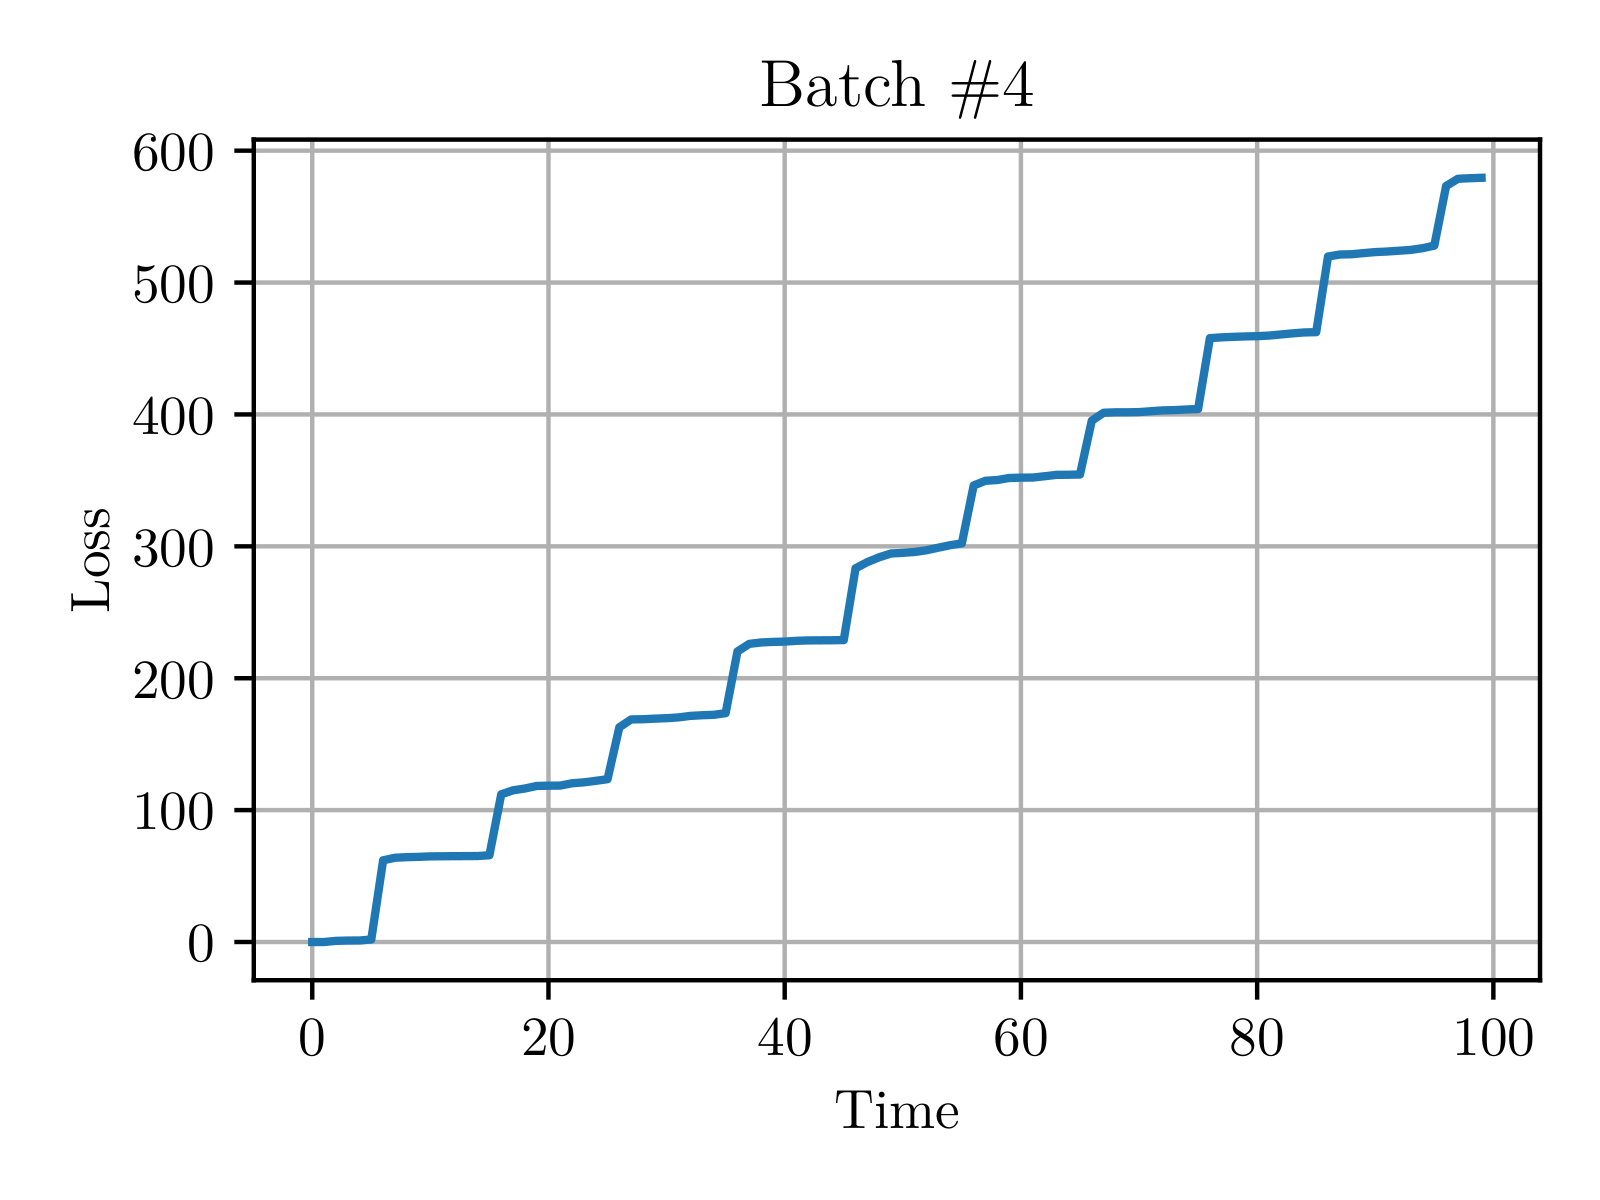
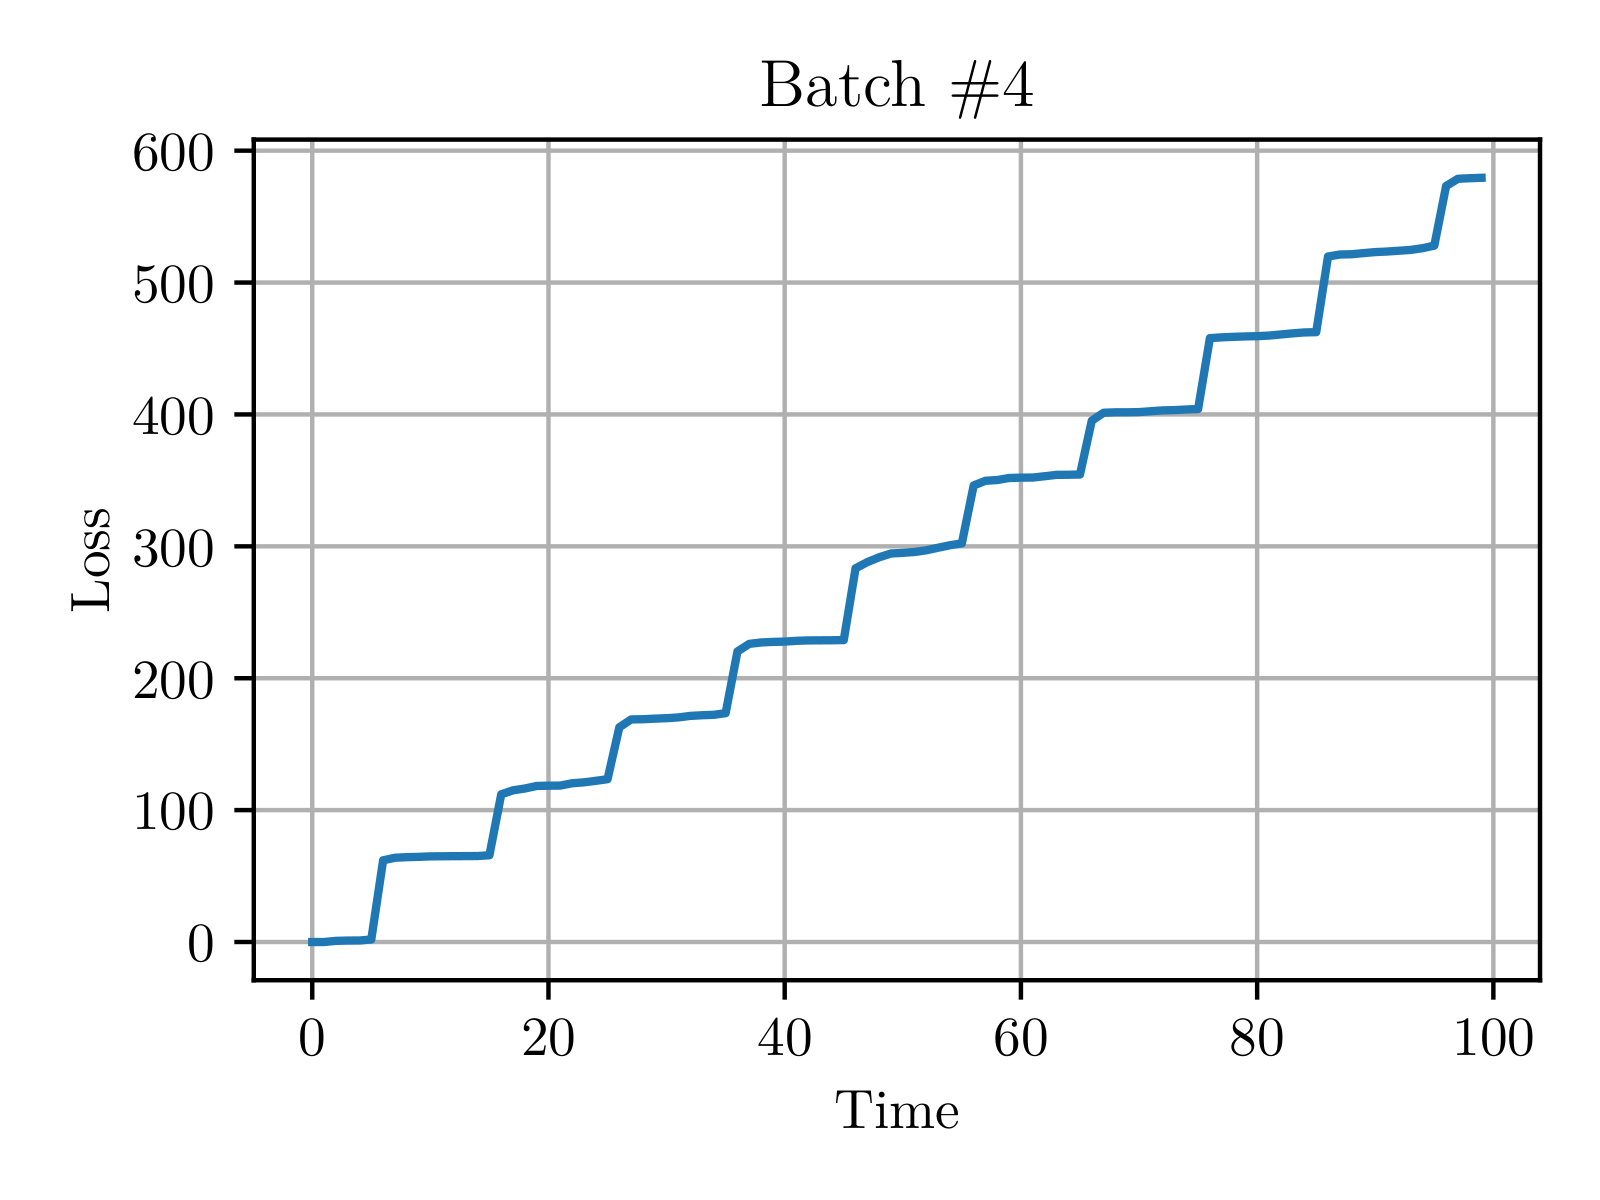

In [14]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X[:, :, -1] - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses, 0, 'loss_b1_train'),
    plot(losses, 1, 'loss_b2_train'),
    plot(losses, 2, 'loss_b3_train'),
    plot(losses, 3, 'loss_b4_train'),
], n_columns=4)

In [15]:
X, _ = data_loader()

In [16]:
X_pred, states = evaluate(X, state_cov=state_cov, process_noise=process_noise, measurement_noise=measurement_noise)
X_pred.shape, states.shape

(torch.Size([4, 2, 210]), torch.Size([4, 4, 210]))


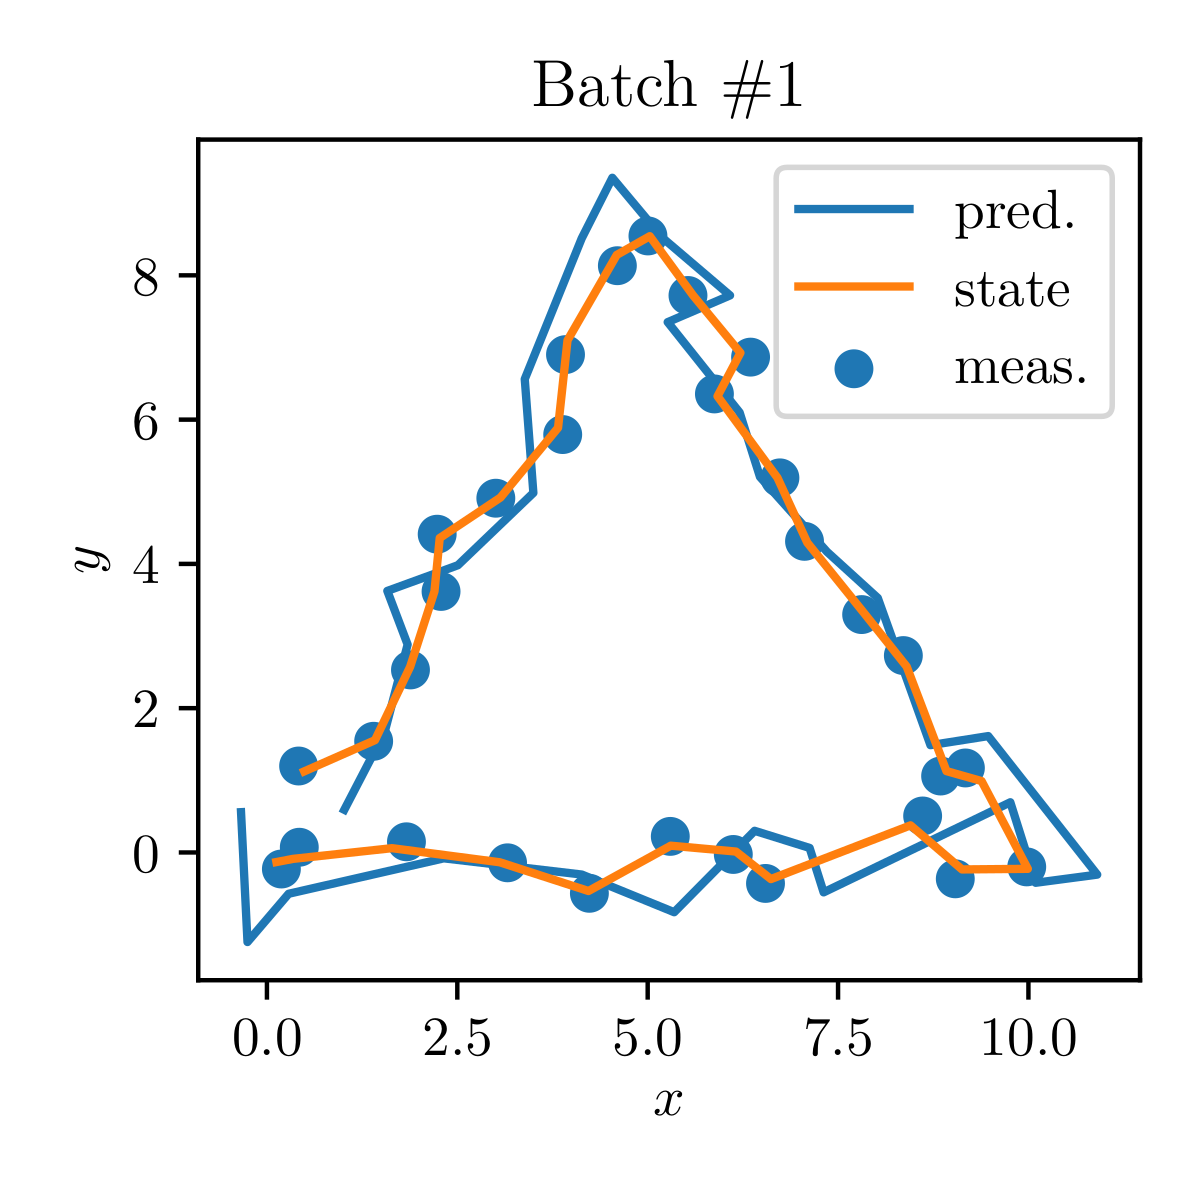
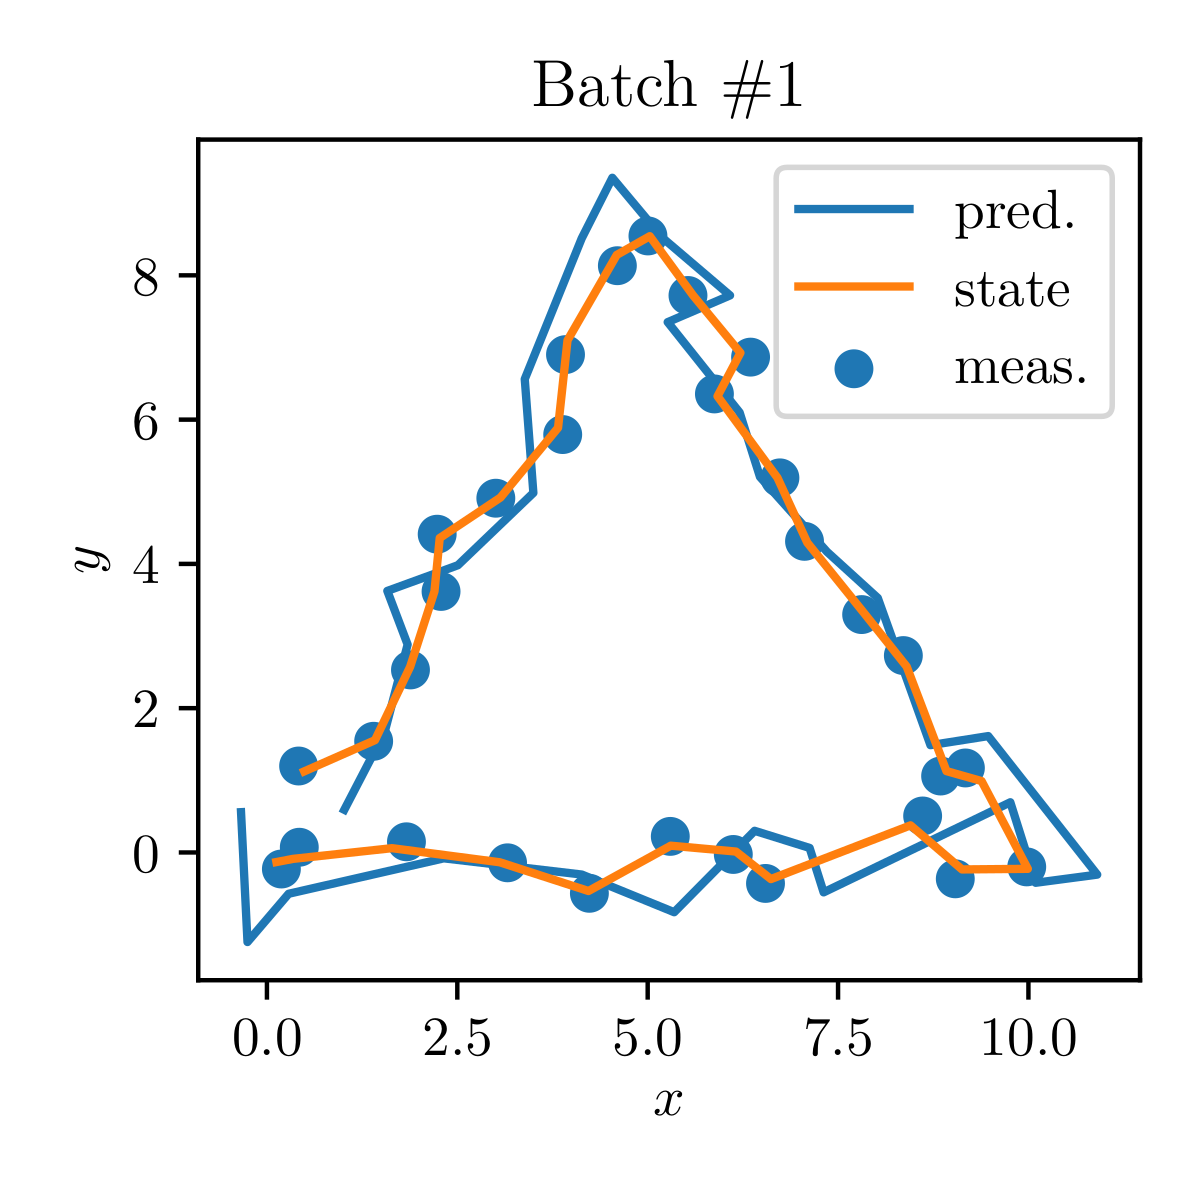
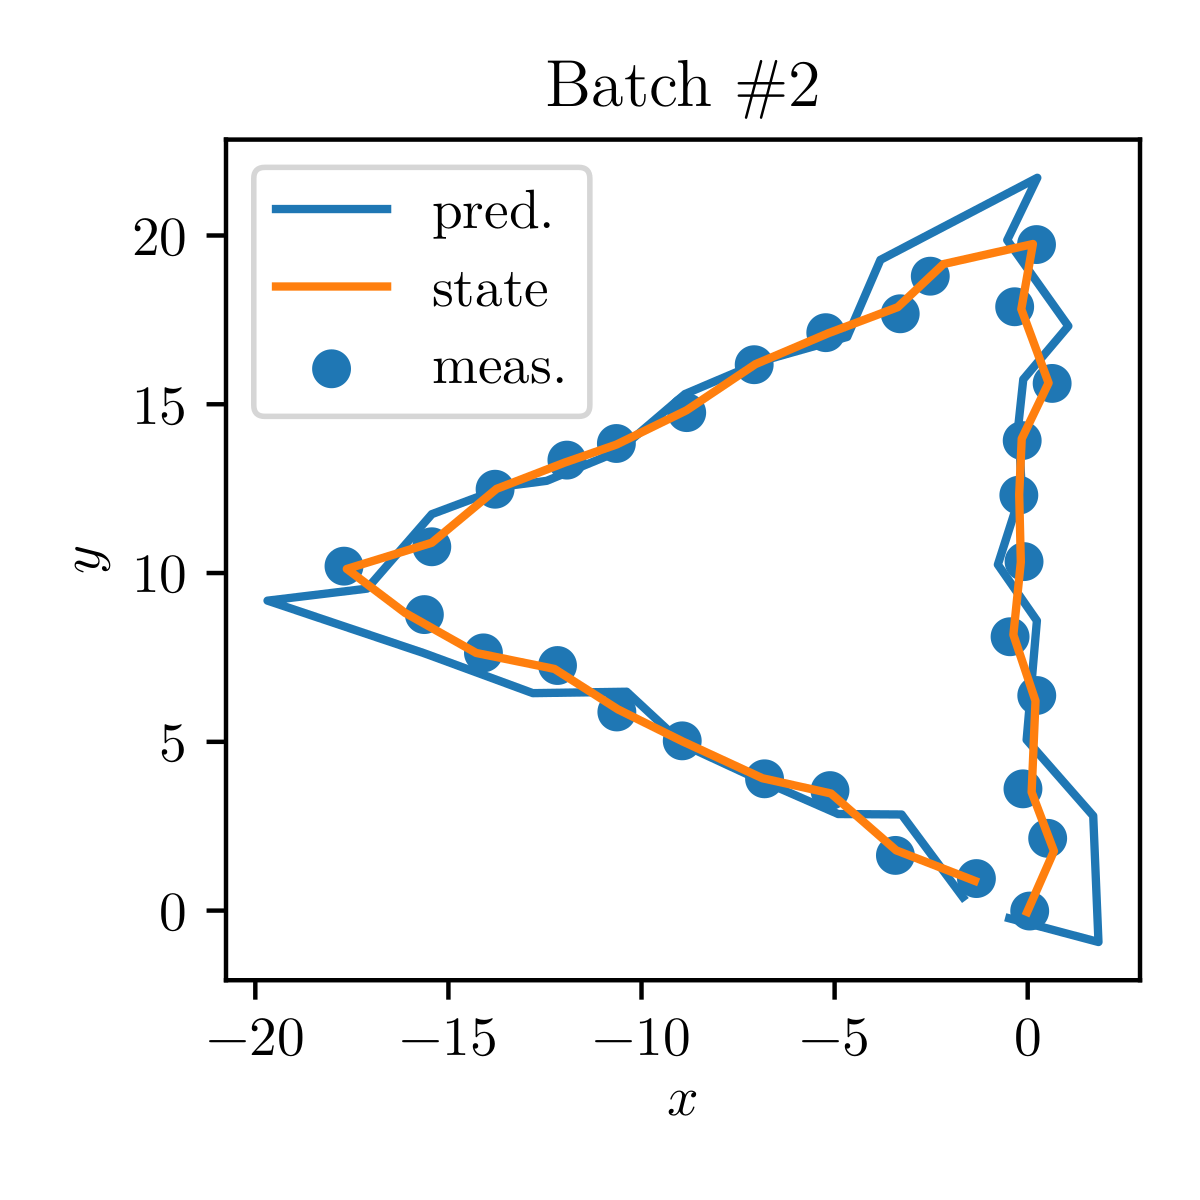
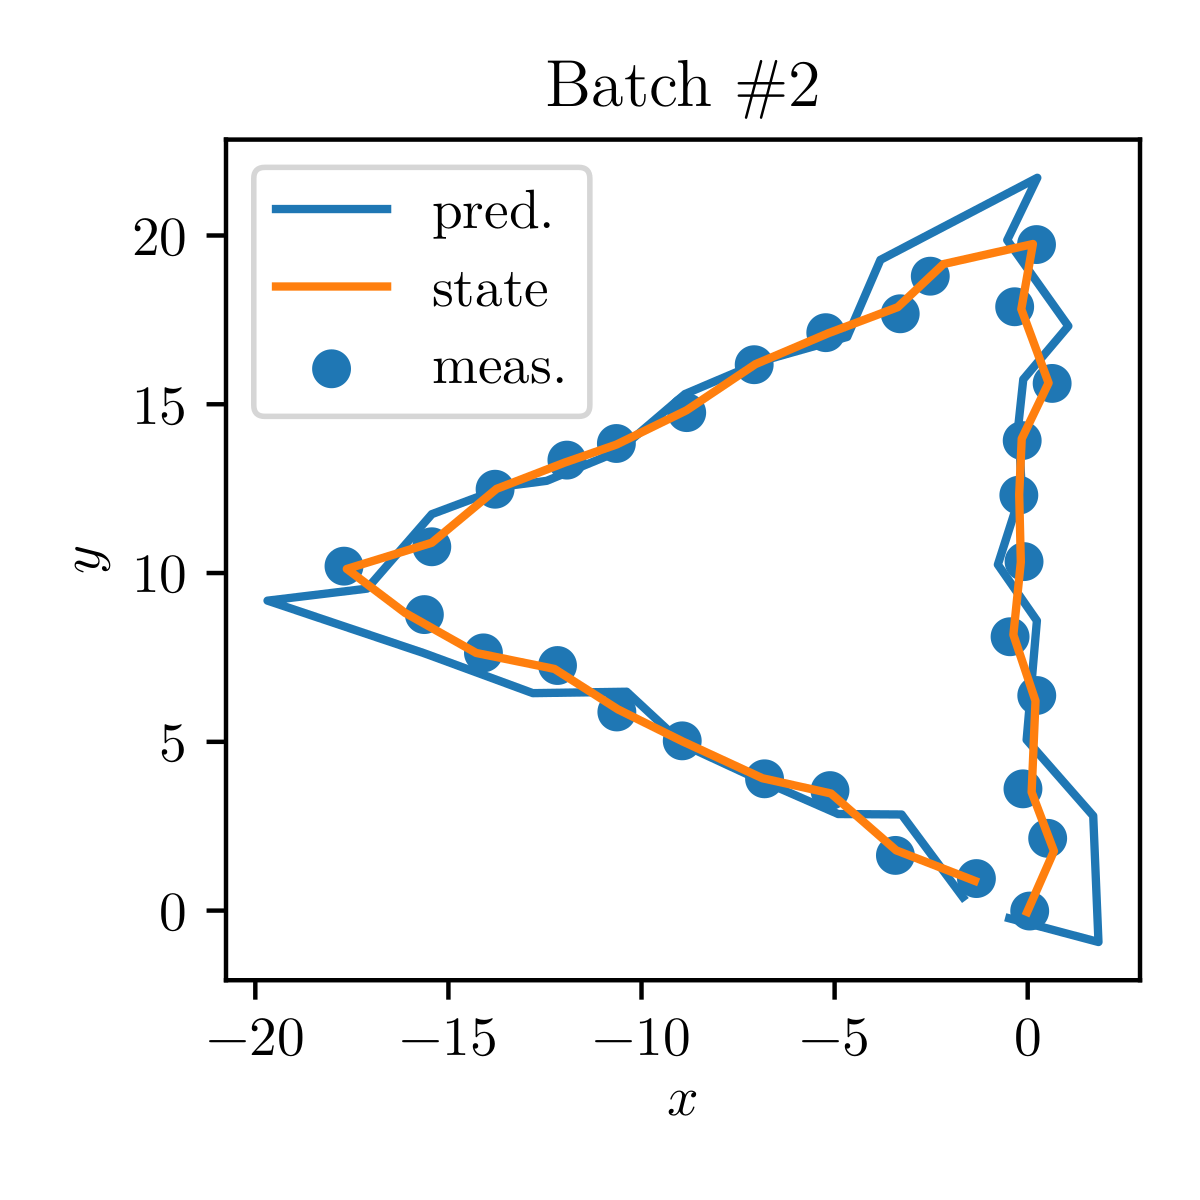
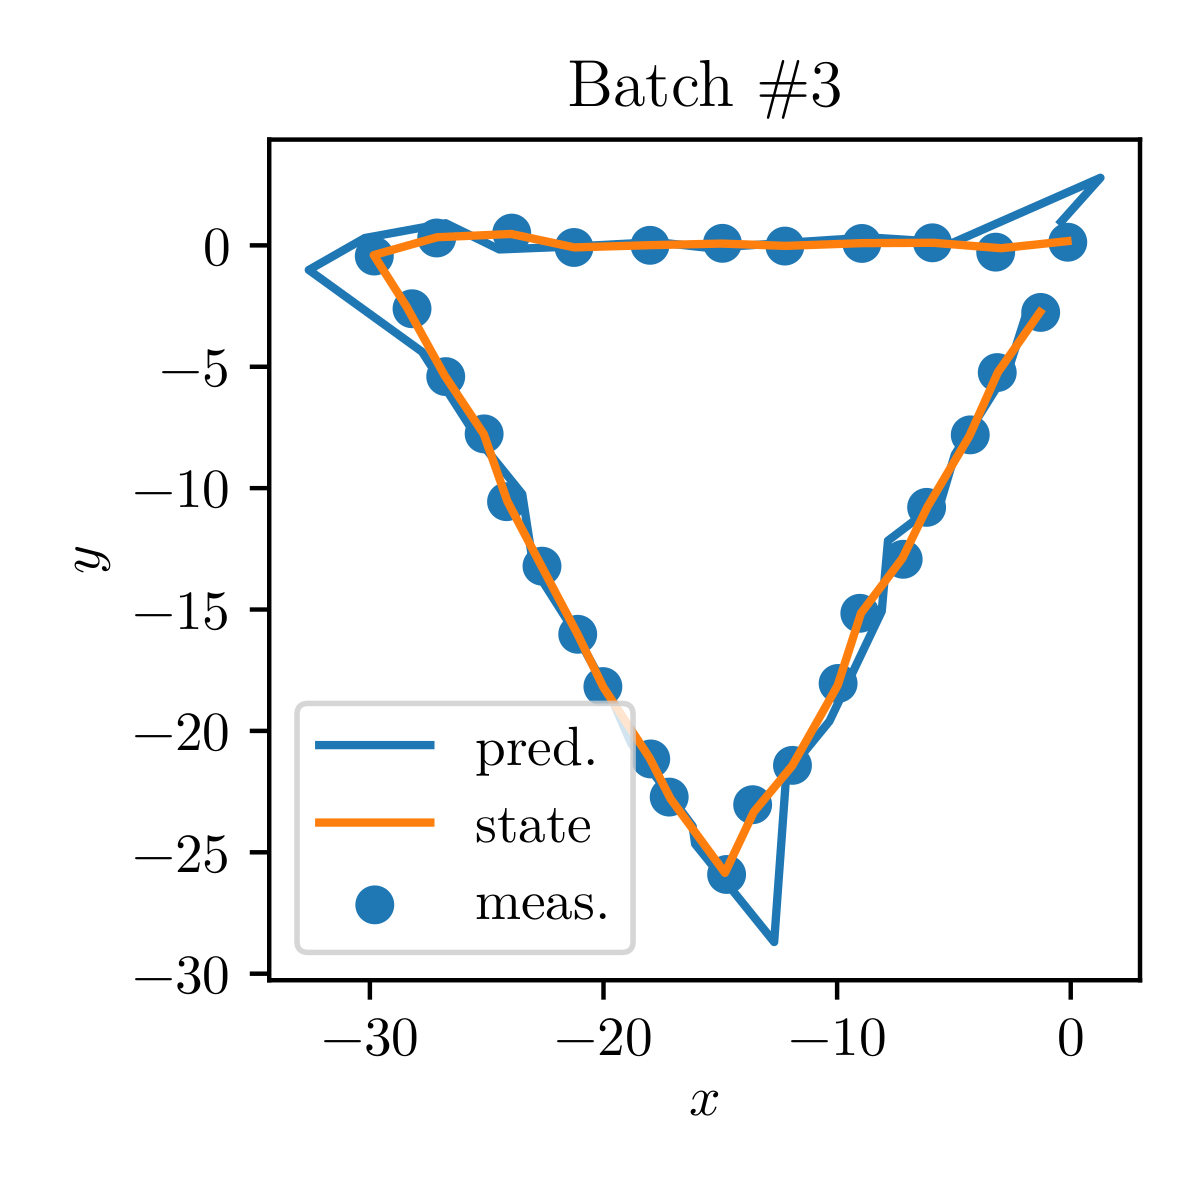
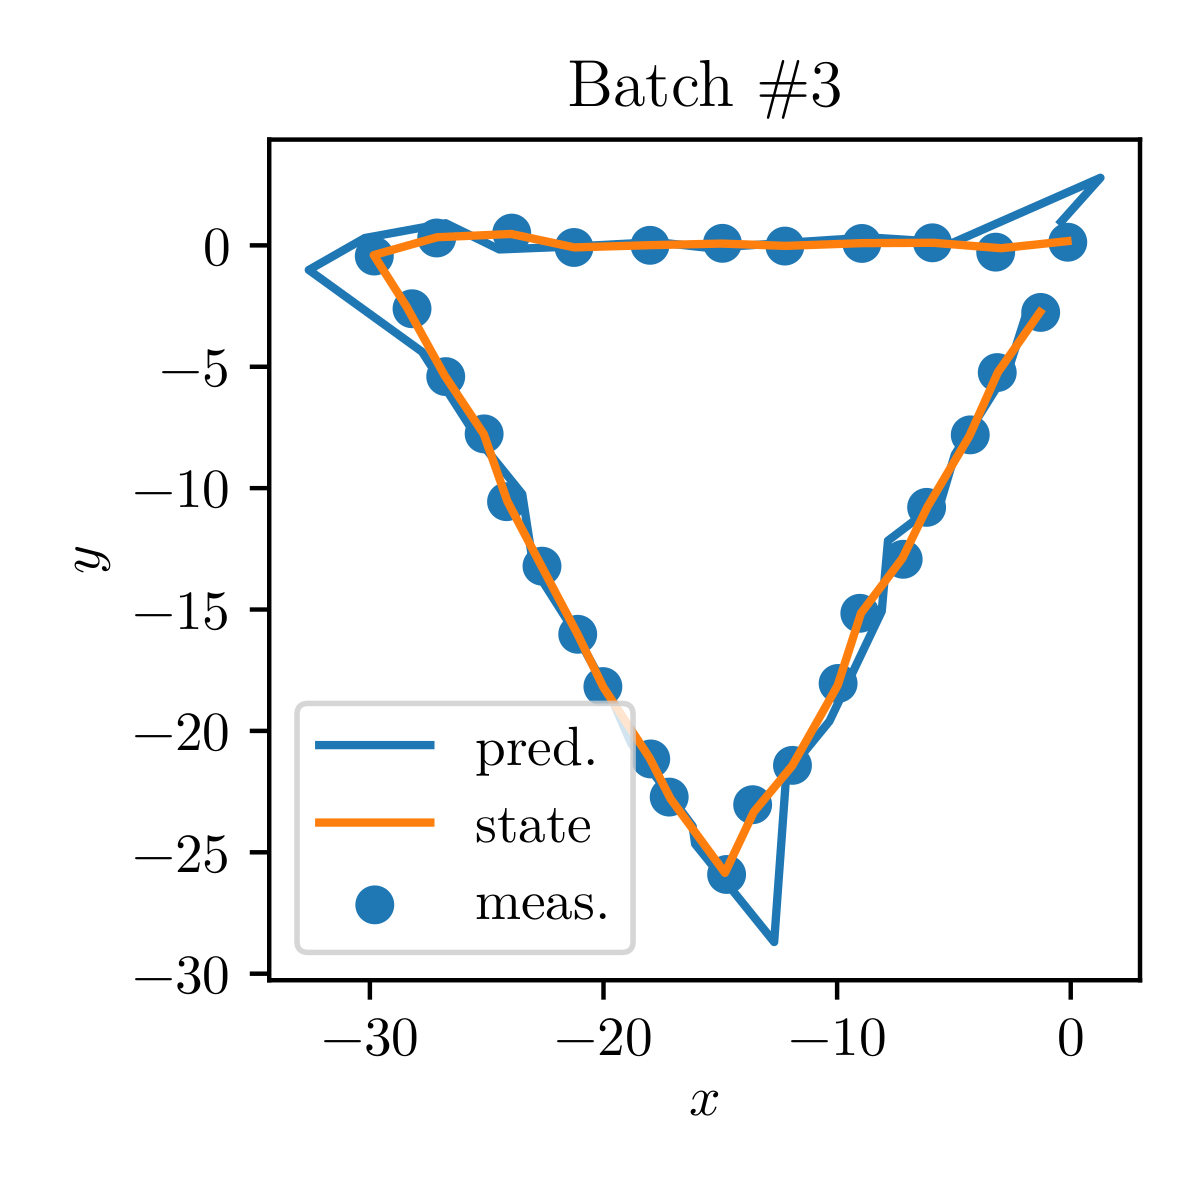
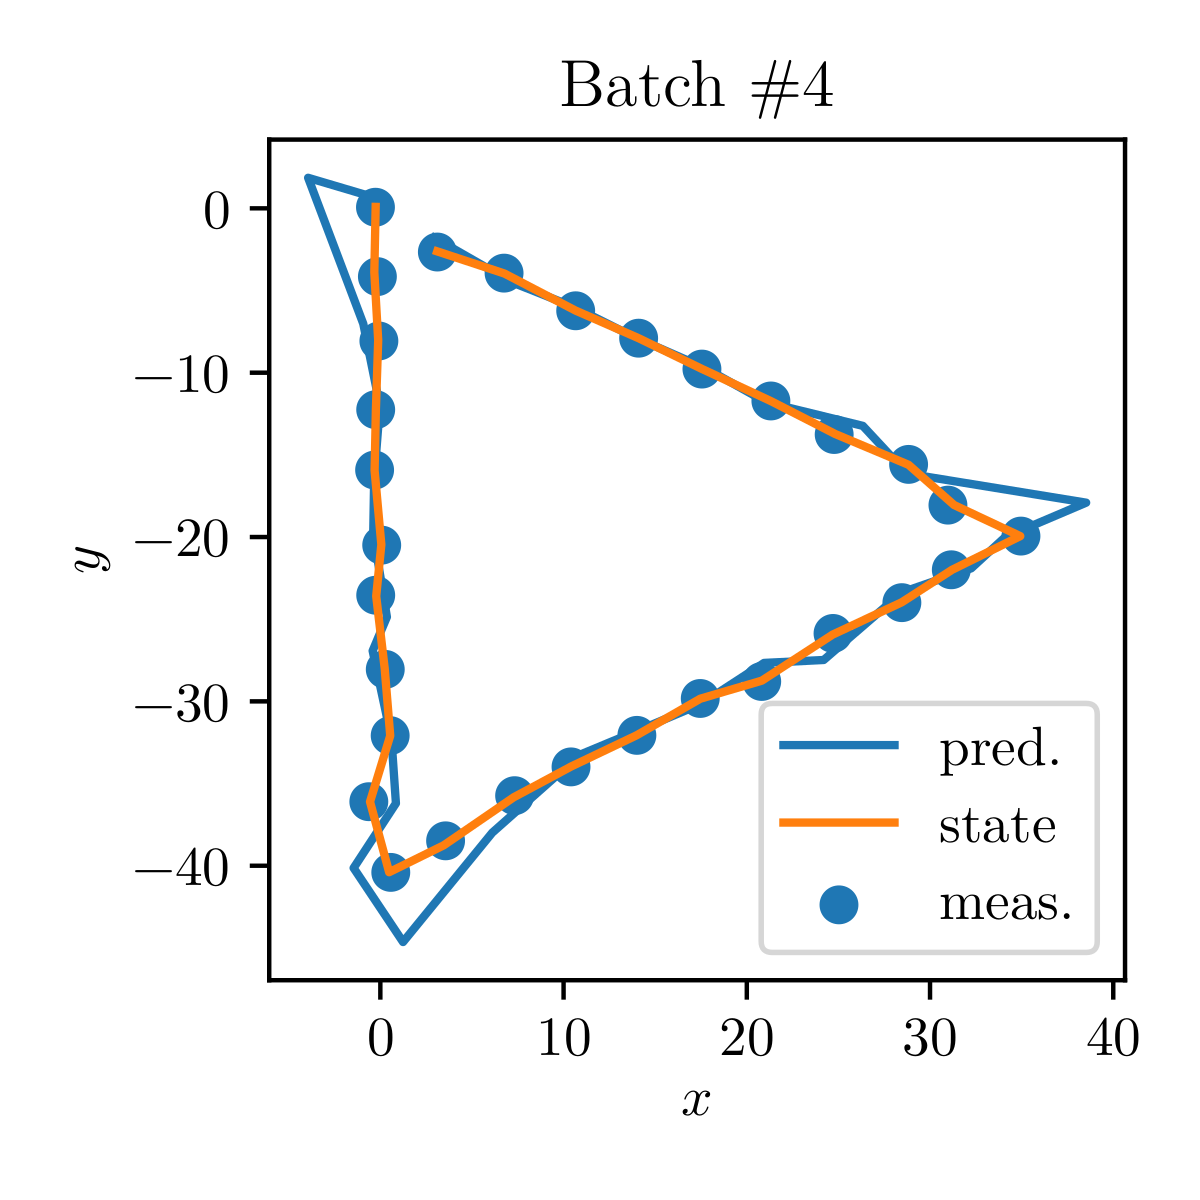
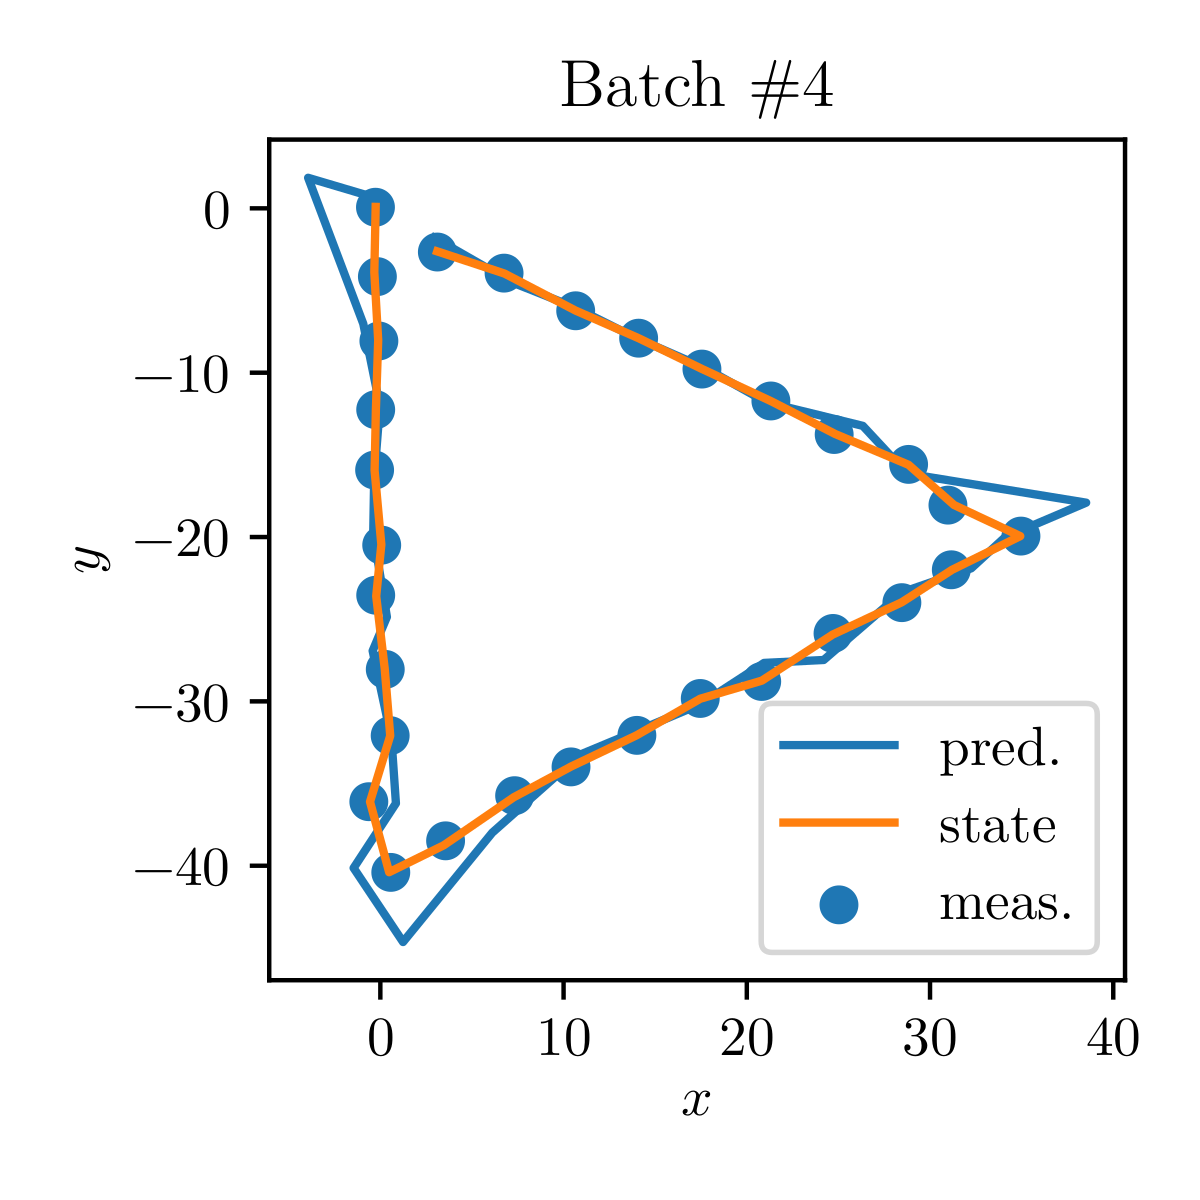

In [17]:
@ftl.with_context
def plot(X_pred, X, states, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.scatter(X[batch_idx, 0], X[batch_idx, 1], label='meas.')
    ax.plot(X_pred[batch_idx, 0], X_pred[batch_idx, 1], label='pred.')
    ax.plot(states[batch_idx, 0], states[batch_idx, 1], label='state')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    ax.legend()
    return ftl.save_fig(fig, file_name, resize=(3, 3))

n = 30
ftl.img_grid([
    plot(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 0, 'pred_b1'),
    plot(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 1, 'pred_b2'),
    plot(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 2, 'pred_b3'),
    plot(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 3, 'pred_b4'),
], n_columns=4)


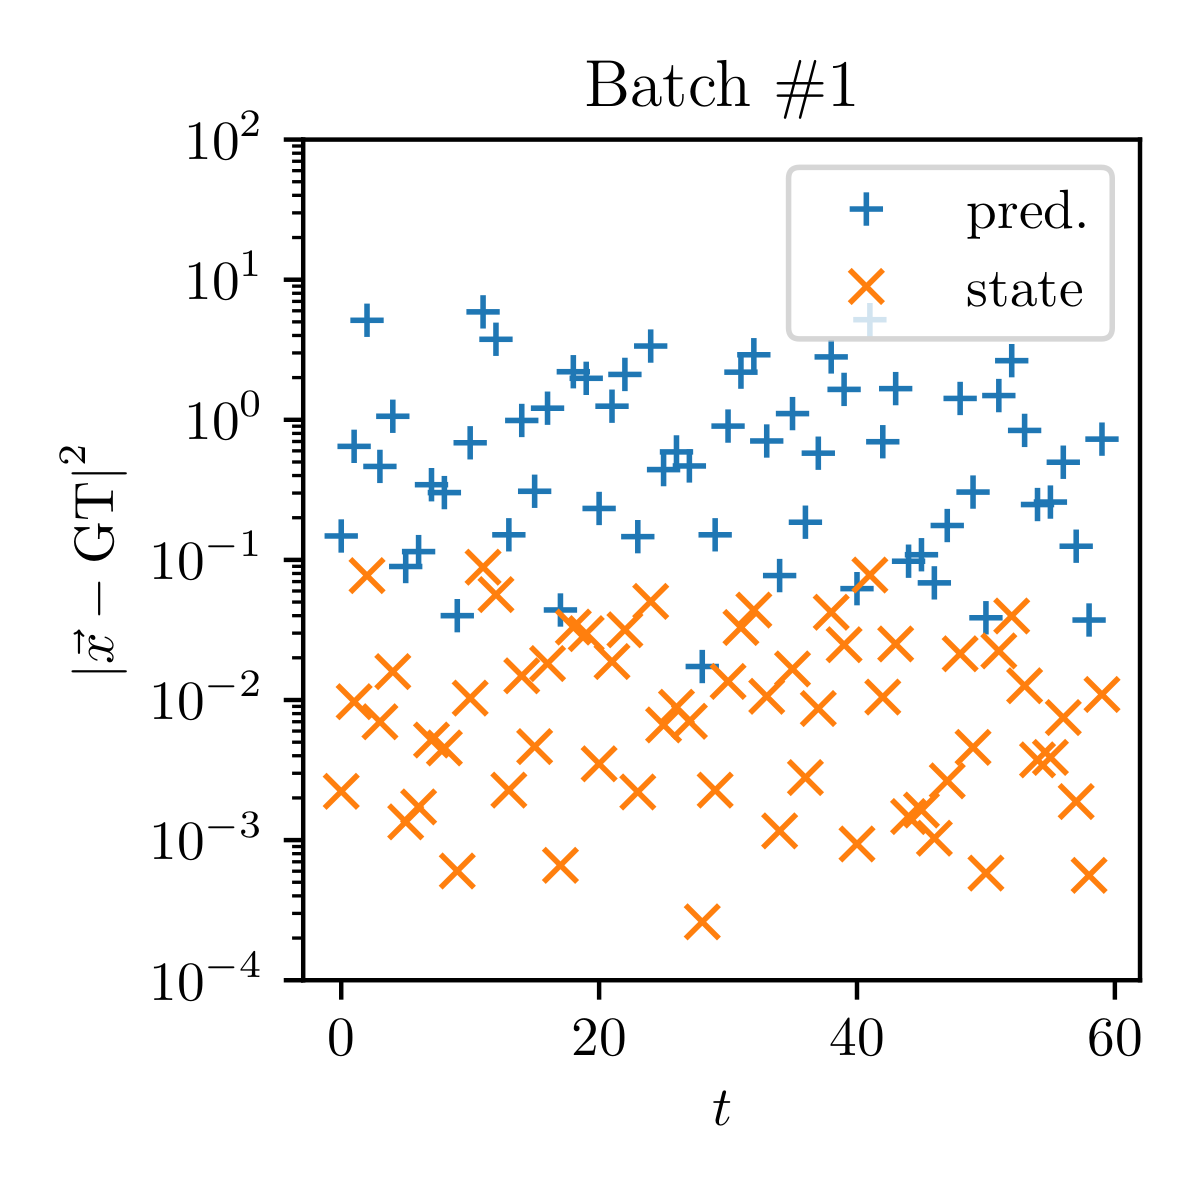
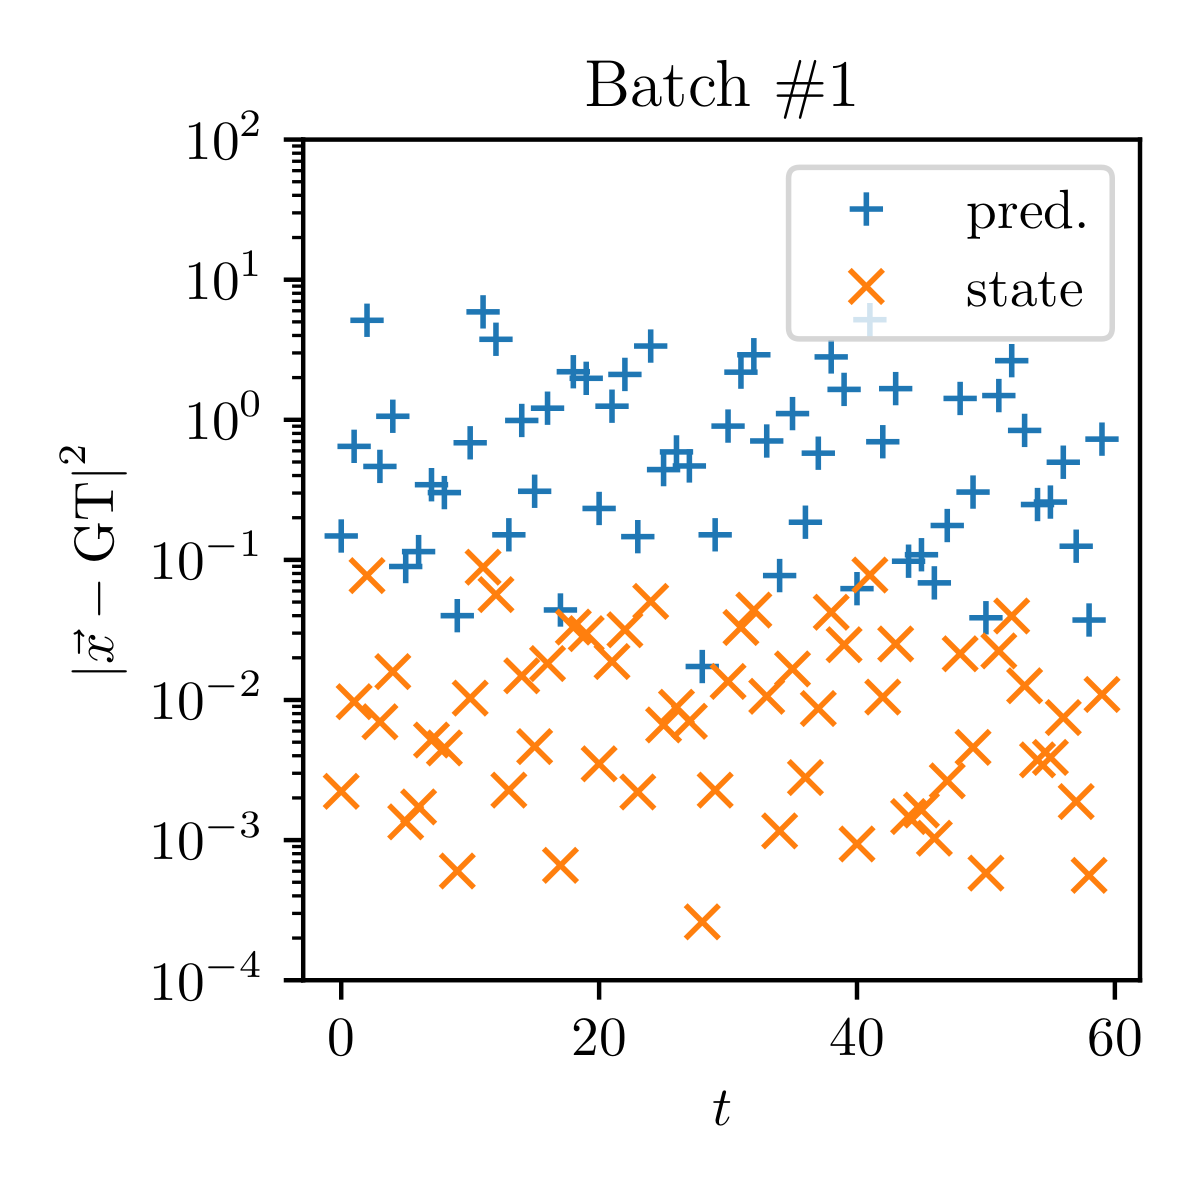
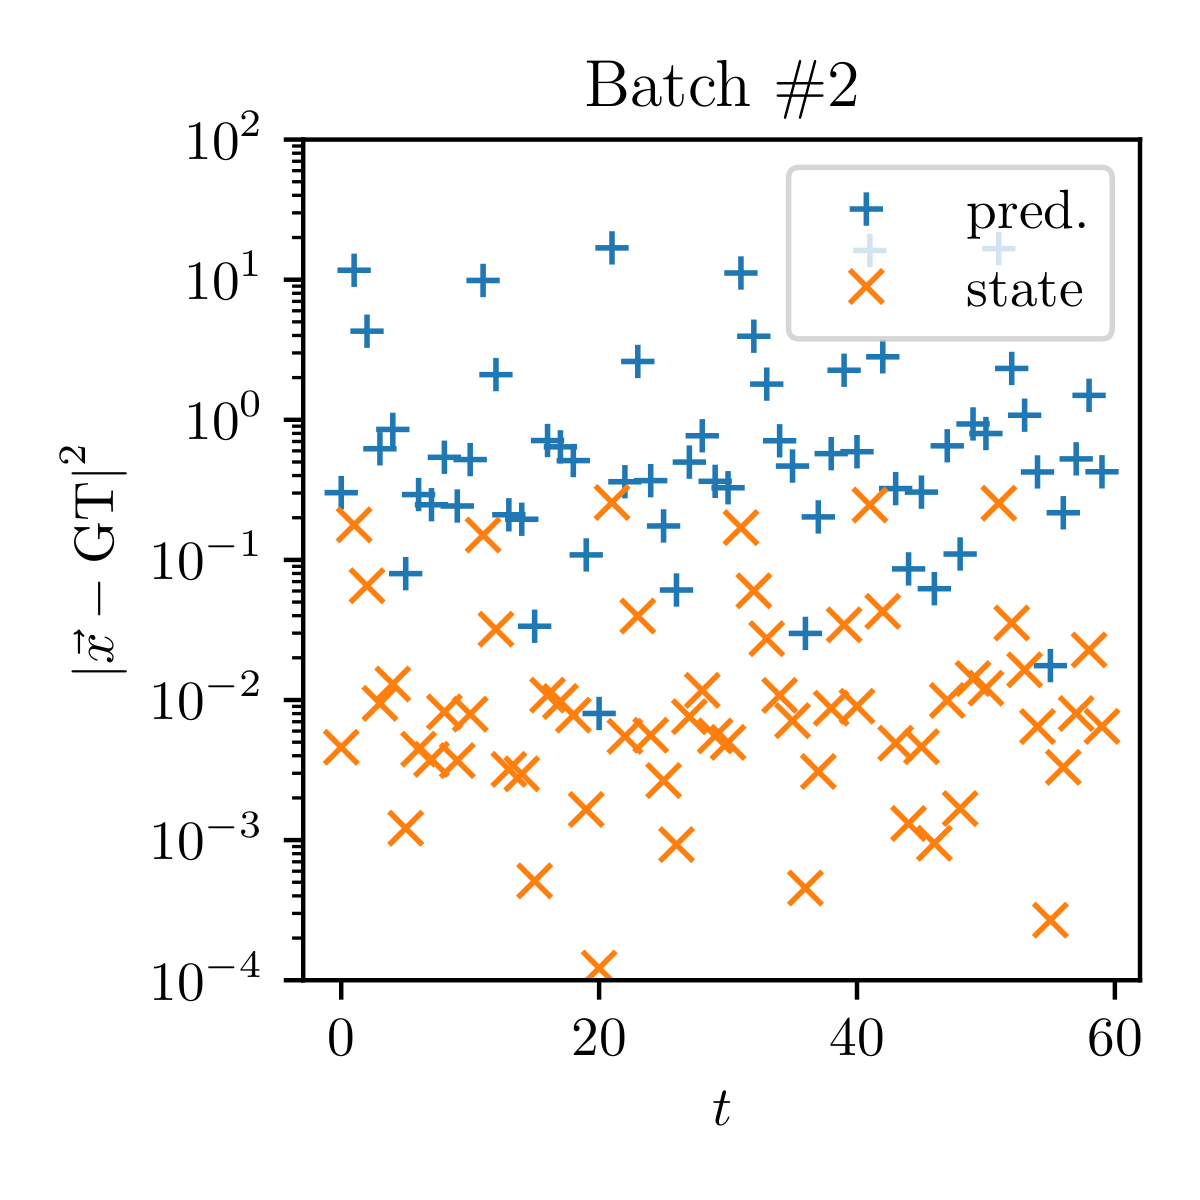
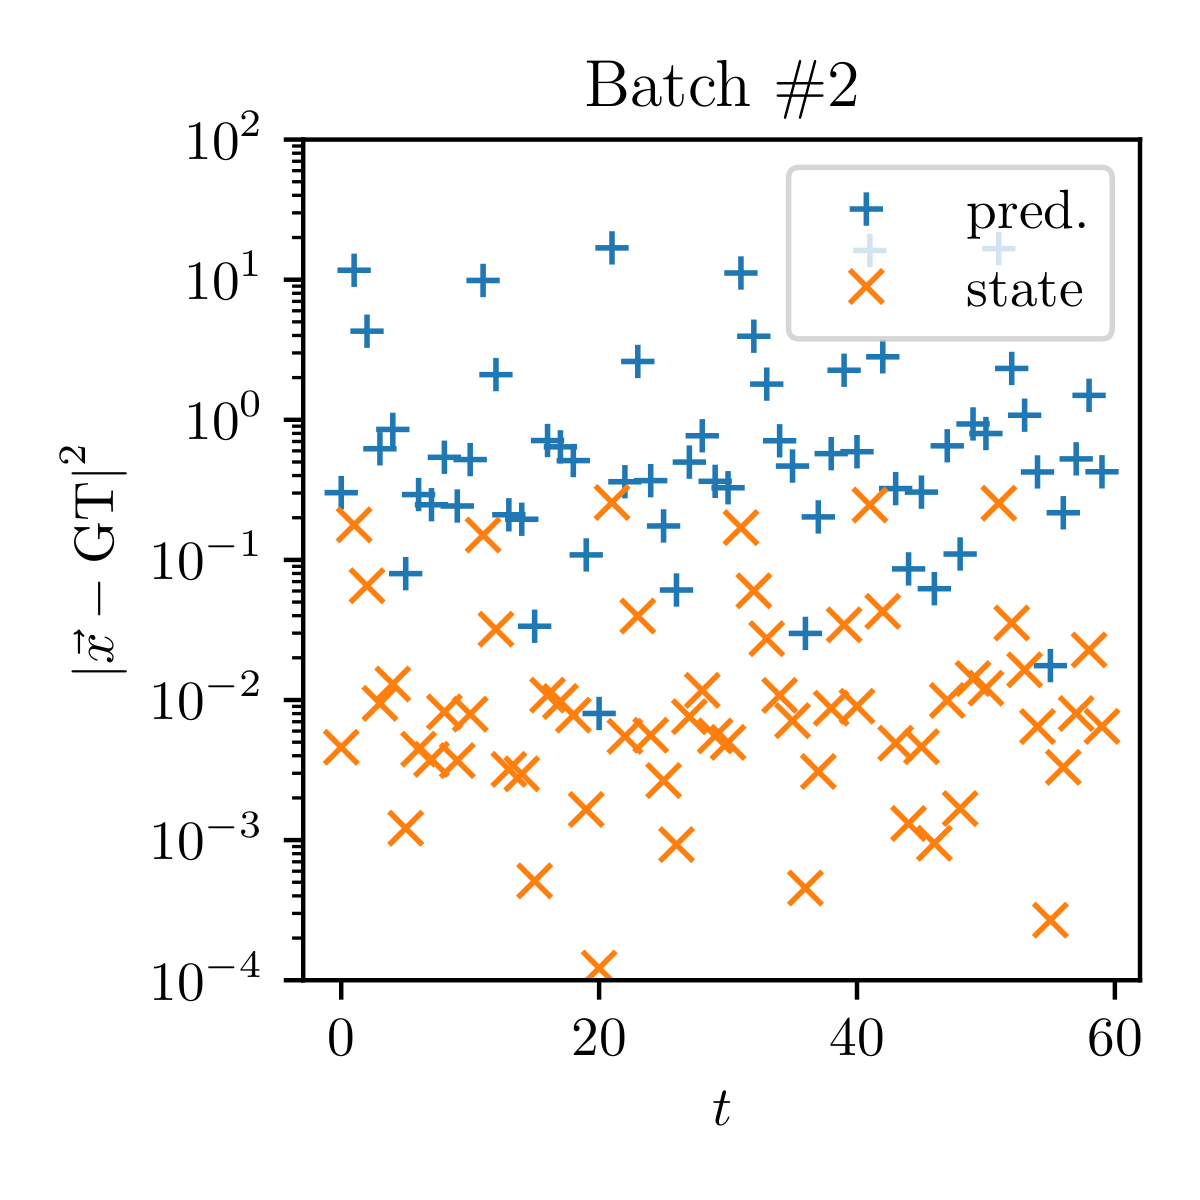
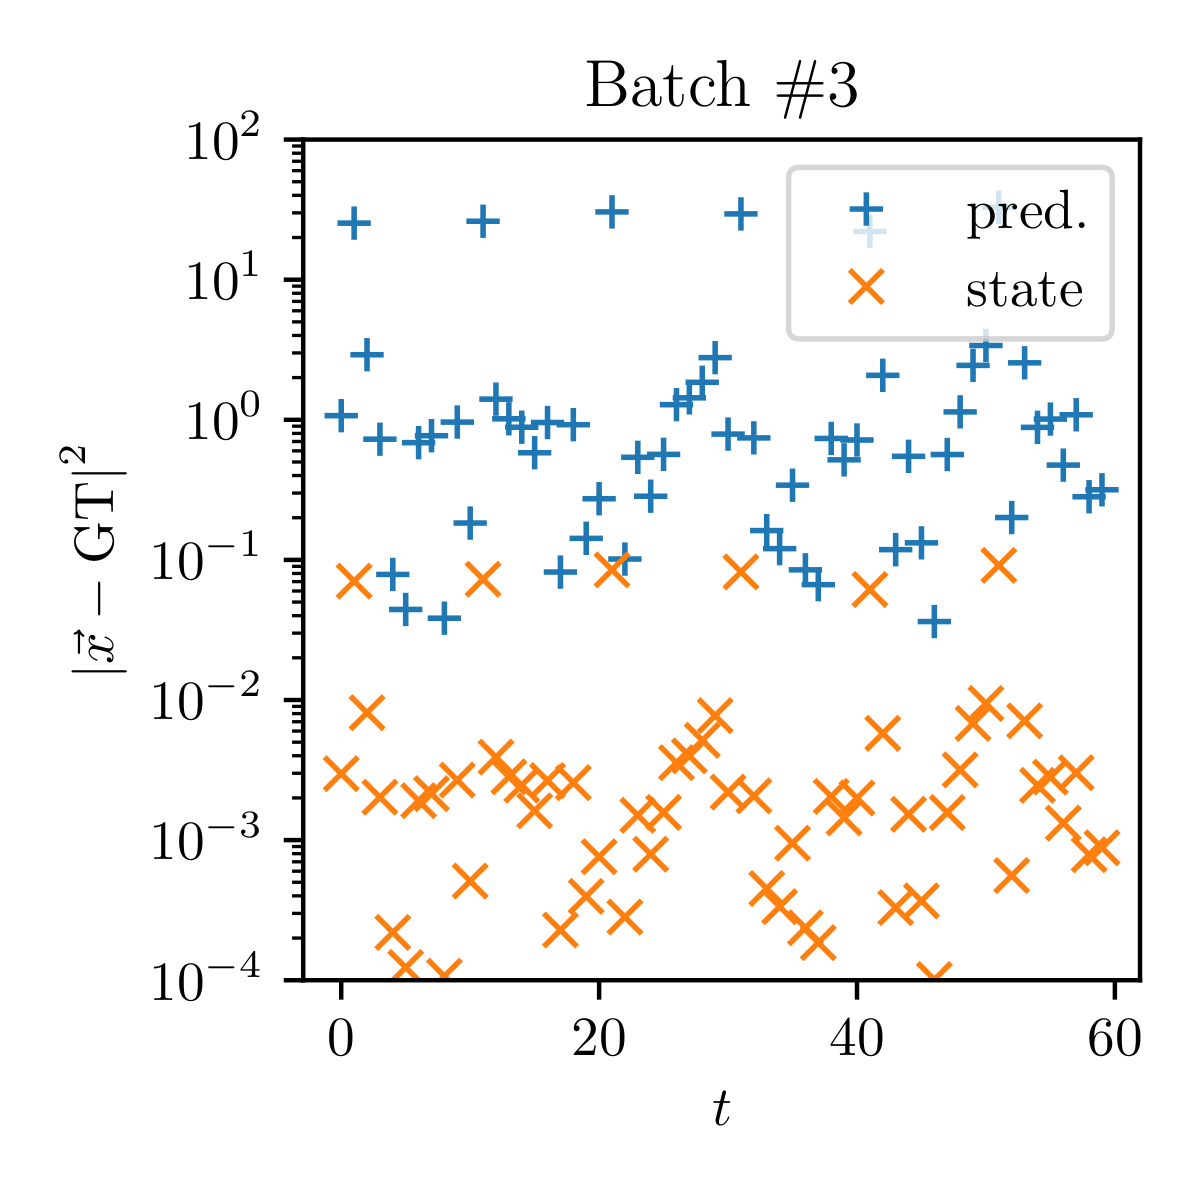
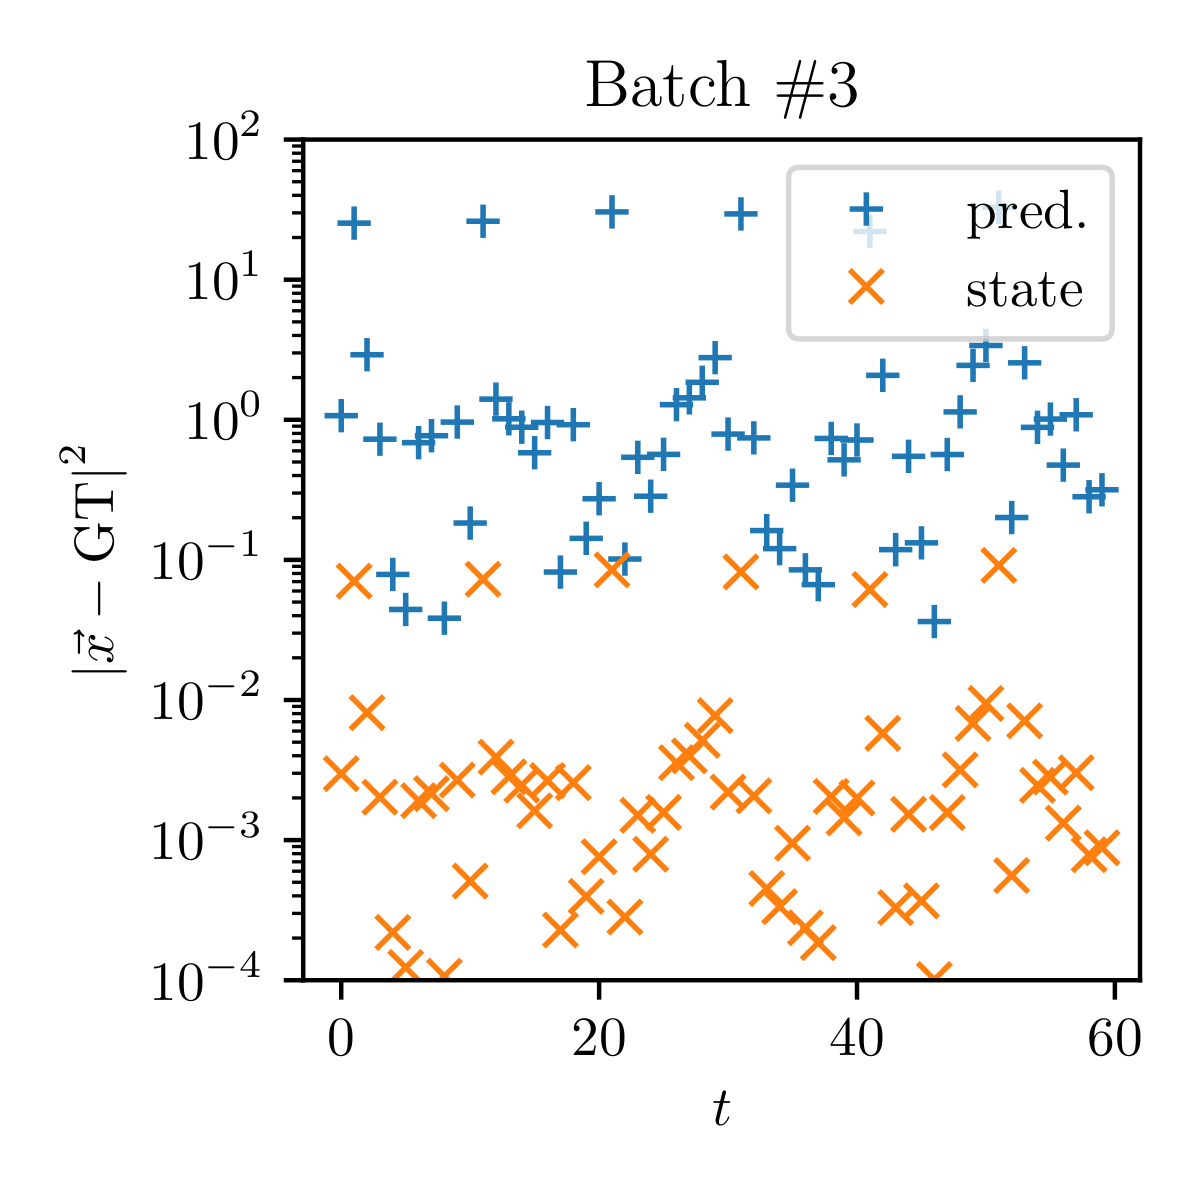
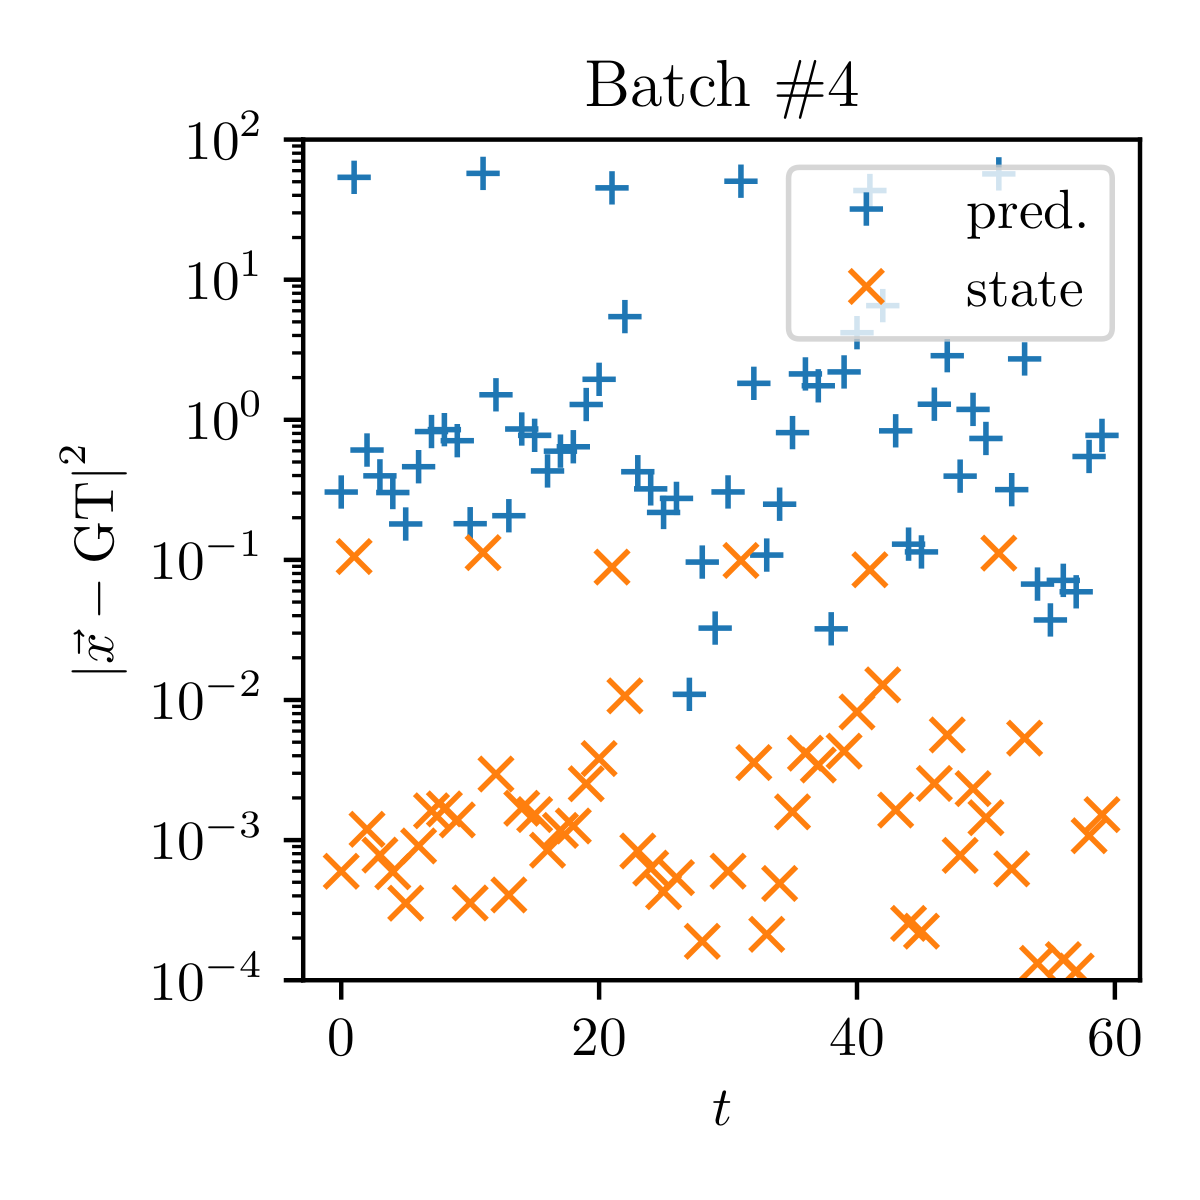
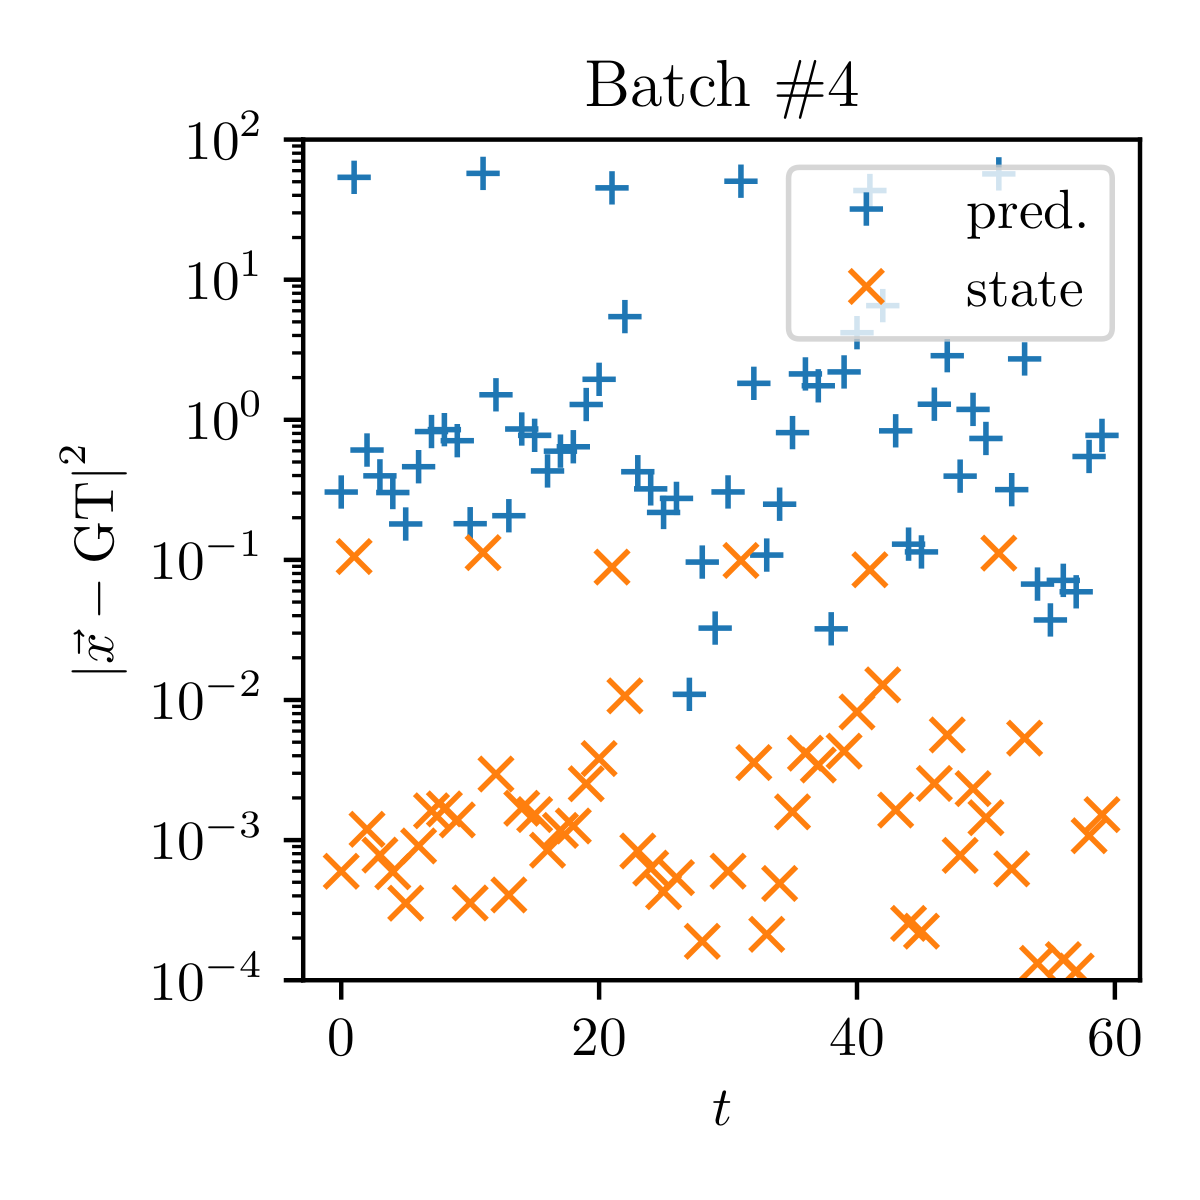
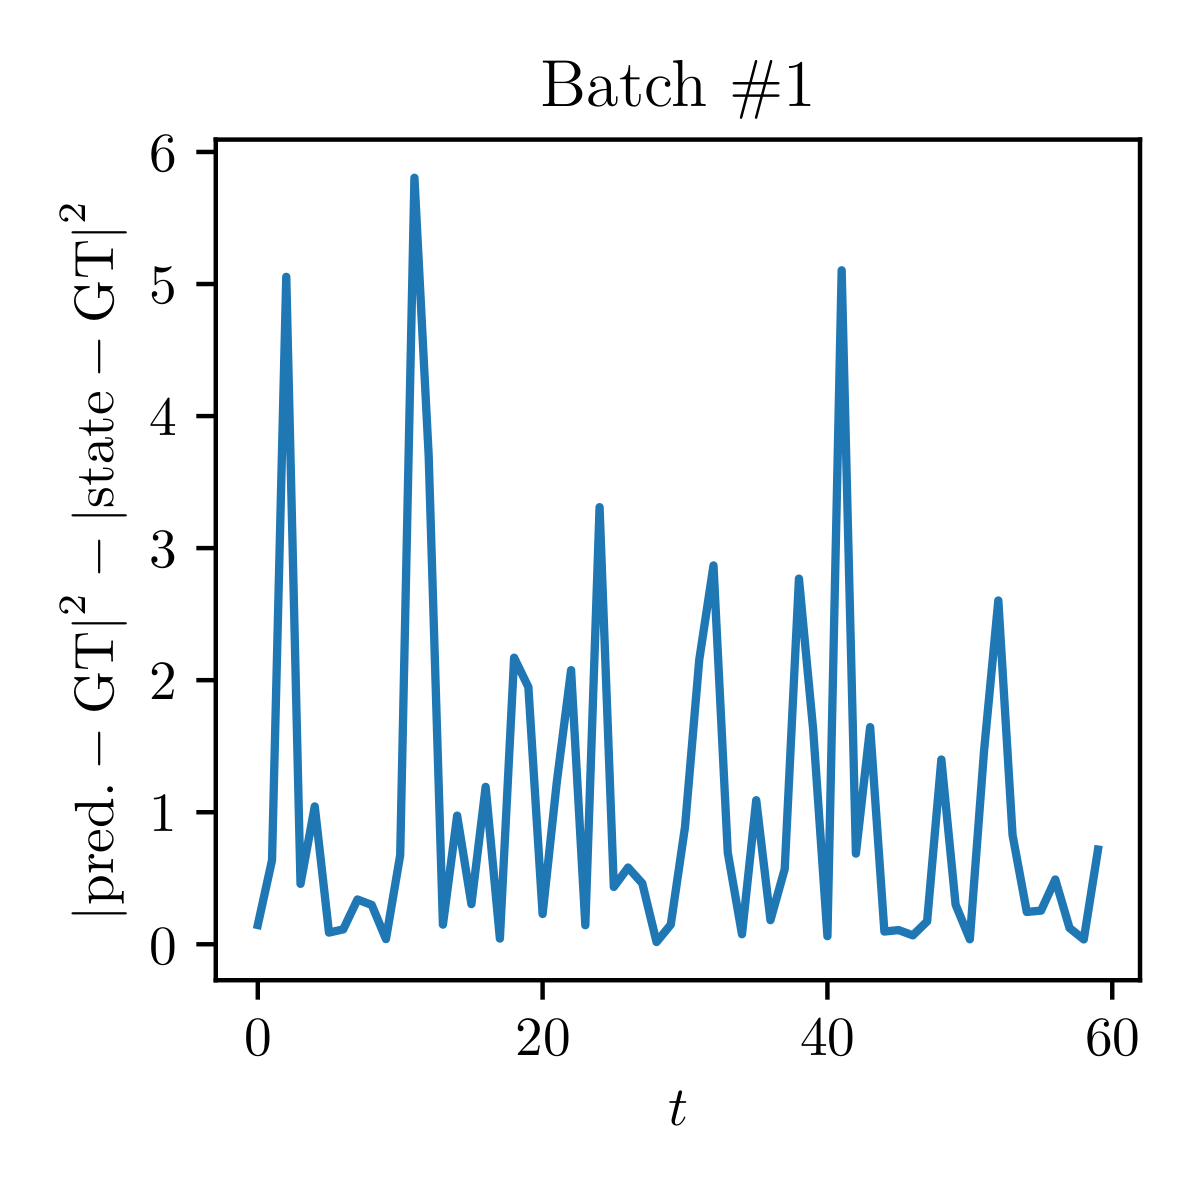
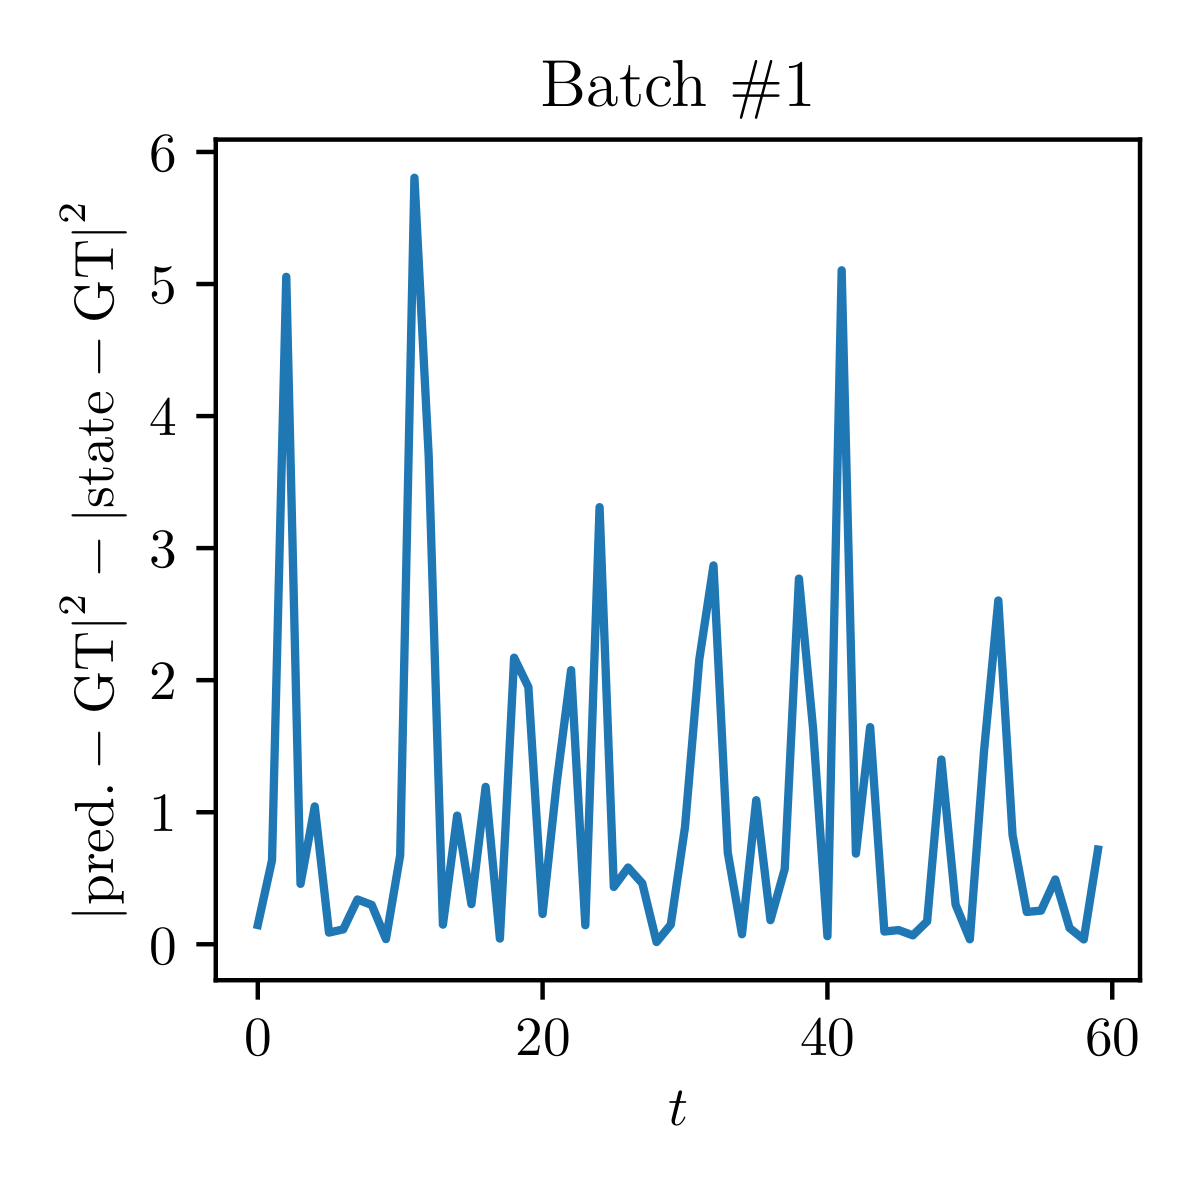
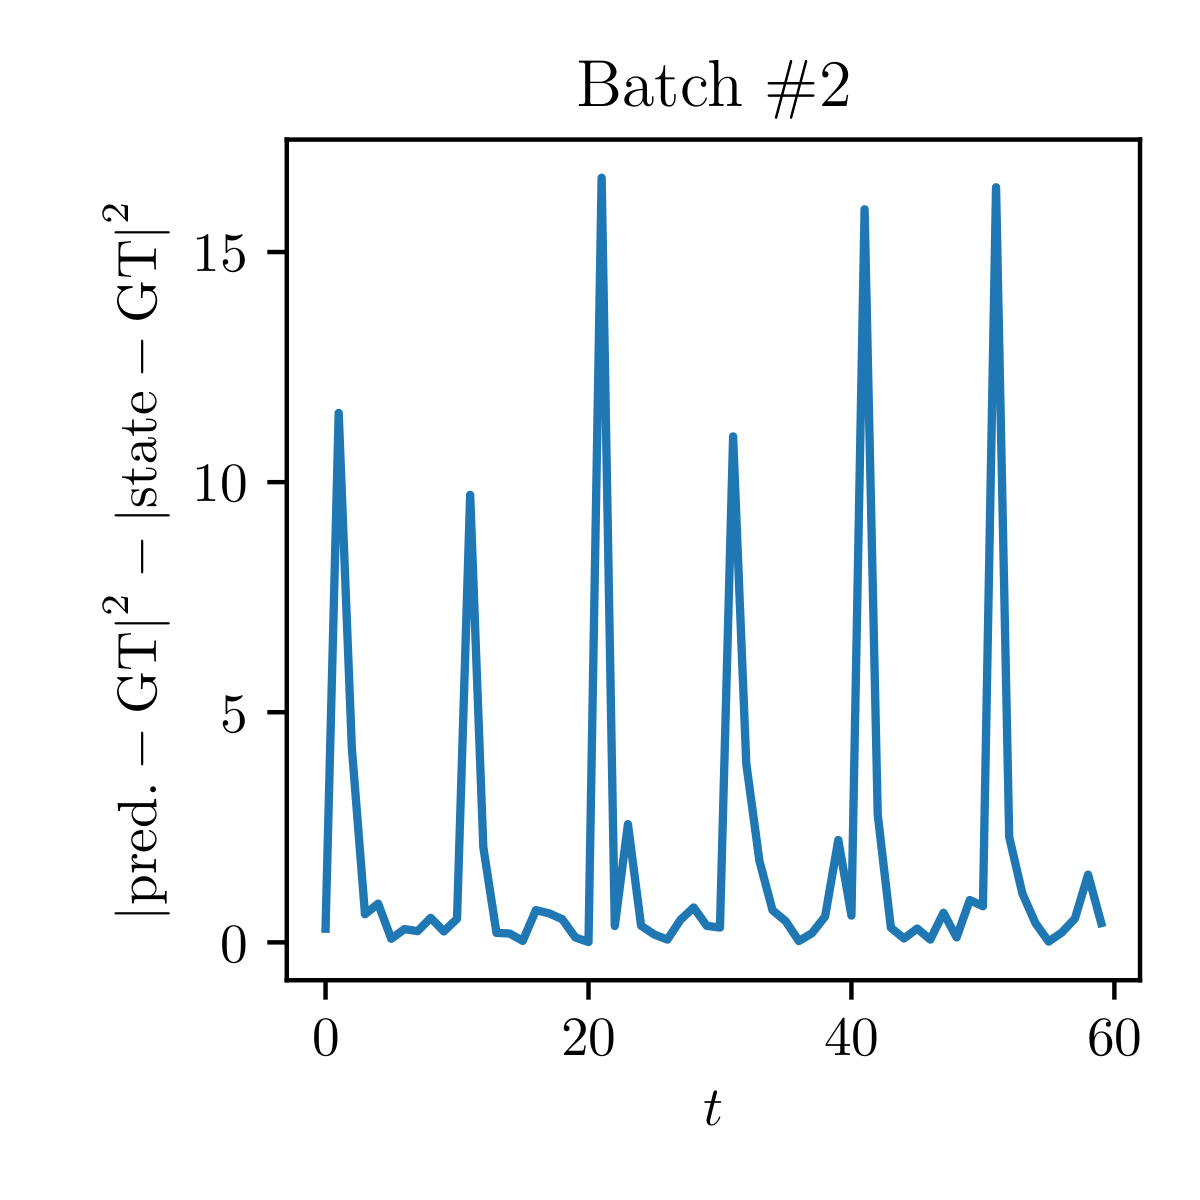
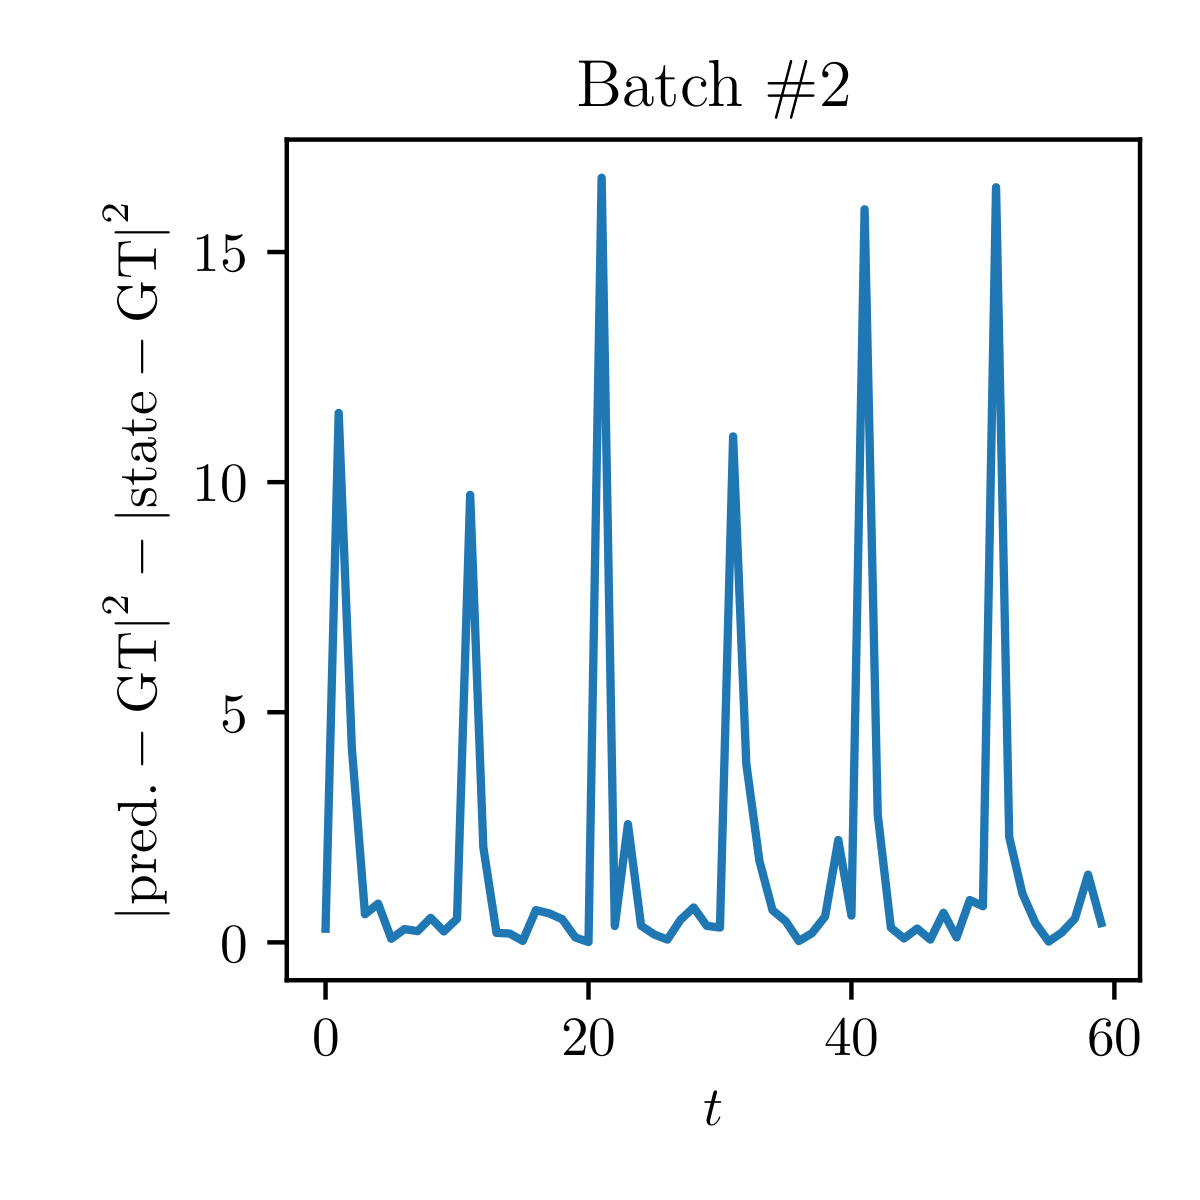
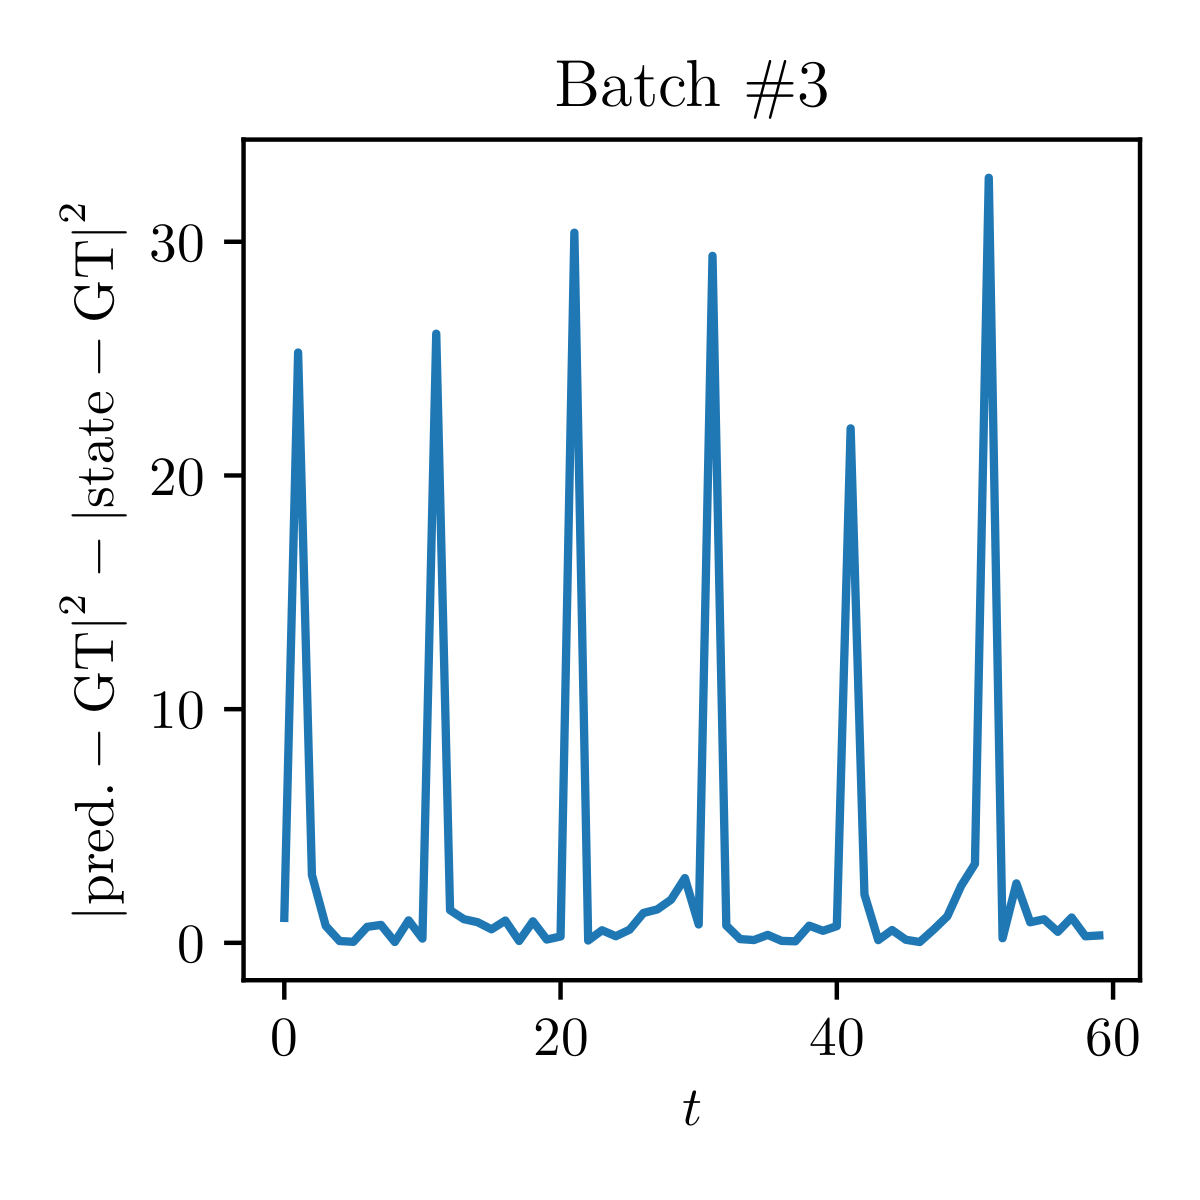
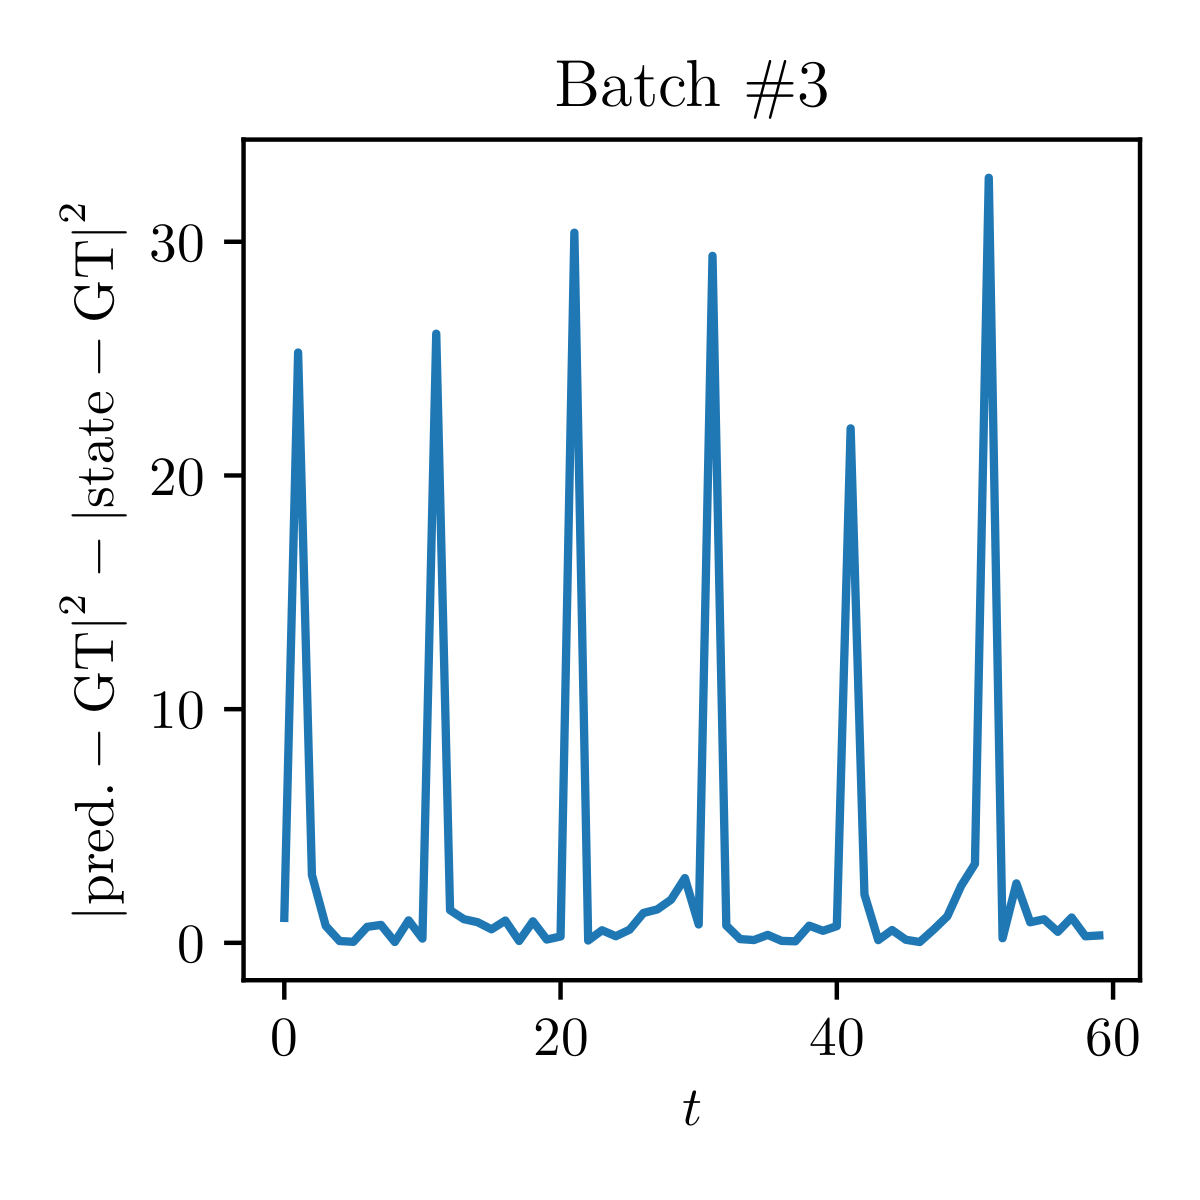
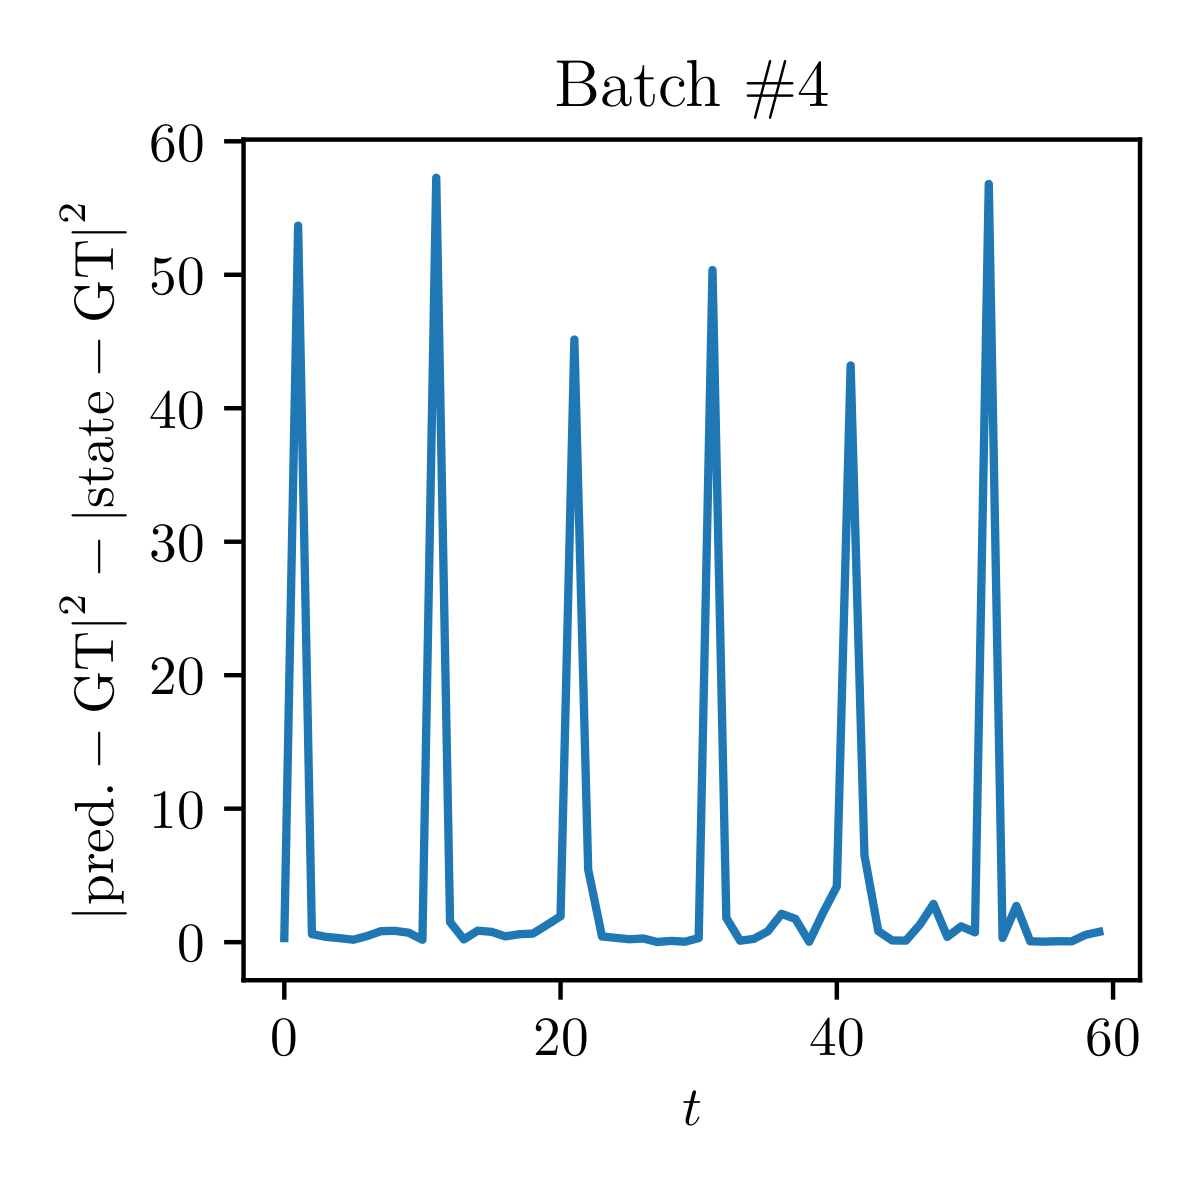
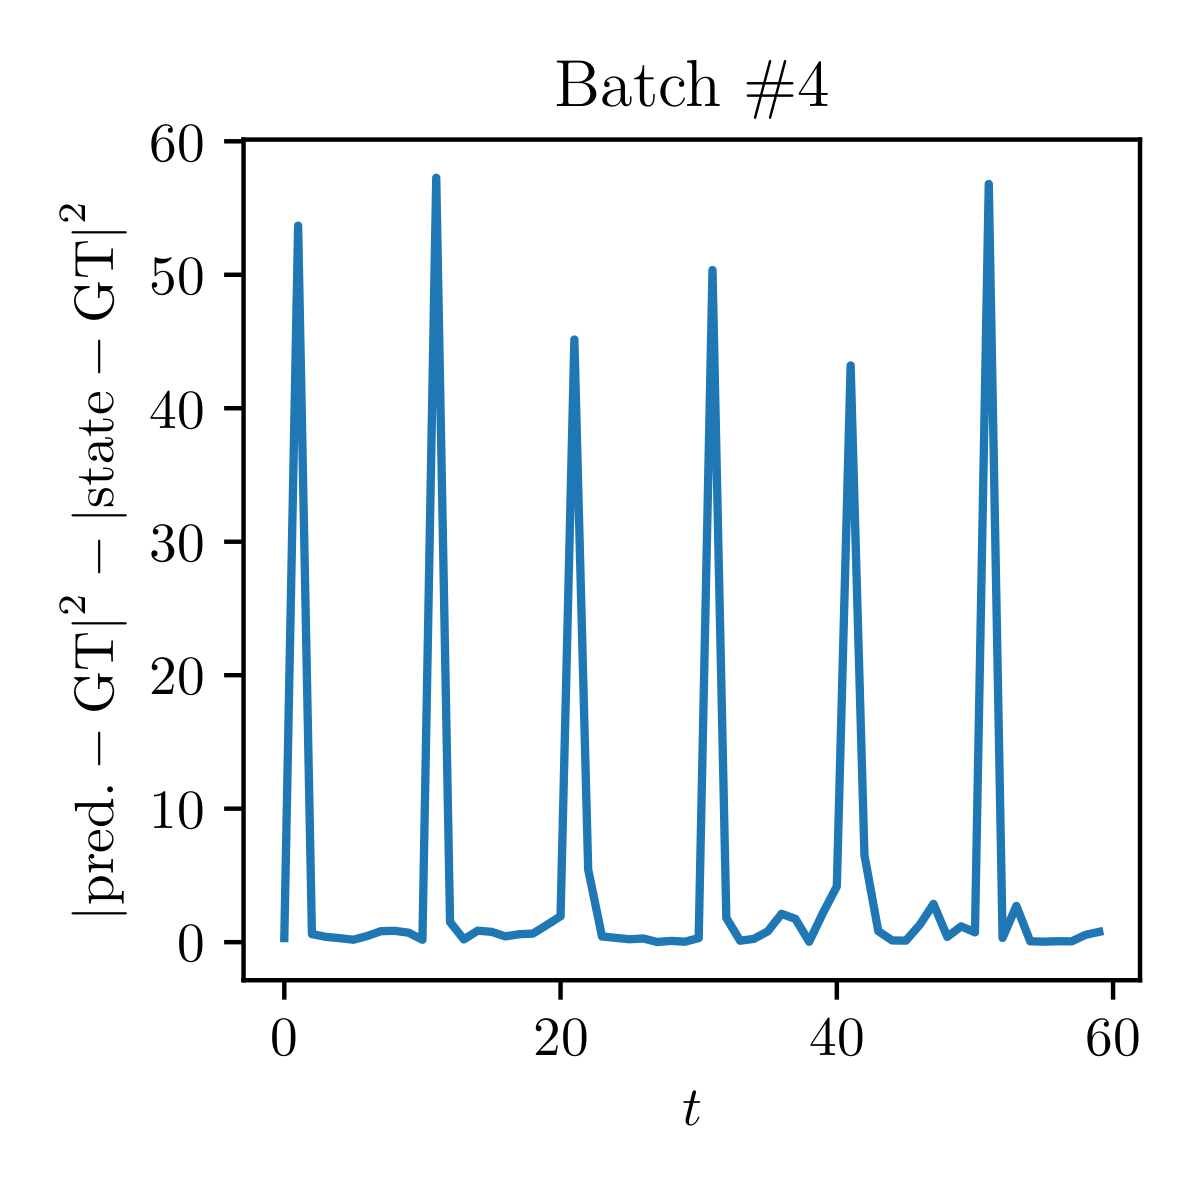

In [18]:
@ftl.with_context
def plot_diff(X_pred, X, states, batch_idx, file_name):
    res_pred = (X_pred[batch_idx] - X[batch_idx])**2
    res_states = (states[batch_idx, (0, 1)] - X[batch_idx])**2

    fig, ax = plt.subplots()
    ax.plot(torch.sum(res_pred, dim=0), marker='+', linestyle='none', label='pred.')
    ax.plot(torch.sum(res_states, dim=0), marker='x', linestyle='none', label='state')
    ax.set_ylim(.0001, 100.)
    ax.set_yscale('log')
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\left|\vec{x} - \mathrm{GT} \right|^2$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    ax.legend()
    return ftl.save_fig(fig, file_name, resize=(3, 3))

@ftl.with_context
def plot_ddiff(X_pred, X, states, batch_idx, file_name):
    res_pred = (X_pred[batch_idx] - X[batch_idx])**2
    res_states = (states[batch_idx, (0, 1)] - X[batch_idx])**2
    diff = torch.sum(res_pred, dim=0) - torch.sum(res_states, dim=0)

    fig, ax = plt.subplots()
    ax.plot(diff)
    ax.set_xlabel('$t$')
    ax.set_ylabel(r'$\left|\mathrm{pred.} - \mathrm{GT} \right|^2 - \left|\mathrm{state} - \mathrm{GT} \right|^2$')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name, resize=(3, 3))

n = 60
ftl.img_grid([
    plot_diff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 0, 'diff_b1'),
    plot_diff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 1, 'diff_b2'),
    plot_diff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 2, 'diff_b3'),
    plot_diff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 3, 'diff_b4'),
    plot_ddiff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 0, 'ddiff_b1'),
    plot_ddiff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 1, 'ddiff_b2'),
    plot_ddiff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 2, 'ddiff_b3'),
    plot_ddiff(X_pred[:, :, -n:], X[:, :, -n:], states[:, :, -n:], 3, 'ddiff_b4'),
], n_columns=4)


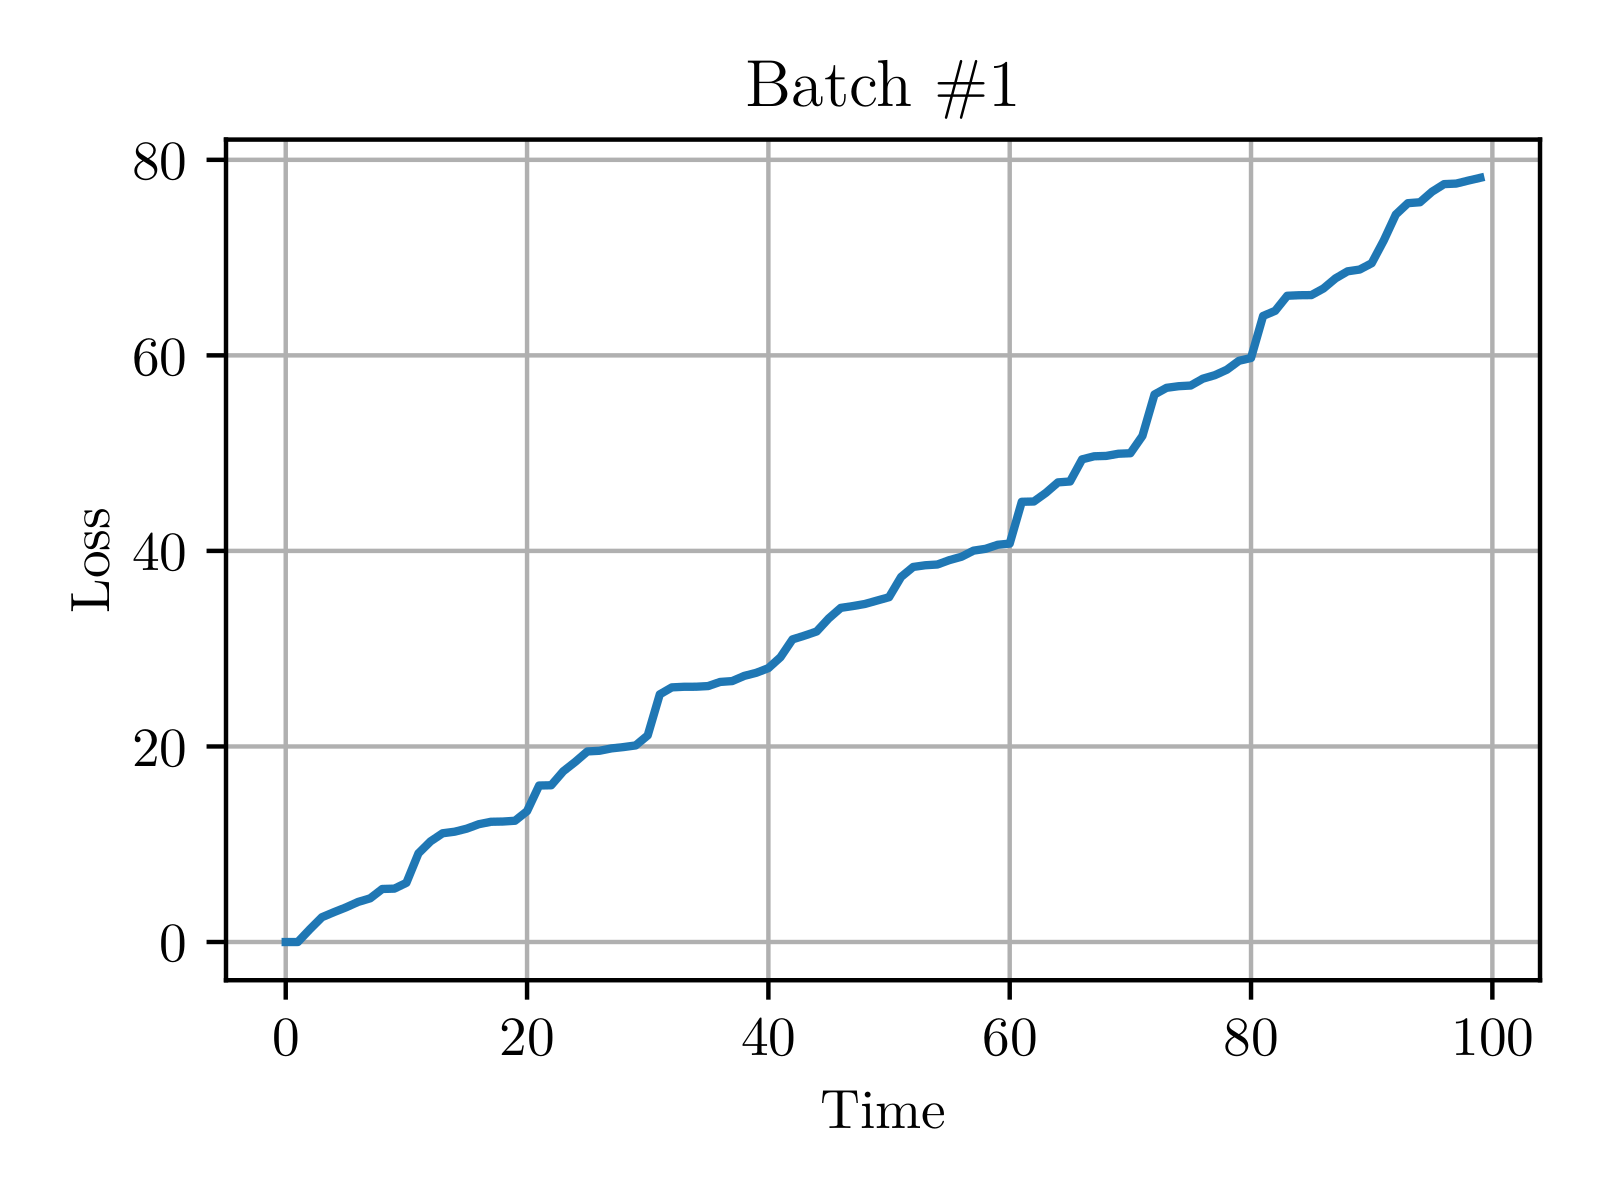
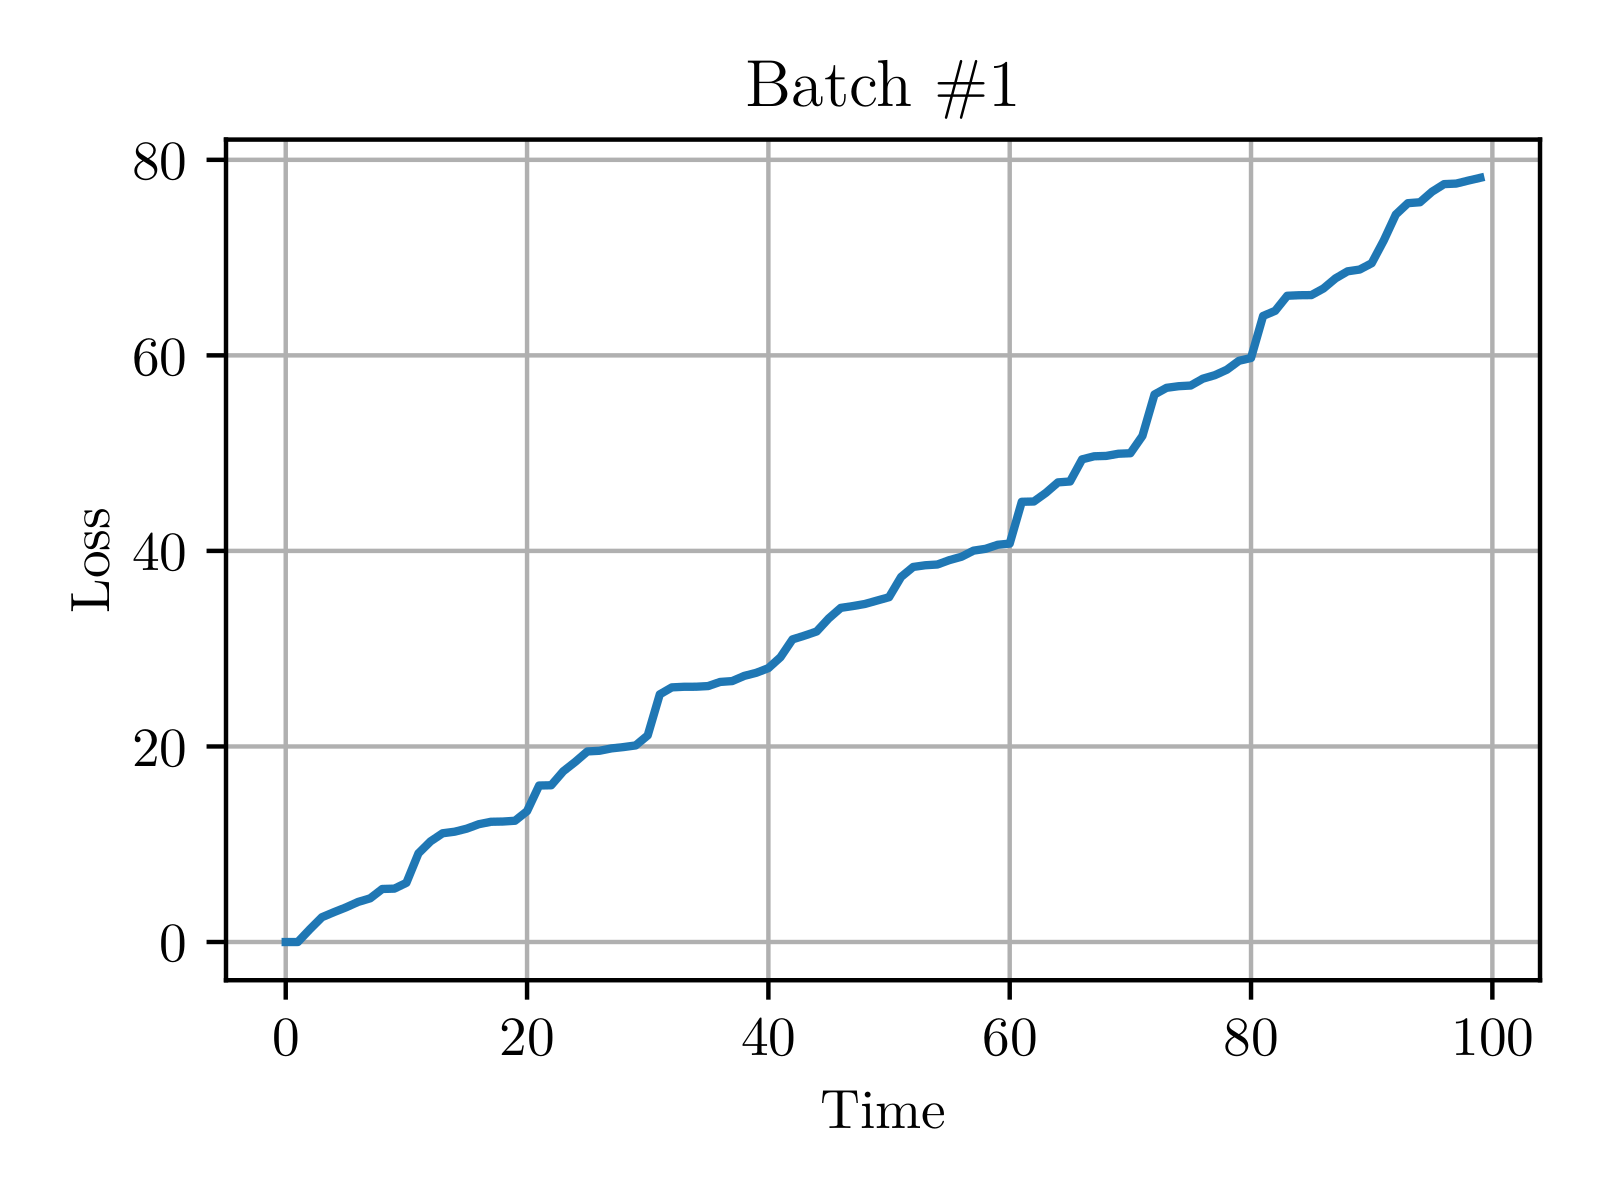
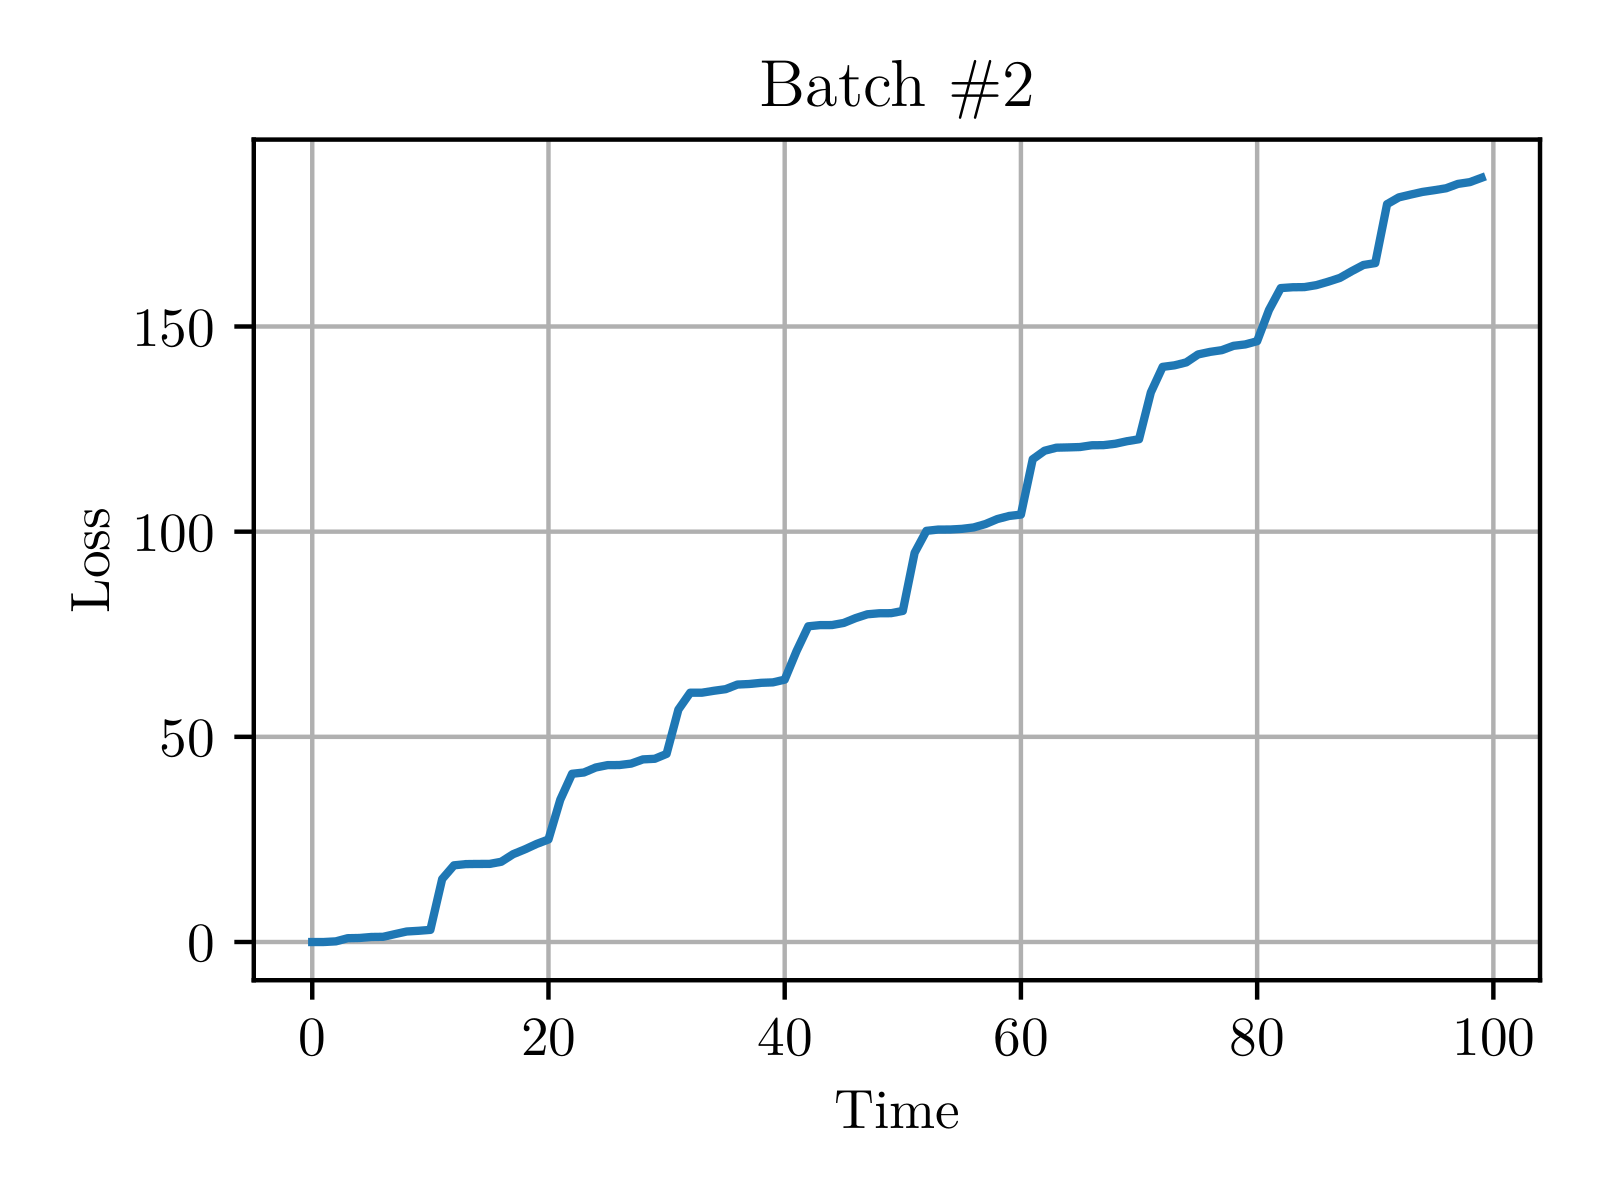
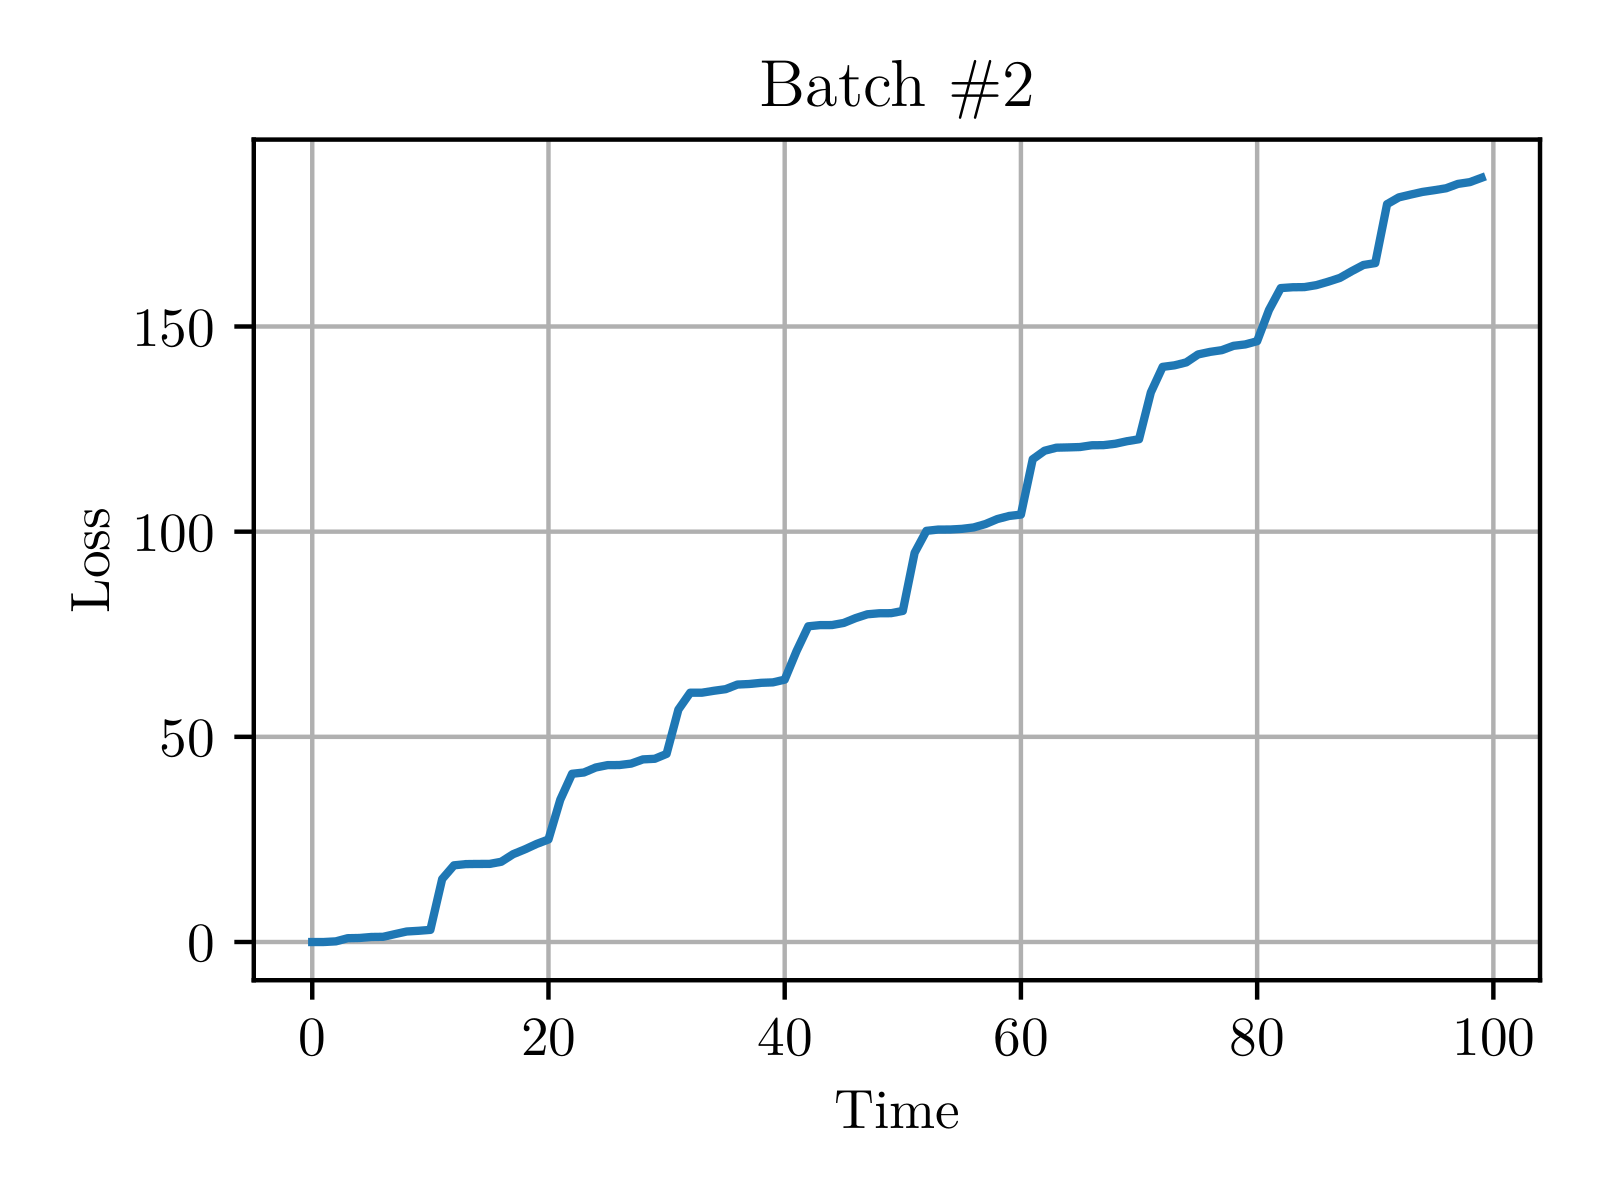
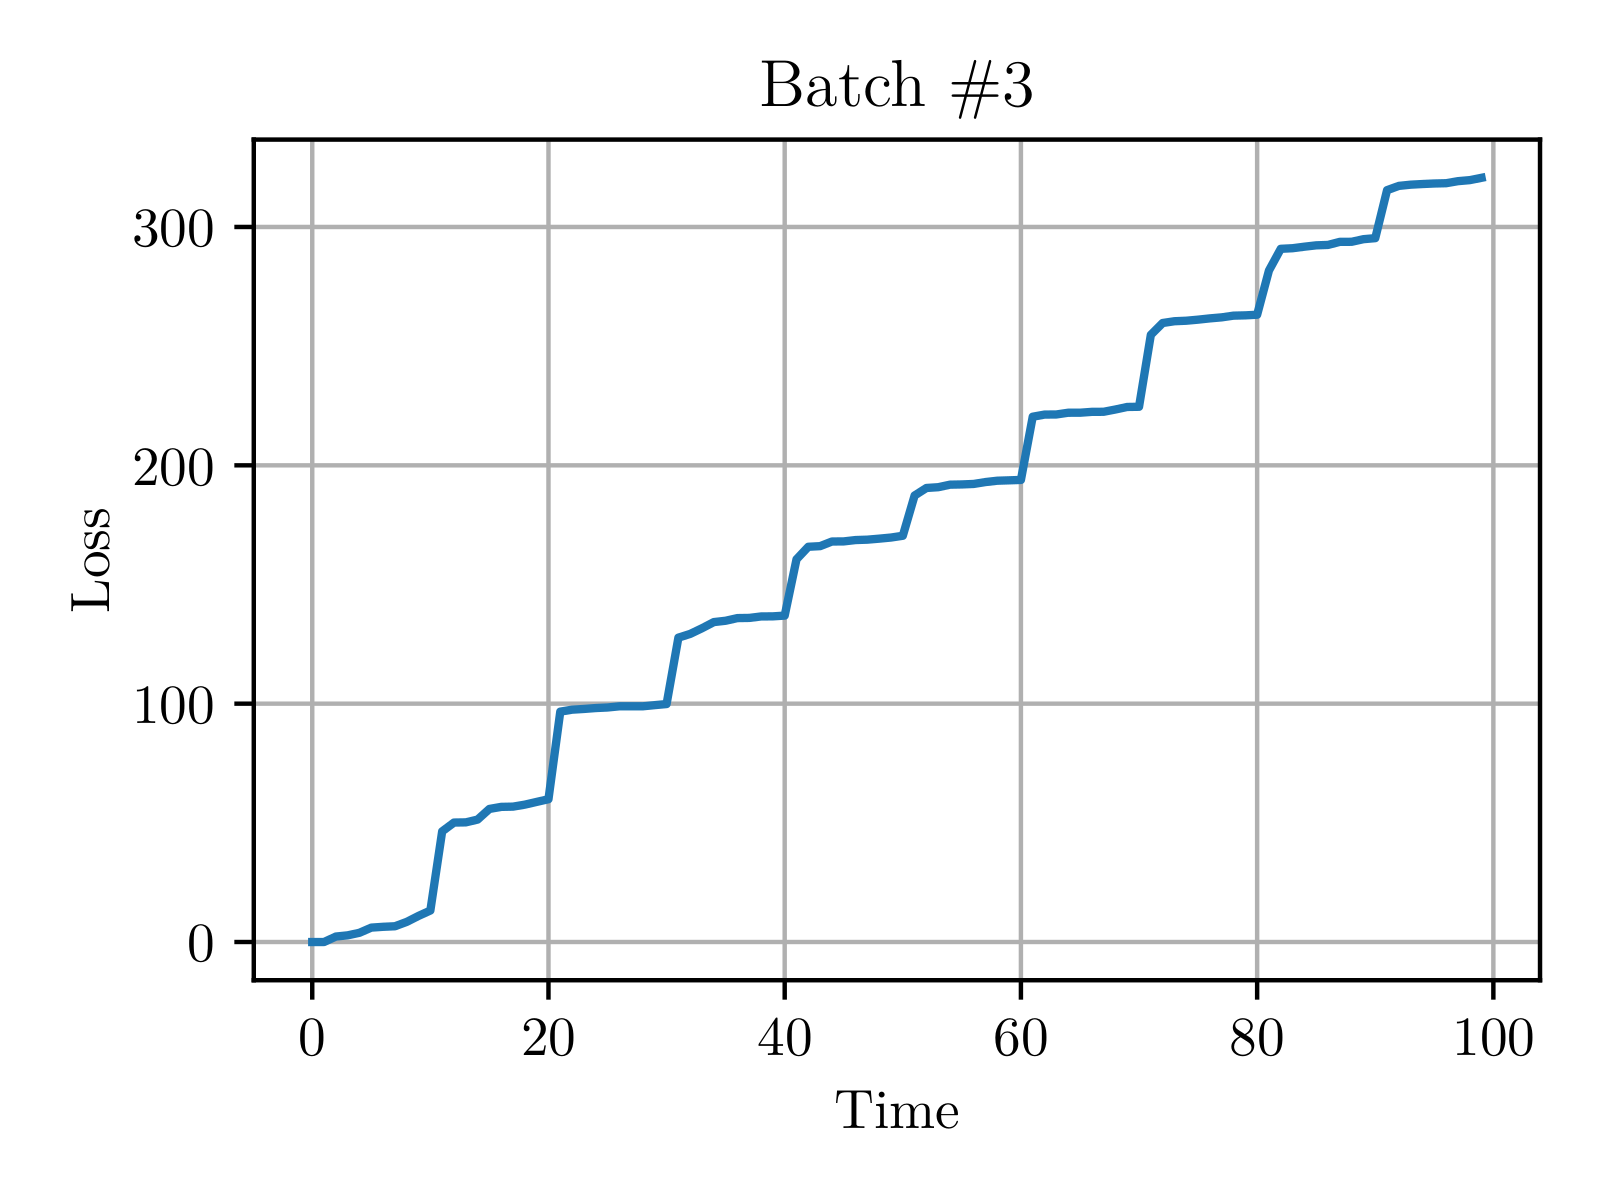
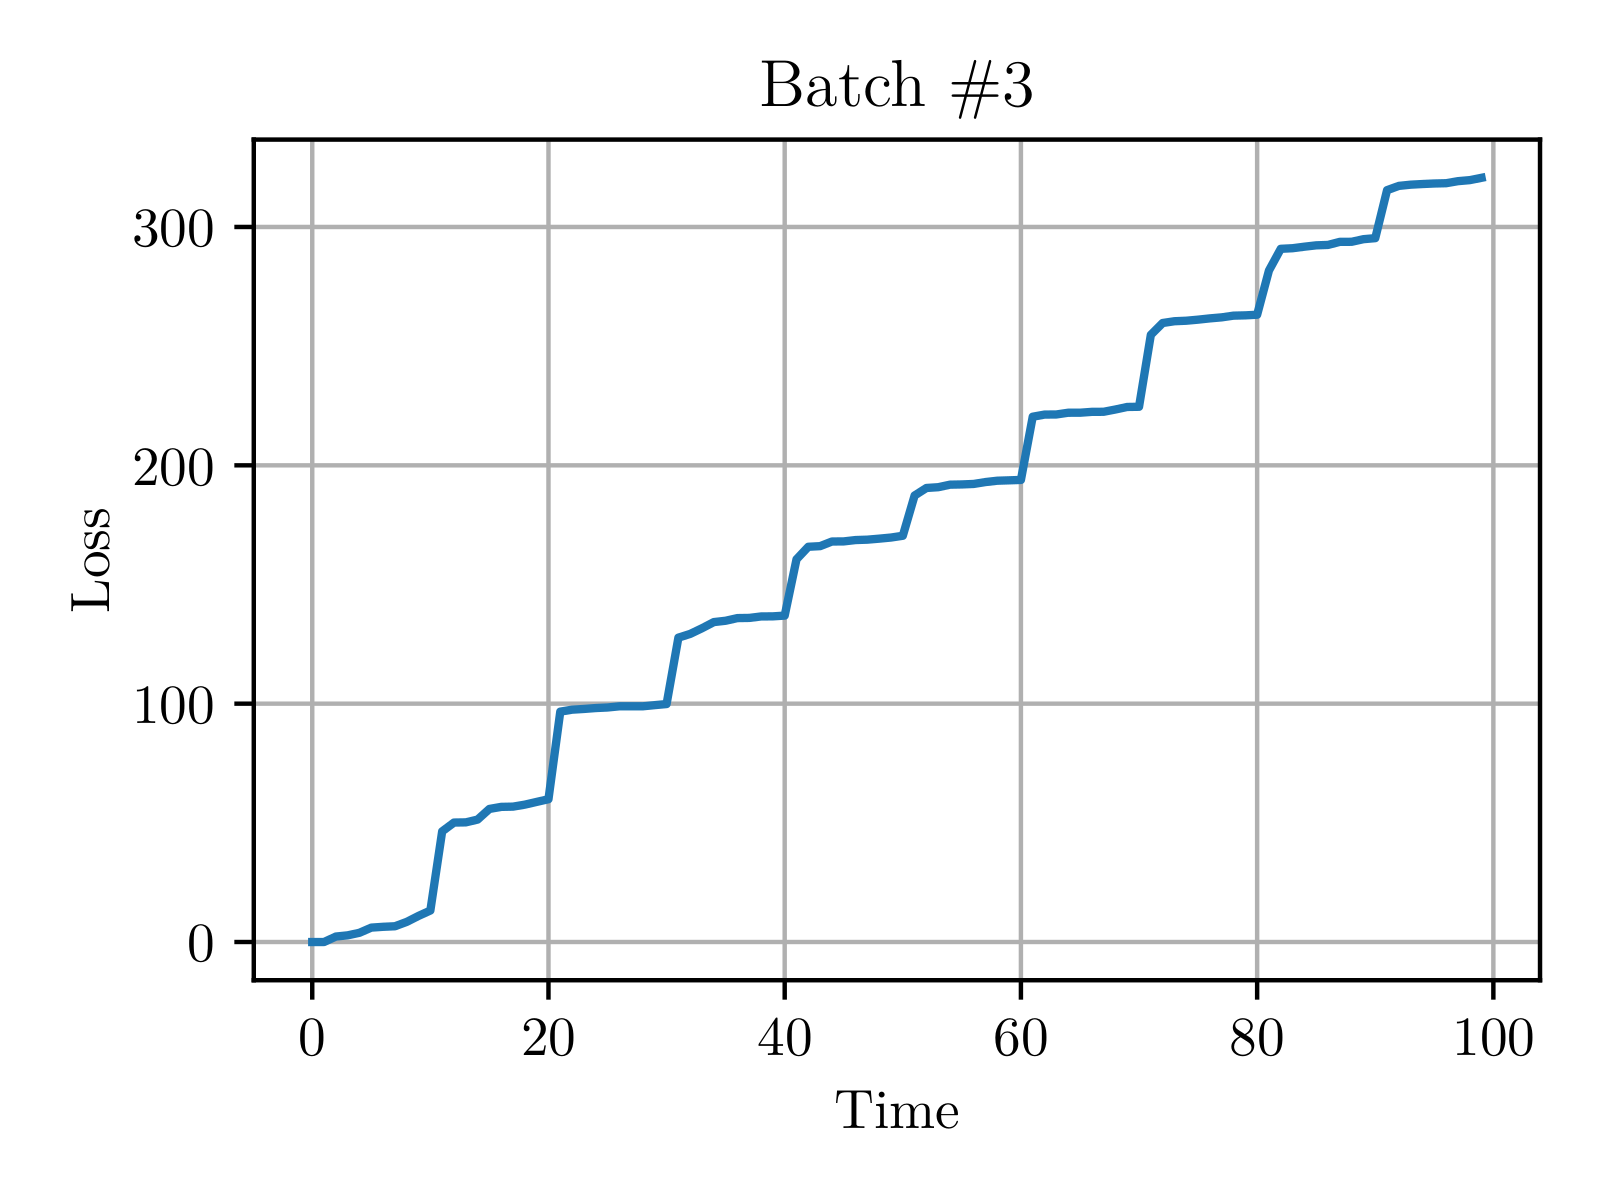
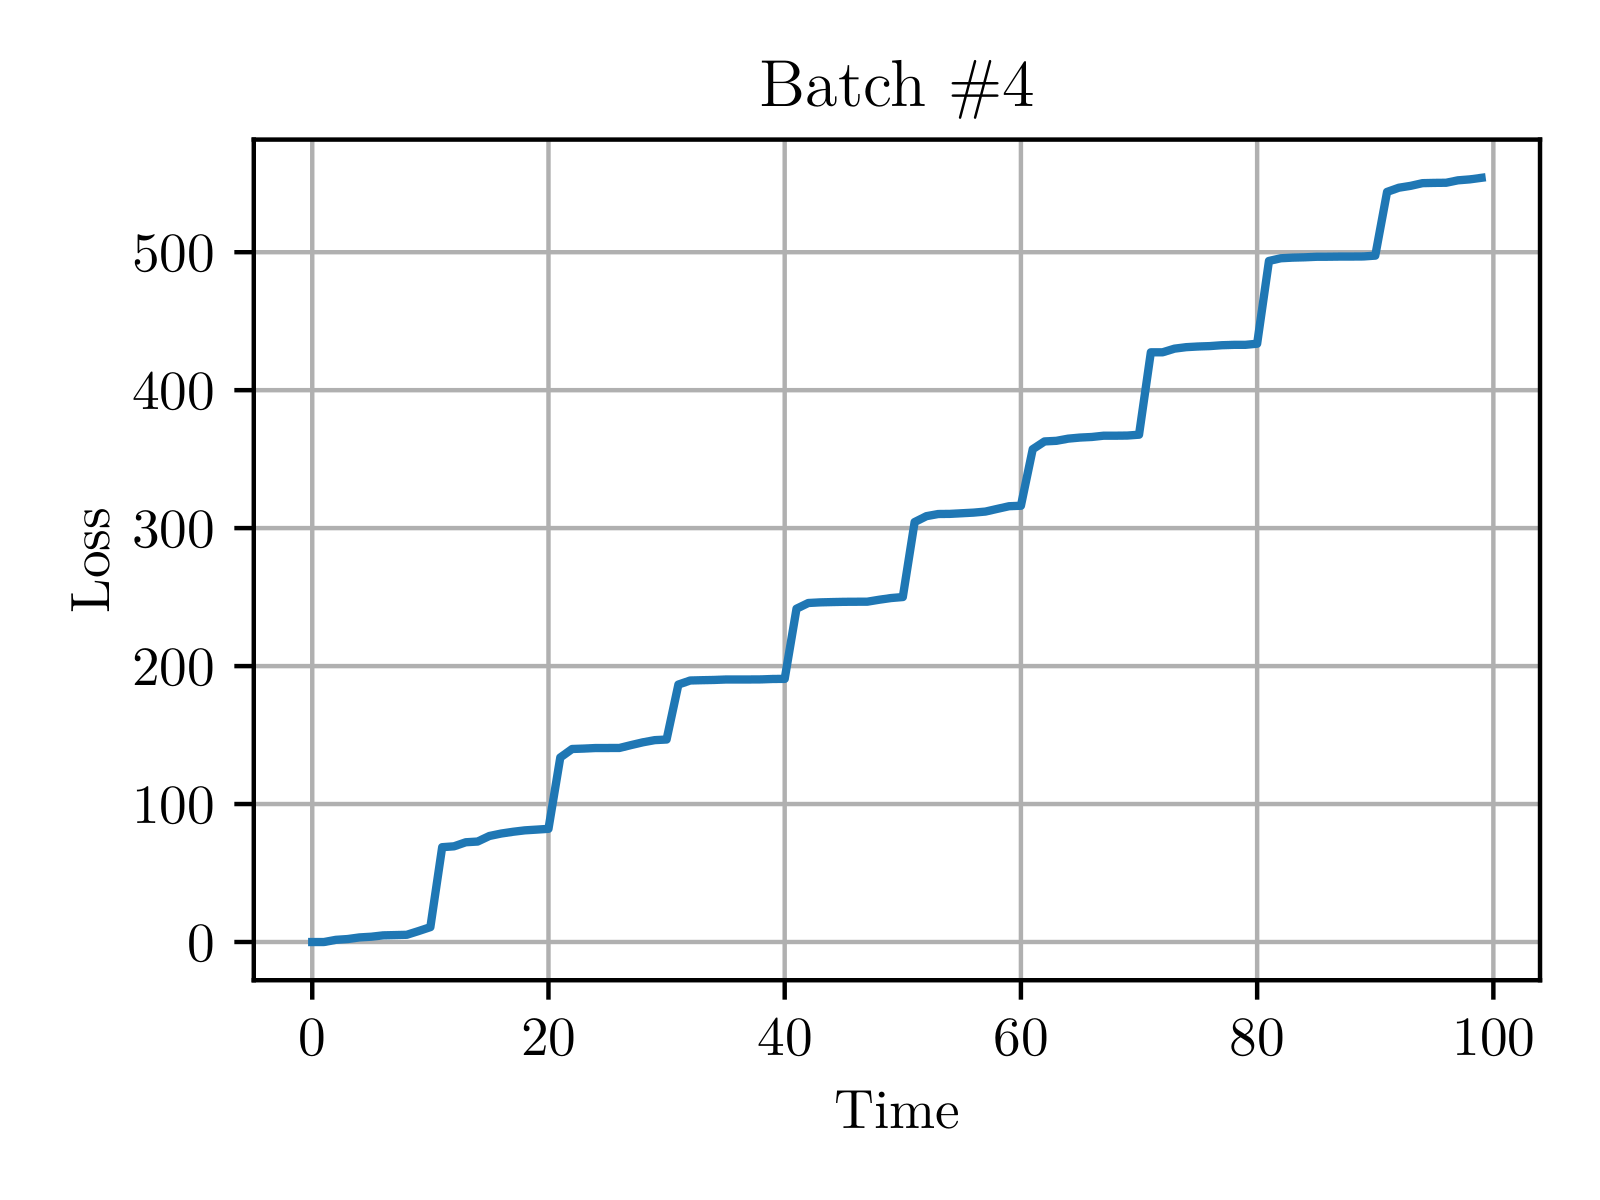
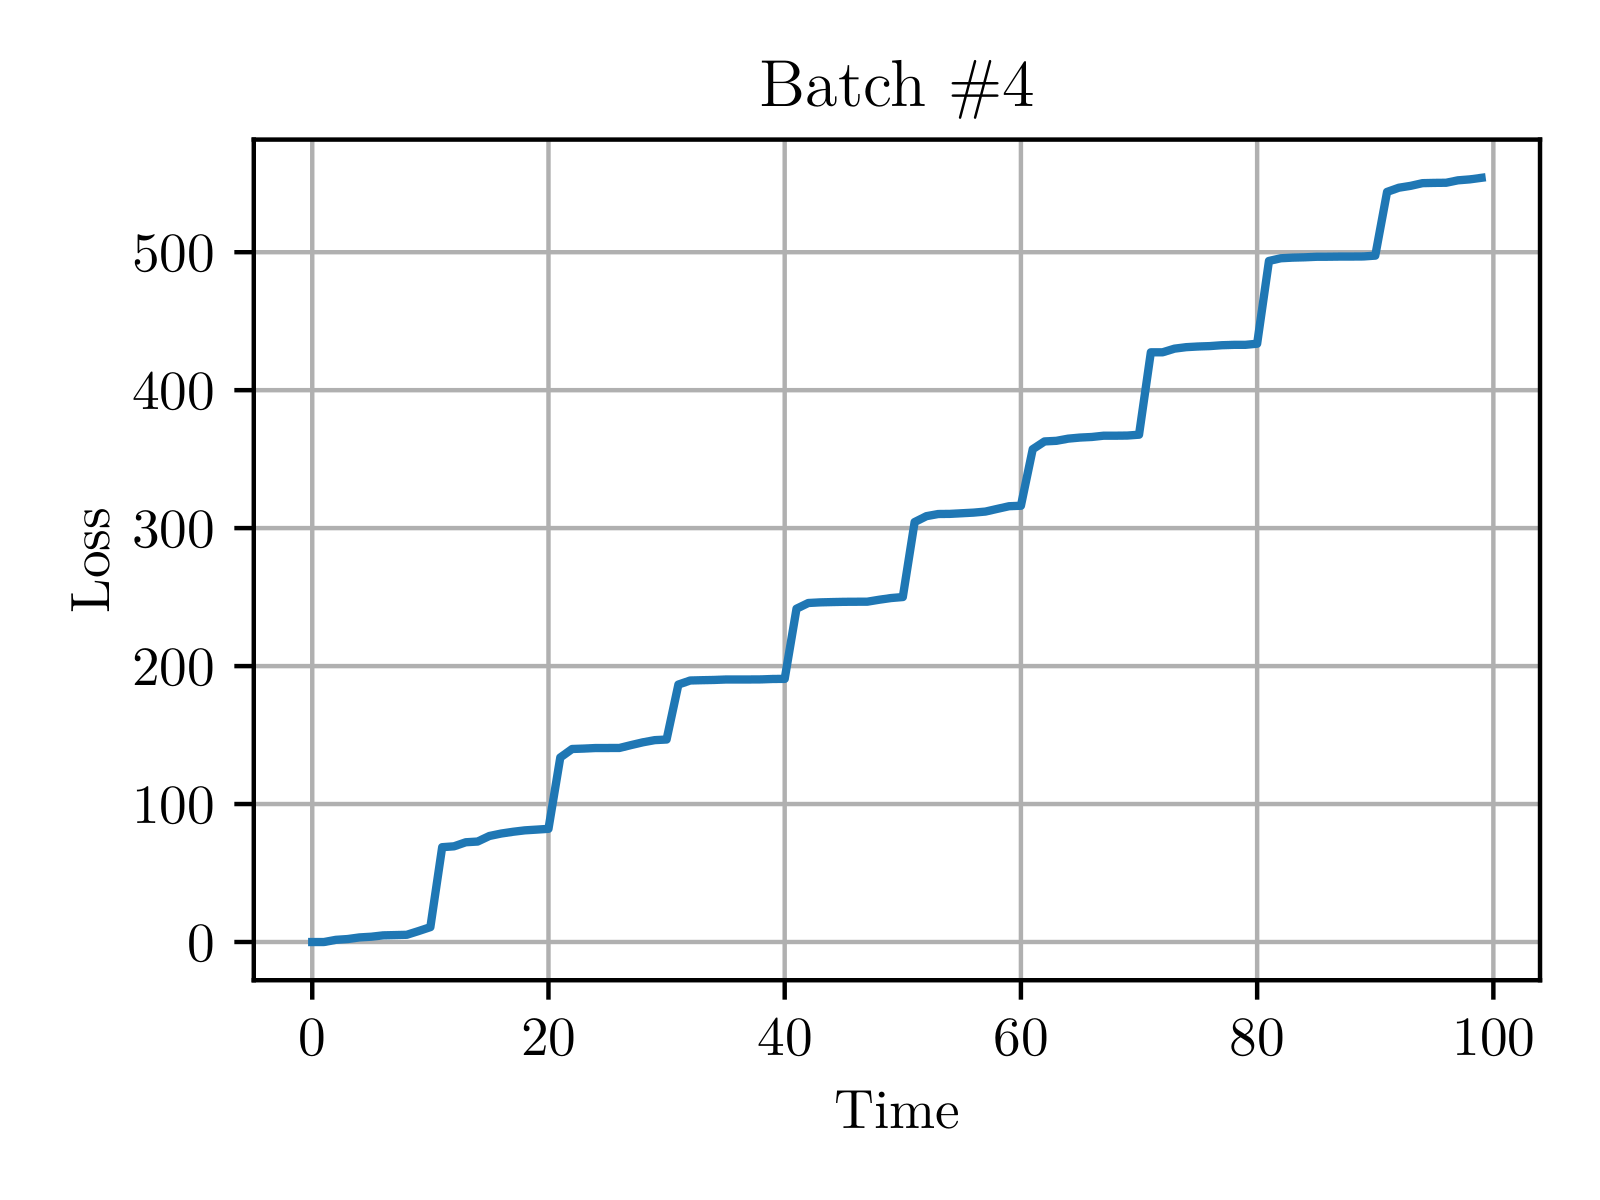

In [19]:
@ftl.with_context
def plot(loss, batch_idx, file_name):
    fig, ax = plt.subplots()
    ax.plot(loss[batch_idx])
    ax.grid()
    ax.set_xlabel('Time')
    ax.set_ylabel('Loss')
    ax.set_title(f'Batch \#{batch_idx + 1}')
    return ftl.save_fig(fig, file_name)

losses = torch.cumsum(torch.sum((X - X_pred)**2, dim=1), dim=1)
ftl.img_grid([
    plot(losses[:, :100], 0, 'loss_b1'),
    plot(losses[:, :100], 1, 'loss_b2'),
    plot(losses[:, :100], 2, 'loss_b3'),
    plot(losses[:, :100], 3, 'loss_b4'),
], n_columns=4)